# Load packages and data

## Packages

In [1]:
# !pip install cvxpy --quiet
# !pip install ecos

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter

import math


# Optimization
!pip install cvxpy --quiet
!pip install ecos

from scipy.optimize import minimize
import cvxpy as cp


## Data

In [3]:
def read_data(fname): 
    path = os.path.normpath(fname) 
    df = pd.read_excel(path)
    return df

In [4]:
#Financial Data
mktcap_df = read_data(r"C:\Users\rl495\OneDrive - University of Sussex\Dissertation\Datasets\mktcap_data_mexico_full_list.xlsx")
prices_df = read_data(r"C:\Users\rl495\OneDrive - University of Sussex\Dissertation\Datasets\price_data_mexico_full_list.xlsx")
ref_df = read_data(r"C:\Users\rl495\OneDrive - University of Sussex\Dissertation\Datasets\ref_data_mexico_full_list.xlsx")

#ESG Data
current_esg_scores = read_data(r"C:\Users\rl495\OneDrive - University of Sussex\Dissertation\Datasets\current_esg_scores_mexico.xlsx")
esg_scores_raw = read_data(r"C:\Users\rl495\OneDrive - University of Sussex\Dissertation\Datasets\esg_scores_mexico_full_list.xlsx")

# Clean and Merge Data

## Clean and wrangle prices_df 

In [5]:
# Create a new column with just the year for prices_df 
prices_df['Year'] = pd.to_datetime(prices_df['Date']).dt.year

# Drop first two rows since these do not contain any relevant data
prices_df = prices_df.drop(index=[0, 1]).reset_index(drop=True)
prices_df.head()

Date NEMAKA MM Equity OMAB MM Equity CEMEXCPO MM Equity  \
0 2010-01-04              NaN          22.21              11.63   
1 2010-01-05              NaN          22.15              11.65   
2 2010-01-06              NaN          22.26              11.54   
3 2010-01-07              NaN          22.53              11.65   
4 2010-01-08              NaN          22.73              11.51   

  GAPB MM Equity LIVEPOL1 MM Equity VOLARA MM Equity PE&OLES* MM Equity  \
0          42.22                NaN              NaN             289.34   
1          42.93               60.1              NaN             283.45   
2          43.13                NaN              NaN             291.27   
3          43.48                NaN              NaN             292.45   
4          43.14                NaN              NaN             294.41   

  ASURB MM Equity IDEALB1 MM Equity  ... KUOB MM Equity GFINBURO MM Equity  \
0           70.97              13.6  ...           11.5              19.81   
1           71.26             13.66  ...           11.5              19.97   
2           72.88             13.92  ...           11.8              20.23   
3           73.22             14.28  ...             12              20.86   
4            72.7              14.1  ...            NaN              20.66   

  MFRISCOA MM Equity GIGANTE* MM Equity SIMECB MM Equity SITES1 MM Equity  \
0                NaN              18.95            37.09              NaN   
1                NaN                NaN            37.28              NaN   
2                NaN                NaN            36.38              NaN   
3                NaN                NaN             35.2              NaN   
4                NaN                NaN            35.62              NaN   

  PINFRA* MM Equity GFAMSAA MM Equity ICHB MM Equity    Year  
0              29.2            25.751           46.4  2010.0  
1             29.19           26.9353          46.02  2010.0  
2                30           27.7868          45.23  2010.0  
3             29.99           29.0004          44.04  2010.0  
4             30.14           28.1881          43.33  2010.0  

[5 rows x 78 columns]

In [6]:
# Drop any stray 'Year' column before melting
if 'Year' in prices_df.columns:
    prices_df = prices_df.drop(columns='Year')

# Ensure the 'Date' column is datetime
prices_df['Date'] = pd.to_datetime(prices_df['Date'])

In [7]:
# Melt to long format
prices_long = prices_df.melt(
    id_vars='Date',
    var_name='Ticker',
    value_name='PX_LAST'
)

# Inspect
print(prices_long.head())

        Date            Ticker PX_LAST
0 2010-01-04  NEMAKA MM Equity     NaN
1 2010-01-05  NEMAKA MM Equity     NaN
2 2010-01-06  NEMAKA MM Equity     NaN
3 2010-01-07  NEMAKA MM Equity     NaN
4 2010-01-08  NEMAKA MM Equity     NaN


In [8]:
prices_long['Year'] = prices_long['Date'].dt.year
prices_long.head()

Date            Ticker PX_LAST  Year
0 2010-01-04  NEMAKA MM Equity     NaN  2010
1 2010-01-05  NEMAKA MM Equity     NaN  2010
2 2010-01-06  NEMAKA MM Equity     NaN  2010
3 2010-01-07  NEMAKA MM Equity     NaN  2010
4 2010-01-08  NEMAKA MM Equity     NaN  2010

In [9]:
# Remove rows for 2025 data for this year is not complete
# Remove rows from 2025 or any future year
prices_long = prices_long[prices_long['Date'].dt.year < 2025]
prices_long.head()

Date            Ticker PX_LAST  Year
0 2010-01-04  NEMAKA MM Equity     NaN  2010
1 2010-01-05  NEMAKA MM Equity     NaN  2010
2 2010-01-06  NEMAKA MM Equity     NaN  2010
3 2010-01-07  NEMAKA MM Equity     NaN  2010
4 2010-01-08  NEMAKA MM Equity     NaN  2010

## Merge with mktcap_df and ref_data

In [10]:
# Melt market cap wide format to long format
mktcap_long = mktcap_df.melt(id_vars='Date', var_name='Ticker', value_name='cur_mkt_cap')

# Clean up column names if needed
mktcap_long['Ticker'] = mktcap_long['Ticker'].str.replace(' CUR_MKT_CAP', '', regex=False)

# Merge market cap into the main dataset
prices_long = prices_long.merge(mktcap_long, on=['Date', 'Ticker'], how='left')

# Merge sector info from ref_df
prices_long = prices_long.merge(ref_df[['Ticker', 'industry_sector']], on='Ticker', how='left')
prices_long.head()

Date            Ticker PX_LAST  Year cur_mkt_cap     industry_sector
0 2010-01-04  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical
1 2010-01-05  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical
2 2010-01-06  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical
3 2010-01-07  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical
4 2010-01-08  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical

In [11]:
# Review dataset and NaNs
print(prices_long.dtypes)
print(prices_long.isna().sum())
print(prices_long.shape)

Date               datetime64[ns]
Ticker                     object
PX_LAST                    object
Year                        int32
cur_mkt_cap                object
industry_sector            object
dtype: object
Date                   0
Ticker                 0
PX_LAST            52849
Year                   0
cur_mkt_cap        42880
industry_sector        0
dtype: int64
(286748, 6)


## Merge latest ESG score into the main dataset

In [12]:
# Merge latest ESG score into the main dataset and rename column
prices_long = prices_long.merge(
    current_esg_scores[['Ticker', 'esg_score']].rename(columns={'esg_score': 'curr_esg_score'}),
    on='Ticker',
    how='left'
)
prices_long.head()

Date            Ticker PX_LAST  Year cur_mkt_cap     industry_sector  \
0 2010-01-04  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical   
1 2010-01-05  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical   
2 2010-01-06  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical   
3 2010-01-07  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical   
4 2010-01-08  NEMAKA MM Equity     NaN  2010         NaN  Consumer, Cyclical   

   curr_esg_score  
0            6.27  
1            6.27  
2            6.27  
3            6.27  
4            6.27

## Find the correct time window

In [13]:
# Count number of valid PX_LAST entries per ticker
ticker_counts = prices_long[prices_long['PX_LAST'].notna()].groupby('Ticker')['Date'].count()

# Find the ticker with the least price data
least_data_ticker = ticker_counts.idxmin()
least_data_count = ticker_counts.min()

print(f"Ticker with least data: {least_data_ticker} ({least_data_count} valid price points)")

Ticker with least data: COXA* MM Equity (1131 valid price points)


In [14]:
date_ranges = prices_long.dropna(subset=['PX_LAST']).groupby('Ticker')['Date'].agg(['min', 'max']).reset_index()
date_ranges.columns = ['Ticker', 'Start_Date', 'End_Date']
date_ranges.head()

Ticker Start_Date   End_Date
0     AC* MM Equity 2010-01-04 2024-12-31
1   AGUA* MM Equity 2014-12-09 2024-12-31
2   ALFAA MM Equity 2010-01-04 2024-12-31
3  ALPEKA MM Equity 2012-04-25 2024-12-31
4  ALSEA* MM Equity 2010-01-04 2024-12-31

### Find common date window across all issuers

In [15]:
common_start = date_ranges['Start_Date'].max()
common_end = date_ranges['End_Date'].min()

print(f"Common time window: {common_start} to {common_end}")

Common time window: 2020-07-07 00:00:00 to 2024-12-31 00:00:00


In [16]:
# Filter the master dataframe to the common date range
filtered_prices = prices_long[
    (prices_long['Date'] >= common_start) &
    (prices_long['Date'] <= common_end)
]
filtered_prices.head()

Date            Ticker PX_LAST  Year cur_mkt_cap  \
2642 2020-07-07  NEMAKA MM Equity    5.04  2020  15508.0009   
2643 2020-07-08  NEMAKA MM Equity    4.88  2020  15015.6834   
2644 2020-07-09  NEMAKA MM Equity     4.8  2020  14769.5247   
2645 2020-07-10  NEMAKA MM Equity    4.81  2020  14800.2945   
2646 2020-07-13  NEMAKA MM Equity    4.89  2020  15046.4533   

         industry_sector  curr_esg_score  
2642  Consumer, Cyclical            6.27  
2643  Consumer, Cyclical            6.27  
2644  Consumer, Cyclical            6.27  
2645  Consumer, Cyclical            6.27  
2646  Consumer, Cyclical            6.27

In [17]:
# Review dataset and NaNs
print(filtered_prices.dtypes)
print(filtered_prices.isna().sum())
print(filtered_prices.shape)

Date               datetime64[ns]
Ticker                     object
PX_LAST                    object
Year                        int32
cur_mkt_cap                object
industry_sector            object
curr_esg_score            float64
dtype: object
Date                0
Ticker              0
PX_LAST            13
Year                0
cur_mkt_cap         2
industry_sector     0
curr_esg_score      0
dtype: int64
(85956, 7)


In [18]:
filtered_prices = filtered_prices.dropna(subset=['PX_LAST', 'cur_mkt_cap']).reset_index(drop=True)
filtered_prices.isna().sum()


Date               0
Ticker             0
PX_LAST            0
Year               0
cur_mkt_cap        0
industry_sector    0
curr_esg_score     0
dtype: int64

In [19]:
# How many tickers are left in the universe?
filtered_prices['Ticker'].nunique()

76

## Universe Analysis - Unconstrained Portfolio

In [20]:
# Final universe and unconstrained portfolio with data from 2020-07-07 to 2024-12-31
final_data = filtered_prices
print(final_data.head())

        Date            Ticker PX_LAST  Year cur_mkt_cap     industry_sector  \
0 2020-07-07  NEMAKA MM Equity    5.04  2020  15508.0009  Consumer, Cyclical   
1 2020-07-08  NEMAKA MM Equity    4.88  2020  15015.6834  Consumer, Cyclical   
2 2020-07-09  NEMAKA MM Equity     4.8  2020  14769.5247  Consumer, Cyclical   
3 2020-07-10  NEMAKA MM Equity    4.81  2020  14800.2945  Consumer, Cyclical   
4 2020-07-13  NEMAKA MM Equity    4.89  2020  15046.4533  Consumer, Cyclical   

   curr_esg_score  
0            6.27  
1            6.27  
2            6.27  
3            6.27  
4            6.27  


C:\Users\rl495\AppData\Local\Temp\ipykernel_4272\3886087883.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\rl495\AppData\Local\Temp\ipykernel_4272\3886087883.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hsv = mpl.cm.get_cmap('hsv', n)


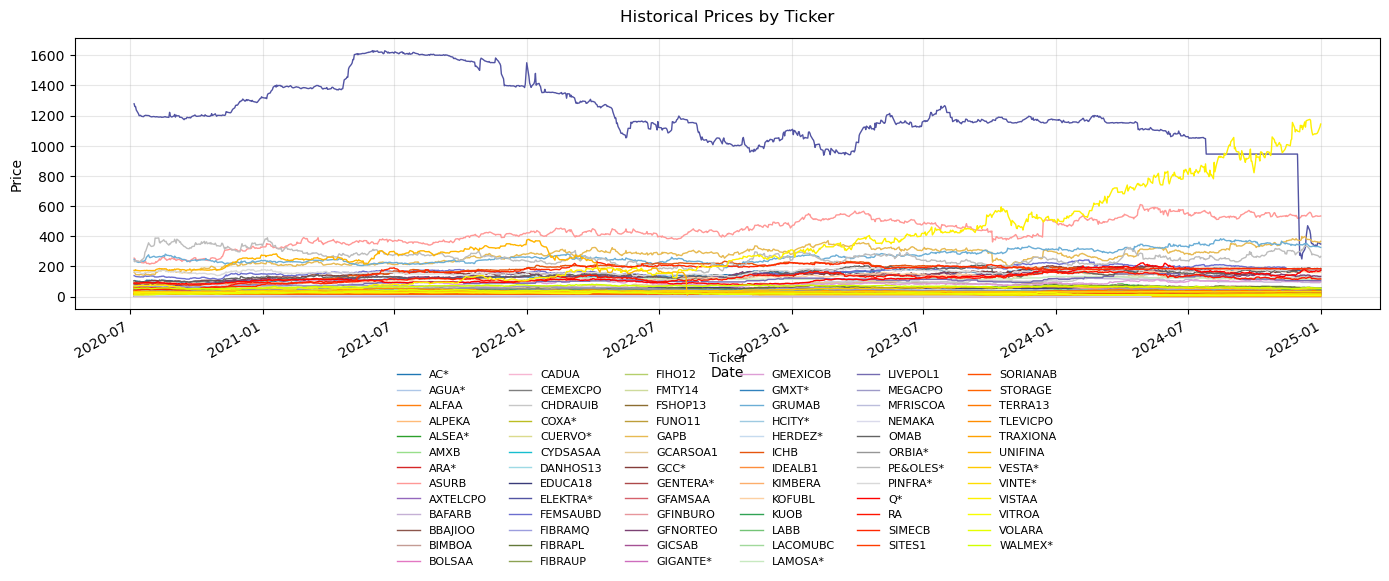

In [21]:
USE_LOG_SCALE = False       # set True to see % moves more evenly across prices
NORMALIZE_TO_100 = False    # set True to rebase each series to 100 at its first date

# Ensure proper types and ordering
df = final_data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby(['Date','Ticker'], as_index=False)['PX_LAST'].last()
prices = df.pivot(index='Date', columns='Ticker', values='PX_LAST').sort_index()

# Shorten legend labels
labels = prices.columns.to_series().str.replace(' MM Equity','', regex=False)

# distinct colors: enough for 40+ tickers, no repeats
def distinct_colors(n):
    palette = []
    for name in ['tab20', 'tab20b', 'tab20c']:          # 60 distinct colors total
        cmap = mpl.cm.get_cmap(name)
        palette.extend([cmap(i) for i in range(cmap.N)])
    if len(palette) < n:                                # fallback if >60 lines
        hsv = mpl.cm.get_cmap('hsv', n)
        palette.extend([hsv(i) for i in range(n)])
    return palette[:n]

colors = distinct_colors(prices.shape[1])

# plot
fig, ax = plt.subplots(figsize=(14, 7))
prices.plot(ax=ax, lw=1, color=colors)

ax.set_title('Historical Prices by Ticker', pad=12)
ax.set_xlabel('Date'); ax.set_ylabel('Price')
ax.grid(True, alpha=0.3)

# compact legend: multiple columns under the chart
n = prices.shape[1]
ncol_leg = min(6, max(2, math.ceil(n/8)))  # aim for ~8 rows
ax.legend(
    labels=labels, title='Ticker',
    ncol=ncol_leg, loc='upper center', bbox_to_anchor=(0.5, -0.12),
    fontsize=8, title_fontsize=9, frameon=False
)

plt.tight_layout(rect=[0, 0.12, 1, 1])  # leave room for legend at bottom
plt.show()

C:\Users\rl495\AppData\Local\Temp\ipykernel_4272\2966379752.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = prices.pct_change()
C:\Users\rl495\AppData\Local\Temp\ipykernel_4272\3886087883.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(name)
C:\Users\rl495\AppData\Local\Temp\ipykernel_4272\3886087883.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  hsv = mpl.cm.get_cmap('hsv', n)


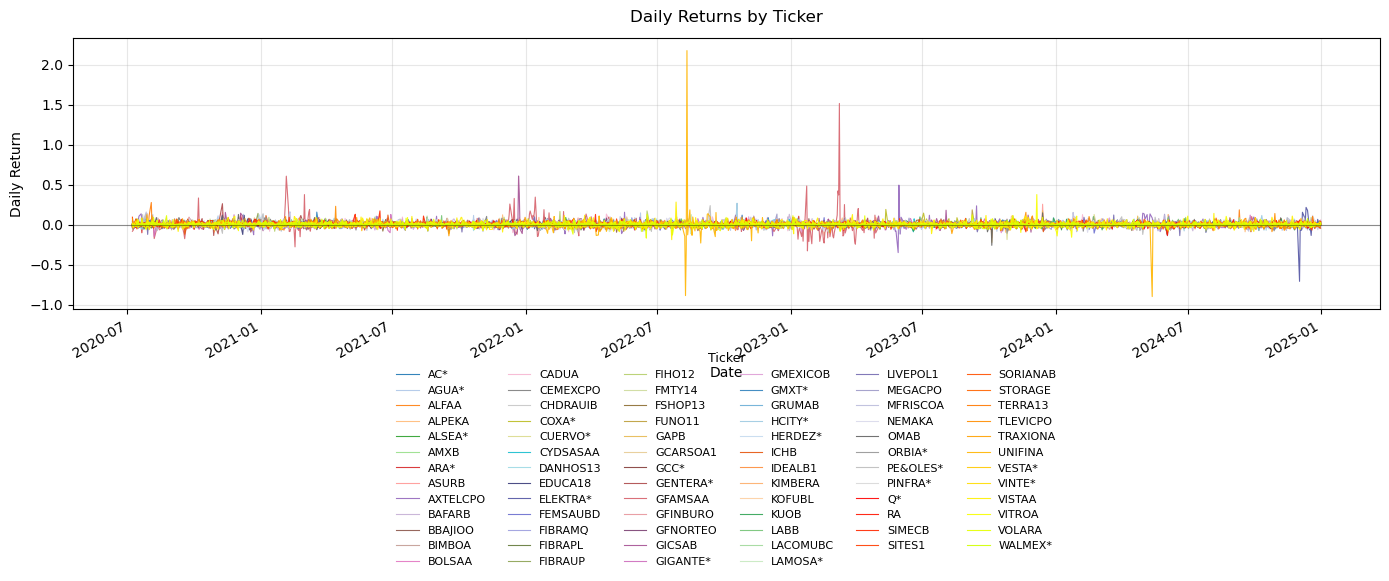

In [22]:
# options
LOG_RETURNS = False          # True: log returns via log1p(pct_change); False: simple pct_change

prices = (
    df.pivot(index='Date', columns='Ticker', values='PX_LAST')
      .sort_index()
      .apply(pd.to_numeric, errors='coerce')   # force numeric
      .where(lambda x: x > 0)                  # avoid log of <= 0
)
prices = prices.dropna(how='all', axis=1)      # drop tickers with no data

# 2) Returns
if LOG_RETURNS:
    # safer than np.log(prices / prices.shift(1)) for mixed/dirty data
    rets = np.log1p(prices.pct_change())
else:
    rets = prices.pct_change()
rets = rets.dropna(how='all')

labels = rets.columns.to_series().str.replace(' MM Equity','', regex=False)
colors = distinct_colors(rets.shape[1])

# 4) Plot
fig, ax = plt.subplots(figsize=(14, 7))
rets.plot(ax=ax, lw=0.8, alpha=0.9, color=colors)

ax.axhline(0, color='black', lw=0.8, alpha=0.4)
ax.set_title('Daily Returns by Ticker' + (' (log)' if LOG_RETURNS else ''), pad=12)
ax.set_xlabel('Date'); ax.set_ylabel('Daily Return')
ax.grid(True, alpha=0.3)

# Compact legend under the chart
n = rets.shape[1]
ncol_leg = min(6, max(2, math.ceil(n/8)))  # ~8 rows target
ax.legend(labels=labels, title='Ticker',
          ncol=ncol_leg, loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fontsize=8, title_fontsize=9, frameon=False)

plt.tight_layout(rect=[0, 0.12, 1, 1])
plt.show()



## ESG Portfolio construction based on constraints

In [23]:
# Calculate mean ESG score
mean_esg_score = final_data['curr_esg_score'].mean()

print(f"Mean ESG Score: {mean_esg_score:.2f}")

# Filter for issuers with ESG_Score greater than the mean
esg_portfolio = final_data[final_data['curr_esg_score'] >= mean_esg_score]

# Check results
print(f"Number of rows in ESG portfolio: {len(esg_portfolio)}")
print(esg_portfolio['Ticker'].nunique(), "unique issuers in ESG portfolio")

# Display first few rows
esg_portfolio.head()


Mean ESG Score: 3.37
Number of rows in ESG portfolio: 49758
44 unique issuers in ESG portfolio


Date            Ticker PX_LAST  Year cur_mkt_cap     industry_sector  \
0 2020-07-07  NEMAKA MM Equity    5.04  2020  15508.0009  Consumer, Cyclical   
1 2020-07-08  NEMAKA MM Equity    4.88  2020  15015.6834  Consumer, Cyclical   
2 2020-07-09  NEMAKA MM Equity     4.8  2020  14769.5247  Consumer, Cyclical   
3 2020-07-10  NEMAKA MM Equity    4.81  2020  14800.2945  Consumer, Cyclical   
4 2020-07-13  NEMAKA MM Equity    4.89  2020  15046.4533  Consumer, Cyclical   

   curr_esg_score  
0            6.27  
1            6.27  
2            6.27  
3            6.27  
4            6.27

C:\Users\rl495\AppData\Local\Temp\ipykernel_4272\1017028362.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(name)


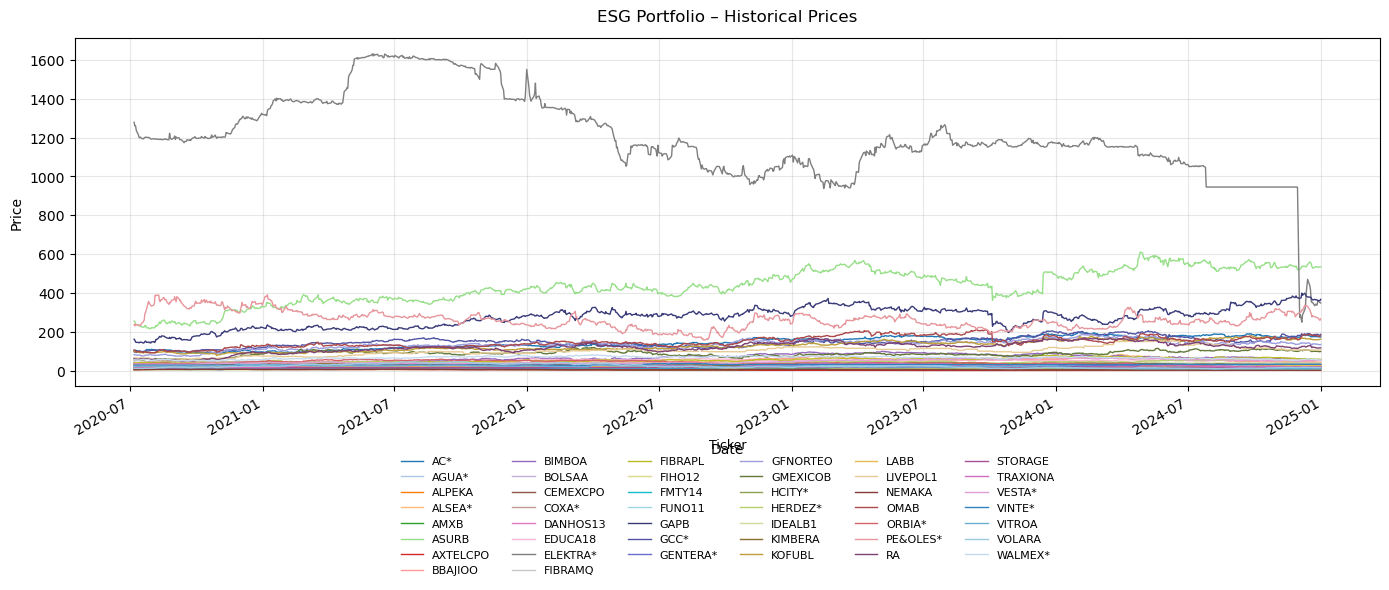

C:\Users\rl495\AppData\Local\Temp\ipykernel_4272\1017028362.py:54: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets_esg = np.log1p(prices_esg.pct_change()) if LOG_RETURNS else prices_esg.pct_change()


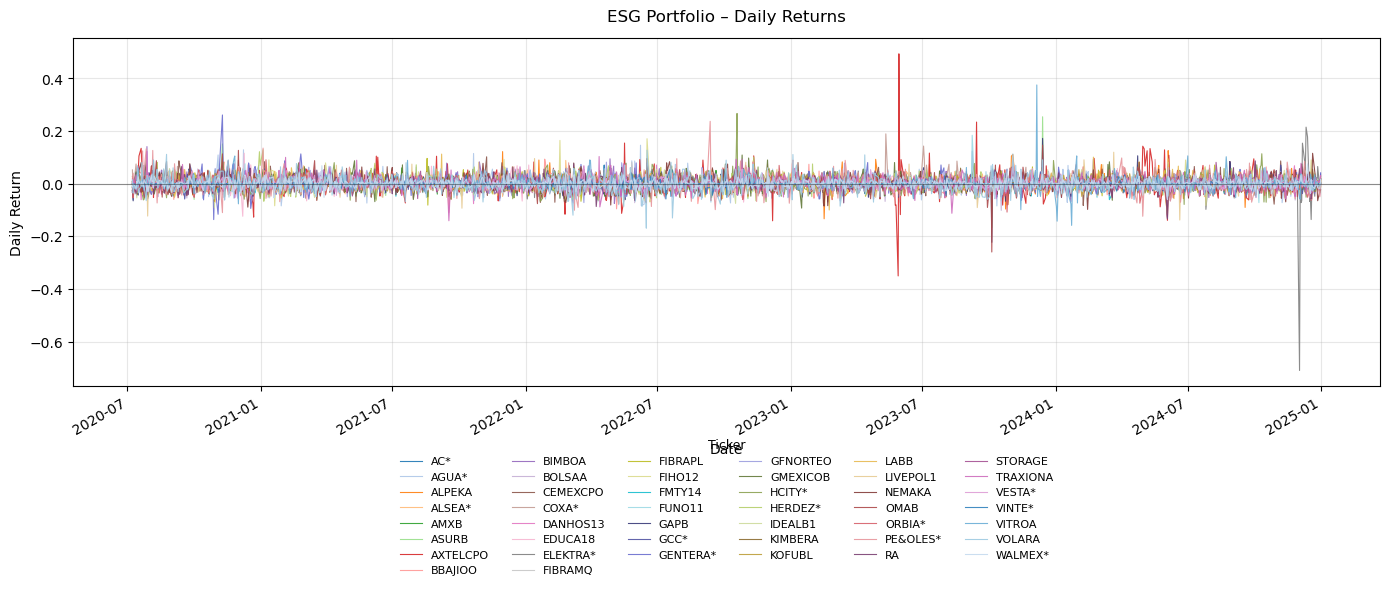

In [24]:
NORMALIZE_TO_100 = False   # True: rebase prices to 100 at start
LOG_RETURNS = False         # True: log returns via log1p(pct_change)


def _prep_prices(long_df):
    """Return a wide, numeric price matrix (rows=Date, cols=Ticker)."""
    df = long_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.groupby(['Date','Ticker'], as_index=False)['PX_LAST'].last()
    wide = (df.pivot(index='Date', columns='Ticker', values='PX_LAST')
              .sort_index()
              .apply(pd.to_numeric, errors='coerce')
              .where(lambda x: x > 0))          # avoid non-positive prices
    return wide.dropna(how='all', axis=1)

def _distinct_colors(n):
    """Enough unique colors for many series (tab20 + tab20b + tab20c, then HSV)."""
    palette = []
    for name in ['tab20','tab20b','tab20c']:
        cmap = mpl.cm.get_cmap(name)
        palette.extend([cmap(i) for i in range(cmap.N)])
    if len(palette) < n:
        hsv = mpl.cm.get_cmap('hsv', n)
        palette.extend([hsv(i) for i in range(n)])
    return palette[:n]

def _place_legend(ax, labels, nseries):
    """Compact legend under the chart."""
    ncol = min(6, max(2, math.ceil(nseries/8)))  # aim ~8 rows
    ax.legend(labels=labels, title='Ticker',
              ncol=ncol, loc='upper center', bbox_to_anchor=(0.5, -0.12),
              fontsize=8, title_fontsize=9, frameon=False)
    plt.tight_layout(rect=[0, 0.12, 1, 1])

# ESG portfolio plots
prices_esg = _prep_prices(esg_portfolio)
labels_esg = prices_esg.columns.to_series().str.replace(' MM Equity','', regex=False)
colors_esg = _distinct_colors(prices_esg.shape[1])

# Daily prices
fig, ax = plt.subplots(figsize=(14, 7))
plot_prices = prices_esg.copy()
if NORMALIZE_TO_100:
    plot_prices = plot_prices.divide(plot_prices.ffill().bfill().iloc[0]).mul(100)

plot_prices.plot(ax=ax, lw=1, color=colors_esg)
ax.set_title('ESG Portfolio – Historical Prices' + (' (rebased to 100)' if NORMALIZE_TO_100 else ''), pad=12)
ax.set_xlabel('Date'); ax.set_ylabel('Index' if NORMALIZE_TO_100 else 'Price')
ax.grid(True, alpha=0.3)
__ = _place_legend(ax, labels_esg, plot_prices.shape[1])
plt.show()

# Daily returns
rets_esg = np.log1p(prices_esg.pct_change()) if LOG_RETURNS else prices_esg.pct_change()
rets_esg = rets_esg.dropna(how='all')

fig, ax = plt.subplots(figsize=(14, 7))
rets_esg.plot(ax=ax, lw=0.8, alpha=0.9, color=colors_esg)
ax.axhline(0, color='black', lw=0.8, alpha=0.4)
ax.set_title('ESG Portfolio – Daily Returns' + (' (log)' if LOG_RETURNS else ''), pad=12)
ax.set_xlabel('Date'); ax.set_ylabel('Daily Return')
ax.grid(True, alpha=0.3)
__ = _place_legend(ax, labels_esg, rets_esg.shape[1])

# Optional: cap extreme y-values if a few outliers dominate
# lo = rets_esg.quantile(0.01, numeric_only=True).min()
# hi = rets_esg.quantile(0.99, numeric_only=True).max()
# ax.set_ylim(lo, hi)

plt.show()

# Portfolio Optimization

## Markowitz Mean-Variance model

### Unconstrained Portfolio

#### Unconstrained Return log matrix

In [25]:
# Pivot prices to wide format
price_matrix = final_data.pivot(index='Date', columns='Ticker', values='PX_LAST')

# Sort by date
price_matrix = price_matrix.sort_index()

# Force numeric types (fixes the error)
price_matrix = price_matrix.apply(pd.to_numeric, errors='coerce')

# Calculate log returns
returns_matrix = np.log(price_matrix / price_matrix.shift(1))

returns_matrix.head()

Ticker      AC* MM Equity  AGUA* MM Equity  ALFAA MM Equity  ALPEKA MM Equity  \
Date                                                                            
2020-07-07            NaN              NaN              NaN               NaN   
2020-07-08      -0.000961         0.006344        -0.023108          0.002838   
2020-07-09       0.001634        -0.062801        -0.017027         -0.000567   
2020-07-10      -0.007035        -0.027305        -0.010624          0.002266   
2020-07-13      -0.024277        -0.013061         0.046945         -0.004538   

Ticker      ALSEA* MM Equity  AMXB MM Equity  ARA* MM Equity  ASURB MM Equity  \
Date                                                                            
2020-07-07               NaN             NaN             NaN              NaN   
2020-07-08         -0.019914       -0.012867       -0.015385        -0.014611   
2020-07-09         -0.029734       -0.035888       -0.015625        -0.046617   
2020-07-10         -0.020479       -0.000746        0.011742        -0.011190   
2020-07-13         -0.015289        0.000746        0.007752        -0.017259   

Ticker      AXTELCPO MM Equity  BAFARB MM Equity  ...  TERRA13 MM Equity  \
Date                                              ...                      
2020-07-07                 NaN               NaN  ...                NaN   
2020-07-08            0.027129               0.0  ...          -0.020405   
2020-07-09           -0.012240               0.0  ...           0.001872   
2020-07-10            0.002460               0.0  ...          -0.012044   
2020-07-13           -0.002460               0.0  ...           0.012418   

Ticker      TLEVICPO MM Equity  TRAXIONA MM Equity  UNIFINA MM Equity  \
Date                                                                    
2020-07-07                 NaN                 NaN                NaN   
2020-07-08            0.074172           -0.015168          -0.005541   
2020-07-09           -0.046797            0.017316           0.028981   
2020-07-10           -0.000436           -0.004301          -0.022346   
2020-07-13           -0.030077            0.033207          -0.009417   

Ticker      VESTA* MM Equity  VINTE* MM Equity  VISTAA MM Equity  \
Date                                                               
2020-07-07               NaN               NaN               NaN   
2020-07-08          0.003519          0.000000           0.00000   
2020-07-09         -0.008230         -0.000361           0.00000   
2020-07-10         -0.010384          0.000361           0.00000   
2020-07-13         -0.011096         -0.017841           0.04879   

Ticker      VITROA MM Equity  VOLARA MM Equity  WALMEX* MM Equity  
Date                                                               
2020-07-07               NaN               NaN                NaN  
2020-07-08         -0.007830          0.014389          -0.011534  
2020-07-09          0.000000         -0.036803          -0.002723  
2020-07-10         -0.013187         -0.012281          -0.002548  
2020-07-13         -0.000885         -0.022312          -0.018204  

[5 rows x 76 columns]

#### Prep the return data (simple returns)

In [26]:
TRADING_DAYS = 252
RF_ANNUAL = 0.0775                  
RF_DAILY = RF_ANNUAL / TRADING_DAYS

# Start from daily log returns
R_log = returns_matrix.copy()

# Keep only assets with at least some data, then keep common dates only
R_log = R_log.dropna(how='all', axis=1)
R_log = R_log.dropna(how='any', axis=0)   # common date range across assets

# Convert to simple daily returns
R = np.exp(R_log) - 1.0                   # DataFrame, rows=dates, cols=tickers

#### Estimate mu and Sigma

In [27]:
mu_daily = R.mean()            # per-asset expected daily return (simple)
Sigma_daily = R.cov()          # daily covariance matrix

mu_annual = mu_daily * TRADING_DAYS
Sigma_annual = Sigma_daily * TRADING_DAYS

#### Optimization function

In [28]:
def solve_max_sharpe(R_simple, rf_daily=0.0, allow_short=False):
    # Estimate the inputs to Markowitz: expected (daily) returns mu and covariance Sigma from historical data.
    X = R_simple.copy()
    mu = X.mean().values
    Sigma = X.cov().values
    n = X.shape[1]
    cols = X.columns

    # Objective function is the negative Sharpe ratio (so minimizing it ≡ maximizing the Sharpe).
    def neg_sharpe(w):
        ret = w @ mu
        vol = np.sqrt(w @ Sigma @ w)
        # avoid divide-by-zero
        if vol <= 0: 
            return 1e6
        return - (ret - rf_daily) / vol

    # constraints: sum w = 1
    cons = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1})
    # bounds
    if allow_short:
        bounds = [(-1, 1)] * n
    else:
        bounds = [(0, 1)] * n

    # start from equal weight on available assets (initial guess for the optimizer).
    w0 = np.full(n, 1.0/n)

    # Uses SLSQP (Sequential Least Squares Quadratic Programming), a gradient-based (...)
    # constrained optimizer suited to smooth objectives with linear constraints/bounds.
    res = minimize(neg_sharpe, w0, method='SLSQP', bounds=bounds, constraints=cons, options={'maxiter': 10_000})
    w = pd.Series(res.x, index=cols, name='weight')
    return w, res

#### Optimized weights

In [29]:
w_opt, opt_res = solve_max_sharpe(R, rf_daily=RF_DAILY, allow_short=False)
w_opt.sort_values(ascending=False).head(10)

Ticker
LAMOSA* MM Equity     0.236541
SIMECB MM Equity      0.129275
CHDRAUIB MM Equity    0.123251
BAFARB MM Equity      0.109876
EDUCA18 MM Equity     0.090682
VISTAA MM Equity      0.087941
FIHO12 MM Equity      0.045263
ICHB MM Equity        0.041595
LIVEPOL1 MM Equity    0.032716
AC* MM Equity         0.026006
Name: weight, dtype: float64

#### Portfolio Stats (annualized)

In [30]:
# daily portfolio simple returns with fixed weights
rp = (R @ w_opt)

ann_ret = rp.mean() * TRADING_DAYS
ann_vol = rp.std() * np.sqrt(TRADING_DAYS)
ann_sr  = (ann_ret - RF_ANNUAL) / ann_vol   # Sharpe (annual)

print(f"Assets used: {R.shape[1]}")
print(f"Annualized return: {ann_ret: .4%}")
print(f"Annualized vol:    {ann_vol: .4%}")
print(f"Sharpe (annual):   {ann_sr: .2f}")

Assets used: 76
Annualized return:  33.5615%
Annualized vol:     9.7897%
Sharpe (annual):    2.64


#### Unconstrained efficient frontier + assets in one plot

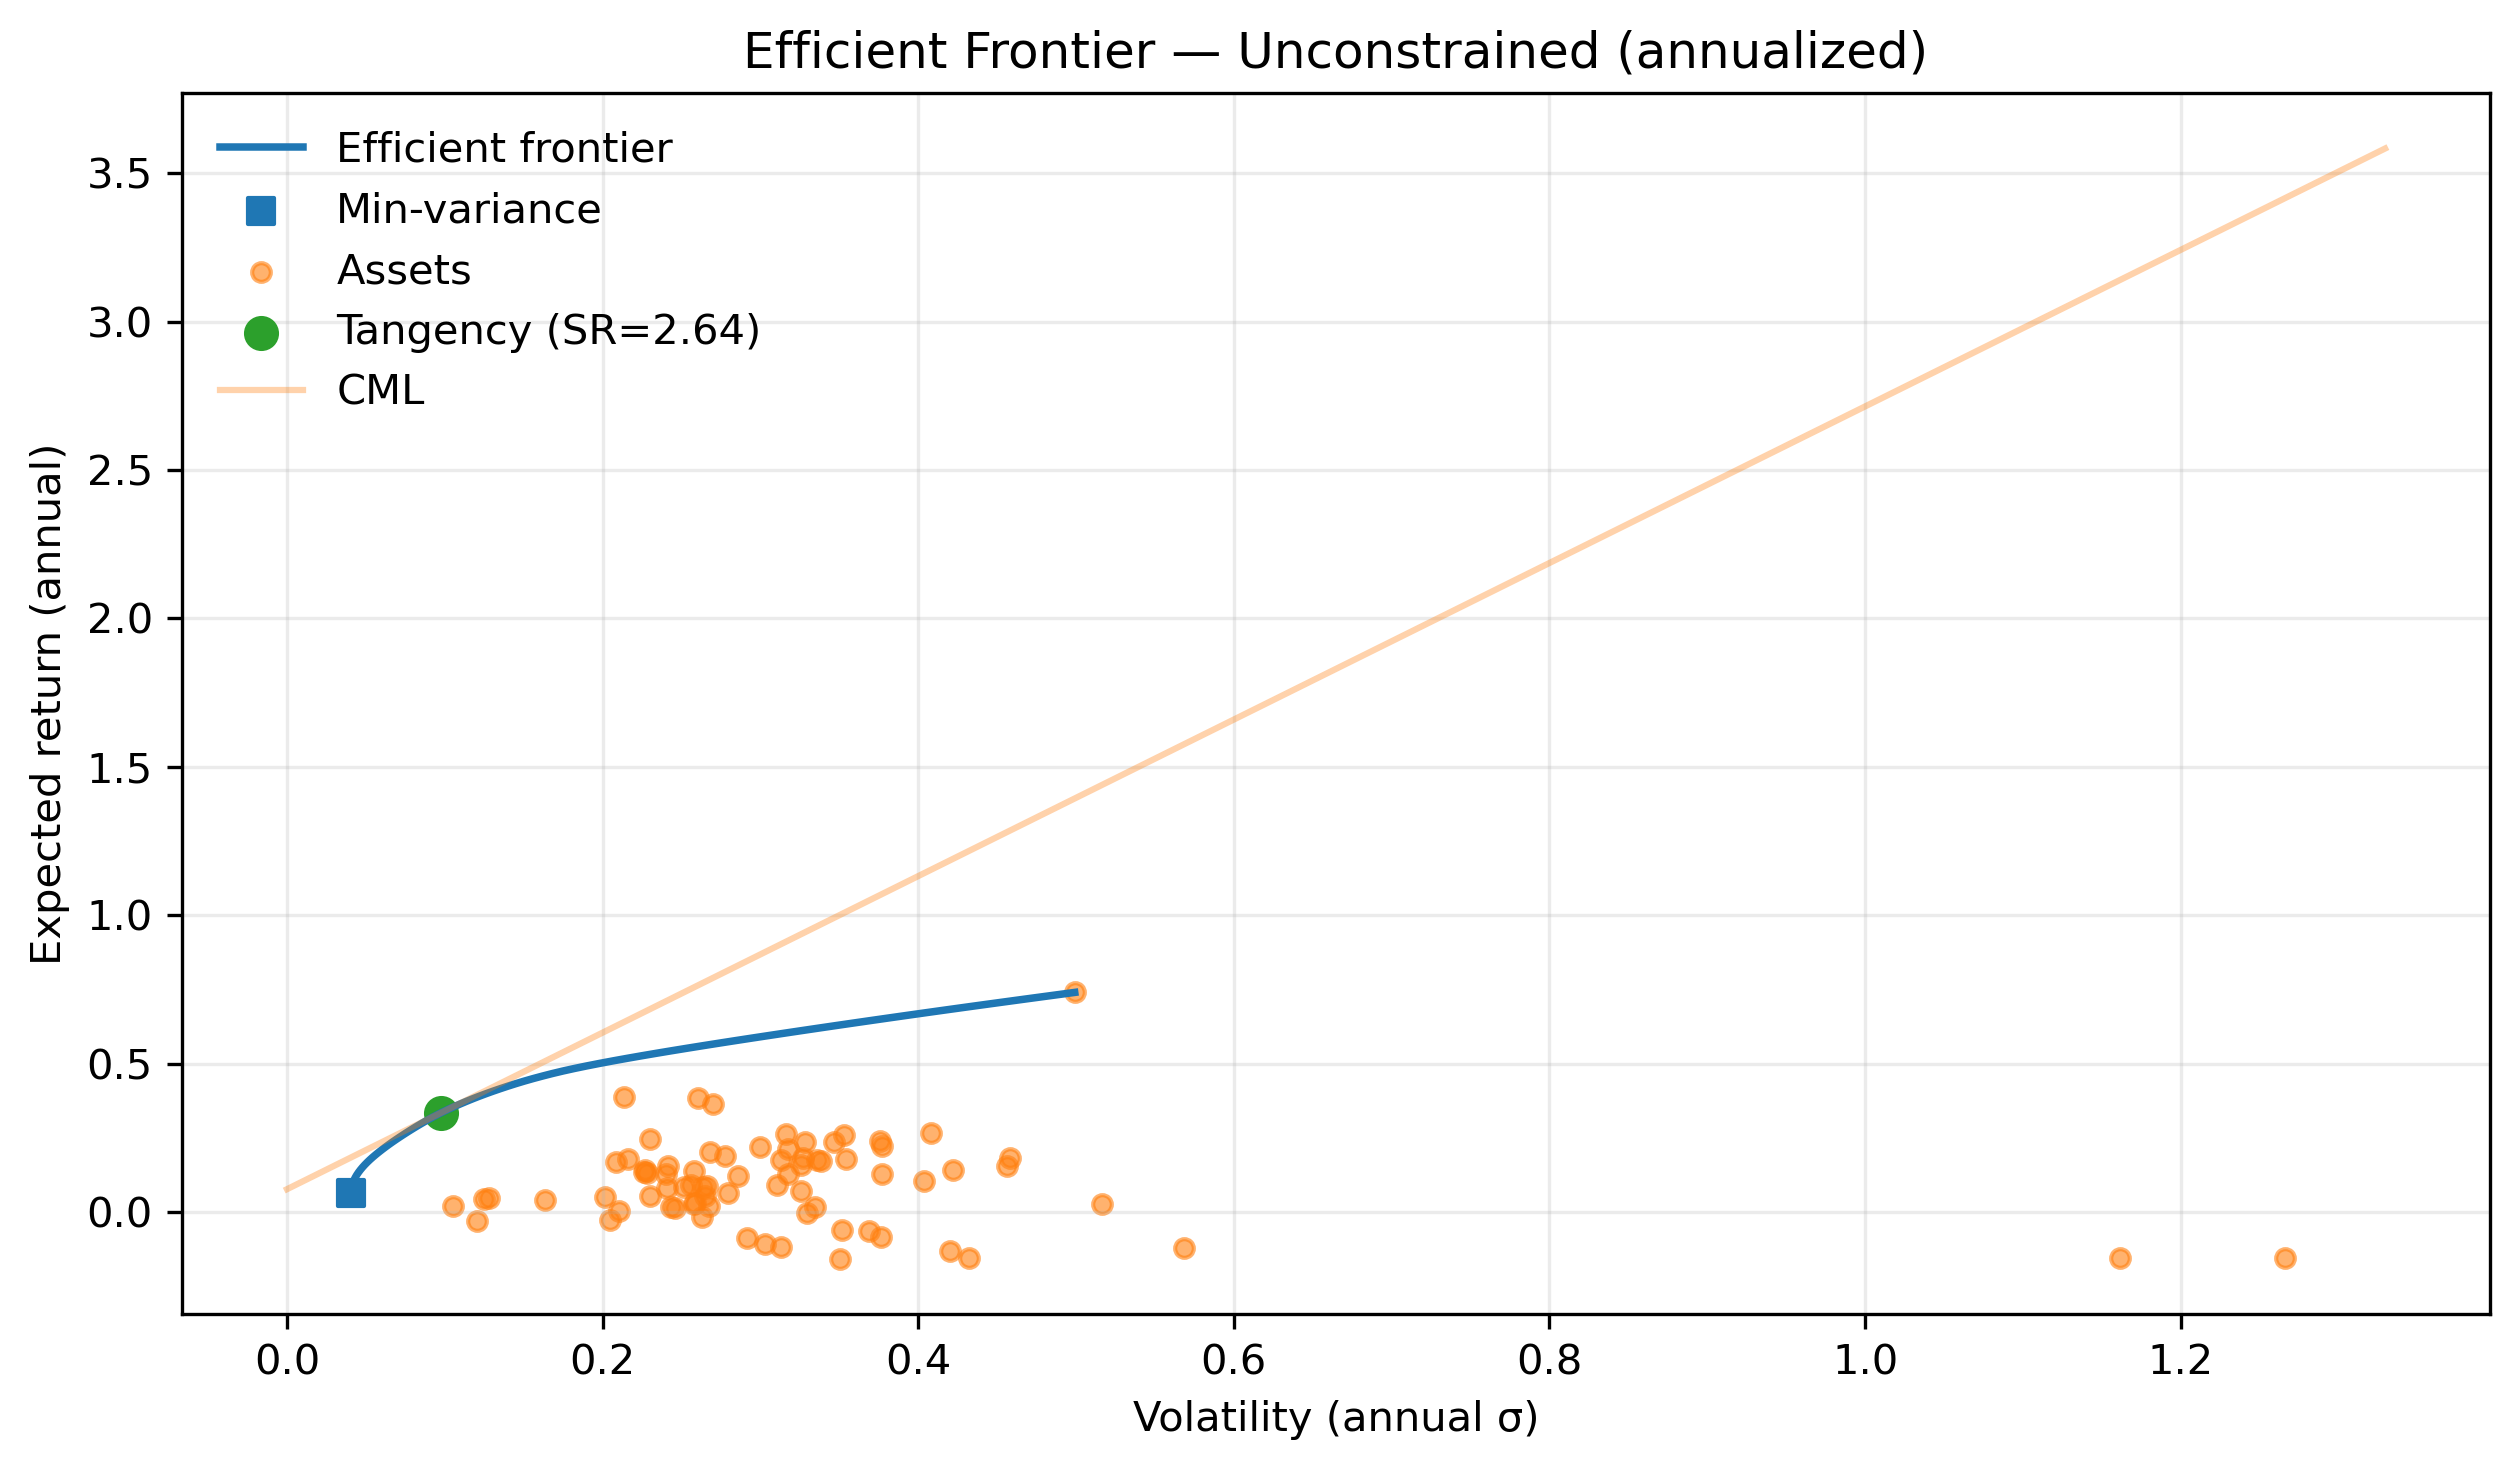

In [31]:
mu  = mu_annual.values
cov = Sigma_annual.values
n   = len(mu)

# helpers
def var_obj(w):                            # minimize portfolio variance
    return w @ cov @ w

def neg_sharpe_obj(w):                     # maximize Sharpe (annual units)
    v = np.sqrt(w @ cov @ w)
    if v <= 0: 
        return 1e9
    return - (mu @ w - RF_ANNUAL) / v

cons_sum = {'type':'eq','fun':lambda w: np.sum(w) - 1}
bnds = [(0.0, 1.0)] * n                    # long-only to match earlier call
w0 = np.full(n, 1.0/n)

# Minimum-variance portfolio (start point)
res_mv = minimize(var_obj, w0, method='SLSQP', bounds=bnds, constraints=[cons_sum],
                  options={'maxiter':8000, 'ftol':1e-12})
w_mv   = res_mv.x
ret_mv = float(mu @ w_mv)
vol_mv = float(np.sqrt(w_mv @ cov @ w_mv))

# Trace the efficient (upper) branch by sweeping target returns
eps   = 1e-6
tmin  = ret_mv + eps
tmax  = float(mu.max()) - eps
tgrid = np.linspace(tmin, tmax, 80) if tmax > tmin else np.array([ret_mv])

vols, rets = [], []
w_start = w_mv.copy()
for tr in tgrid:
    cons = [cons_sum, {'type':'eq','fun':lambda w, tr=tr: mu @ w - tr}]
    res  = minimize(var_obj, w_start, method='SLSQP', bounds=bnds, constraints=cons,
                    options={'maxiter':8000, 'ftol':1e-12})
    if not res.success:
        continue
    w_start = res.x
    rets.append(float(mu @ res.x))
    vols.append(float(np.sqrt(res.x @ cov @ res.x)))

vols = np.array(vols); rets = np.array(rets)

# Tangency (max-Sharpe) from the SAME mu, sigma (for plotting the point + CML)
res_tan = minimize(neg_sharpe_obj, w0, method='SLSQP', bounds=bnds, constraints=[cons_sum],
                   options={'maxiter':8000, 'ftol':1e-12})
w_tan   = res_tan.x
r_tan   = float(mu @ w_tan)
v_tan   = float(np.sqrt(w_tan @ cov @ w_tan))
sr_tan = (r_tan - RF_ANNUAL) / v_tan

# Asset points directly from the diagonal of sigma and mu (already annual)
assets_vol = np.sqrt(np.diag(cov))
assets_ret = mu

# 5) Plot
fig, ax = plt.subplots(figsize=(8.5, 5), dpi=300)
ax.plot(vols, rets, lw=1.8, label="Efficient frontier")
ax.scatter([vol_mv], [ret_mv], s=40, marker="s", label="Min-variance")
ax.scatter(assets_vol, assets_ret, s=20, alpha=0.6, label="Assets")
ax.scatter([v_tan], [r_tan], s=55, label=f"Tangency (SR={sr_tan:.2f})")

# Capital Market Line (through RF and tangency)
x = np.linspace(0, max(vols.max(), assets_vol.max())*1.05, 60)
ax.plot(x, RF_ANNUAL + ((r_tan - RF_ANNUAL)/v_tan) * x, alpha=0.35, label="CML")

ax.set_title("Efficient Frontier — Unconstrained (annualized)")
ax.set_xlabel("Volatility (annual σ)")
ax.set_ylabel("Expected return (annual)")
ax.grid(True, alpha=0.25)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

#### $1 cumulative index

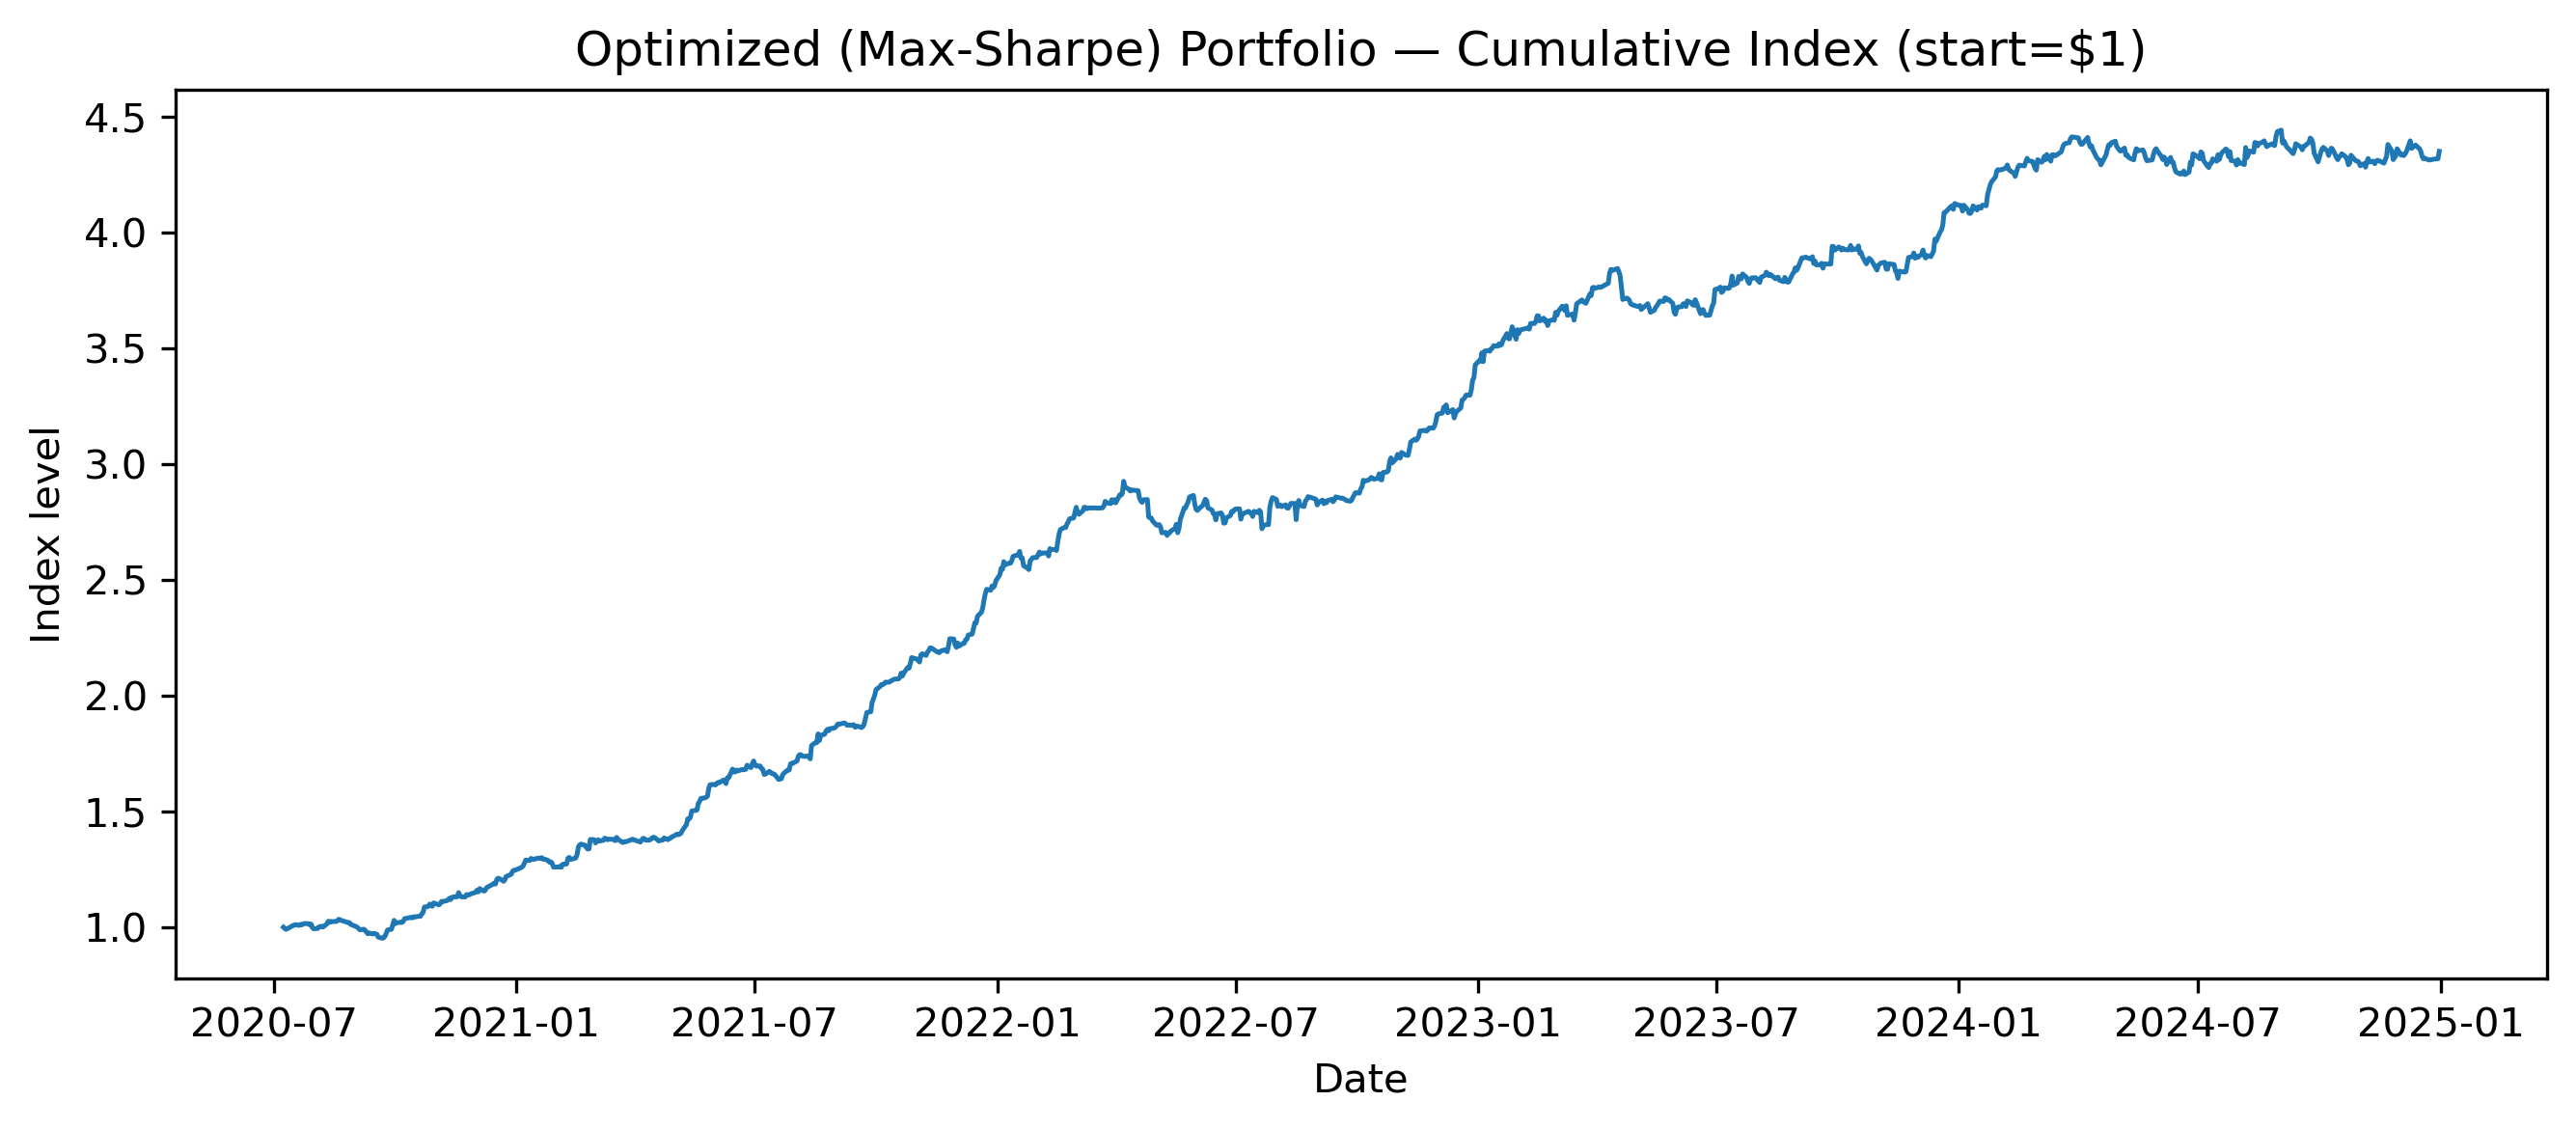

In [32]:
# $1 index
idx = (1 + rp).cumprod()
idx.name = "Portfolio index ($1 start)"

# $100k trajectory
notional = 100_000
equity_curve = notional * idx

fig = plt.figure(figsize=(9,4), dpi=300)
plt.plot(idx.index, idx.values, linewidth=1.2)
plt.title("Optimized (Max‑Sharpe) Portfolio — Cumulative Index (start=$1)")
plt.xlabel("Date"); plt.ylabel("Index level")
plt.tight_layout(); plt.show()

#### Comparison to Equal-Weigth Portfolio

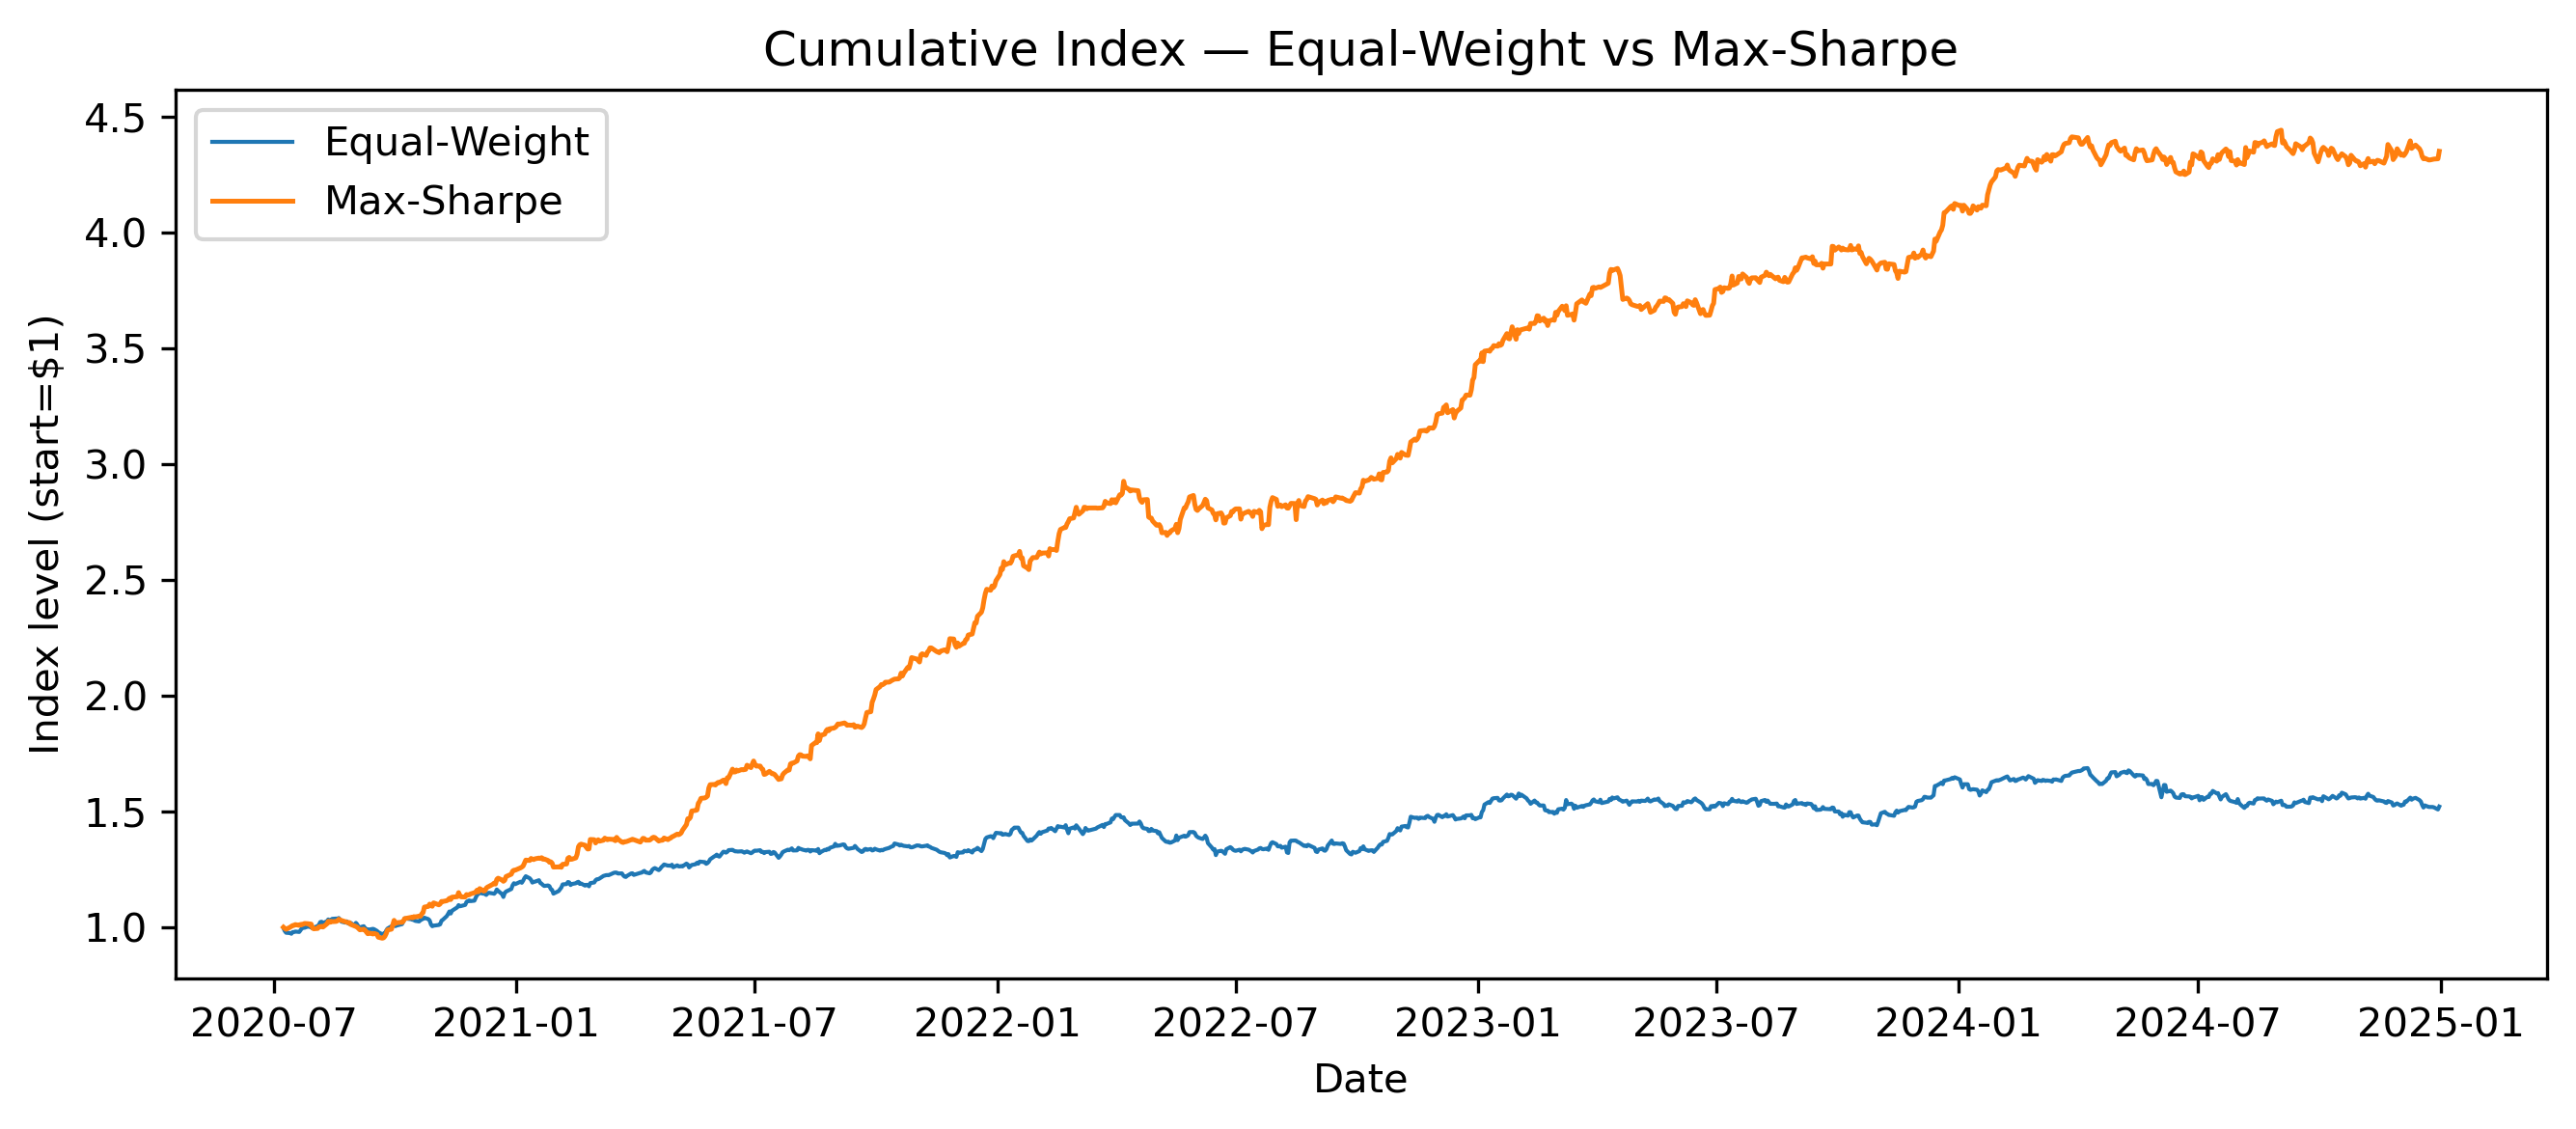

In [33]:
ew = R.mean(axis=1)                      # daily equal‑weight simple return
ew_idx = (1 + ew).cumprod()

fig = plt.figure(figsize=(9,4), dpi=300)
plt.plot(ew_idx.index, ew_idx, label="Equal‑Weight", linewidth=1.0)
plt.plot(idx.index, idx, label="Max‑Sharpe", linewidth=1.2)
plt.title("Cumulative Index — Equal‑Weight vs Max‑Sharpe")
plt.xlabel("Date"); plt.ylabel("Index level (start=$1)")
plt.legend(); plt.tight_layout(); plt.show()

### ESG-constrained portfolio

#### ESG-constrained log-return matrix

In [34]:
# Pivot prices to wide format
esg_price_matrix = esg_portfolio.pivot(index='Date', columns='Ticker', values='PX_LAST')

# Sort by date
esg_price_matrix = esg_price_matrix.sort_index()

# Force numeric types (fixes the error)
esg_price_matrix = esg_price_matrix.apply(pd.to_numeric, errors='coerce')

# Calculate log returns
esg_returns_matrix = np.log(esg_price_matrix / esg_price_matrix.shift(1))

esg_returns_matrix.head()

Ticker      AC* MM Equity  AGUA* MM Equity  ALPEKA MM Equity  \
Date                                                           
2020-07-07            NaN              NaN               NaN   
2020-07-08      -0.000961         0.006344          0.002838   
2020-07-09       0.001634        -0.062801         -0.000567   
2020-07-10      -0.007035        -0.027305          0.002266   
2020-07-13      -0.024277        -0.013061         -0.004538   

Ticker      ALSEA* MM Equity  AMXB MM Equity  ASURB MM Equity  \
Date                                                            
2020-07-07               NaN             NaN              NaN   
2020-07-08         -0.019914       -0.012867        -0.014611   
2020-07-09         -0.029734       -0.035888        -0.046617   
2020-07-10         -0.020479       -0.000746        -0.011190   
2020-07-13         -0.015289        0.000746        -0.017259   

Ticker      AXTELCPO MM Equity  BBAJIOO MM Equity  BIMBOA MM Equity  \
Date                                                                  
2020-07-07                 NaN                NaN               NaN   
2020-07-08            0.027129          -0.025048         -0.027708   
2020-07-09           -0.012240          -0.027354         -0.028230   
2020-07-10            0.002460          -0.018472          0.003739   
2020-07-13           -0.002460          -0.034486         -0.013690   

Ticker      BOLSAA MM Equity  ...  ORBIA* MM Equity  PE&OLES* MM Equity  \
Date                          ...                                         
2020-07-07               NaN  ...               NaN                 NaN   
2020-07-08         -0.032015  ...          0.018681           -0.022442   
2020-07-09         -0.008574  ...         -0.055920            0.039064   
2020-07-10         -0.013590  ...         -0.023767           -0.016495   
2020-07-13          0.003297  ...          0.009208           -0.002889   

Ticker      RA MM Equity  STORAGE MM Equity  TRAXIONA MM Equity  \
Date                                                              
2020-07-07           NaN                NaN                 NaN   
2020-07-08     -0.033408                0.0           -0.015168   
2020-07-09     -0.002863                0.0            0.017316   
2020-07-10     -0.000337                0.0           -0.004301   
2020-07-13     -0.039754                0.0            0.033207   

Ticker      VESTA* MM Equity  VINTE* MM Equity  VITROA MM Equity  \
Date                                                               
2020-07-07               NaN               NaN               NaN   
2020-07-08          0.003519          0.000000         -0.007830   
2020-07-09         -0.008230         -0.000361          0.000000   
2020-07-10         -0.010384          0.000361         -0.013187   
2020-07-13         -0.011096         -0.017841         -0.000885   

Ticker      VOLARA MM Equity  WALMEX* MM Equity  
Date                                             
2020-07-07               NaN                NaN  
2020-07-08          0.014389          -0.011534  
2020-07-09         -0.036803          -0.002723  
2020-07-10         -0.012281          -0.002548  
2020-07-13         -0.022312          -0.018204  

[5 rows x 44 columns]

#### Prep return ESG data (simple returns)

In [35]:
# Start from DAILY LOG returns matrix for the ESG universe
Rlog_esg = esg_returns_matrix.copy()

# Drop empty assets; keep only common dates (no missing values)
Rlog_esg = Rlog_esg.dropna(how='all', axis=1)
Rlog_esg = Rlog_esg.dropna(how='any', axis=0)

# Convert LOG returns -> SIMPLE returns
R_esg = np.exp(Rlog_esg) - 1.0

#### Estimate mu and Sigma

In [36]:
mu_esg_d = R_esg.mean()
Sigma_esg_d = R_esg.cov()

mu_esg_a = mu_esg_d * TRADING_DAYS
Sigma_esg_a = Sigma_esg_d * TRADING_DAYS

#### Optimized weights

In [37]:
w_esg, res_esg = solve_max_sharpe(R_esg, rf_daily=RF_DAILY, allow_short=False)
w_esg.sort_values(ascending=False).head(10)

Ticker
EDUCA18 MM Equity     0.271878
FIHO12 MM Equity      0.151937
BBAJIOO MM Equity     0.109860
LIVEPOL1 MM Equity    0.099805
GCC* MM Equity        0.070549
GENTERA* MM Equity    0.069012
GAPB MM Equity        0.067603
AC* MM Equity         0.038383
GMEXICOB MM Equity    0.036827
HERDEZ* MM Equity     0.031555
Name: weight, dtype: float64

#### ESG-constrained portfolio stats

In [38]:
# ESG-constrained portfolio stats (ARITHMETIC)
# Uses existing: R_esg (simple daily), w_esg, TRADING_DAYS, RF_ANNUAL

rp_esg = R_esg @ w_esg

ann_ret_esg = rp_esg.mean() * TRADING_DAYS          # arithmetic mean
ann_vol_esg = rp_esg.std() * np.sqrt(TRADING_DAYS)
ann_sr_esg  = (ann_ret_esg - RF_ANNUAL) / ann_vol_esg

print(f"ESG assets used: {R_esg.shape[1]}")
print(f"Annualized return (arith): {ann_ret_esg: .2%}")
print(f"Annualized vol:            {ann_vol_esg: .2%}")
print(f"Sharpe (annual):           {ann_sr_esg: .2f}")

ESG assets used: 44
Annualized return (arith):  19.96%
Annualized vol:             11.84%
Sharpe (annual):            1.03


#### Efficient frontier - ESG-constrained portfolio

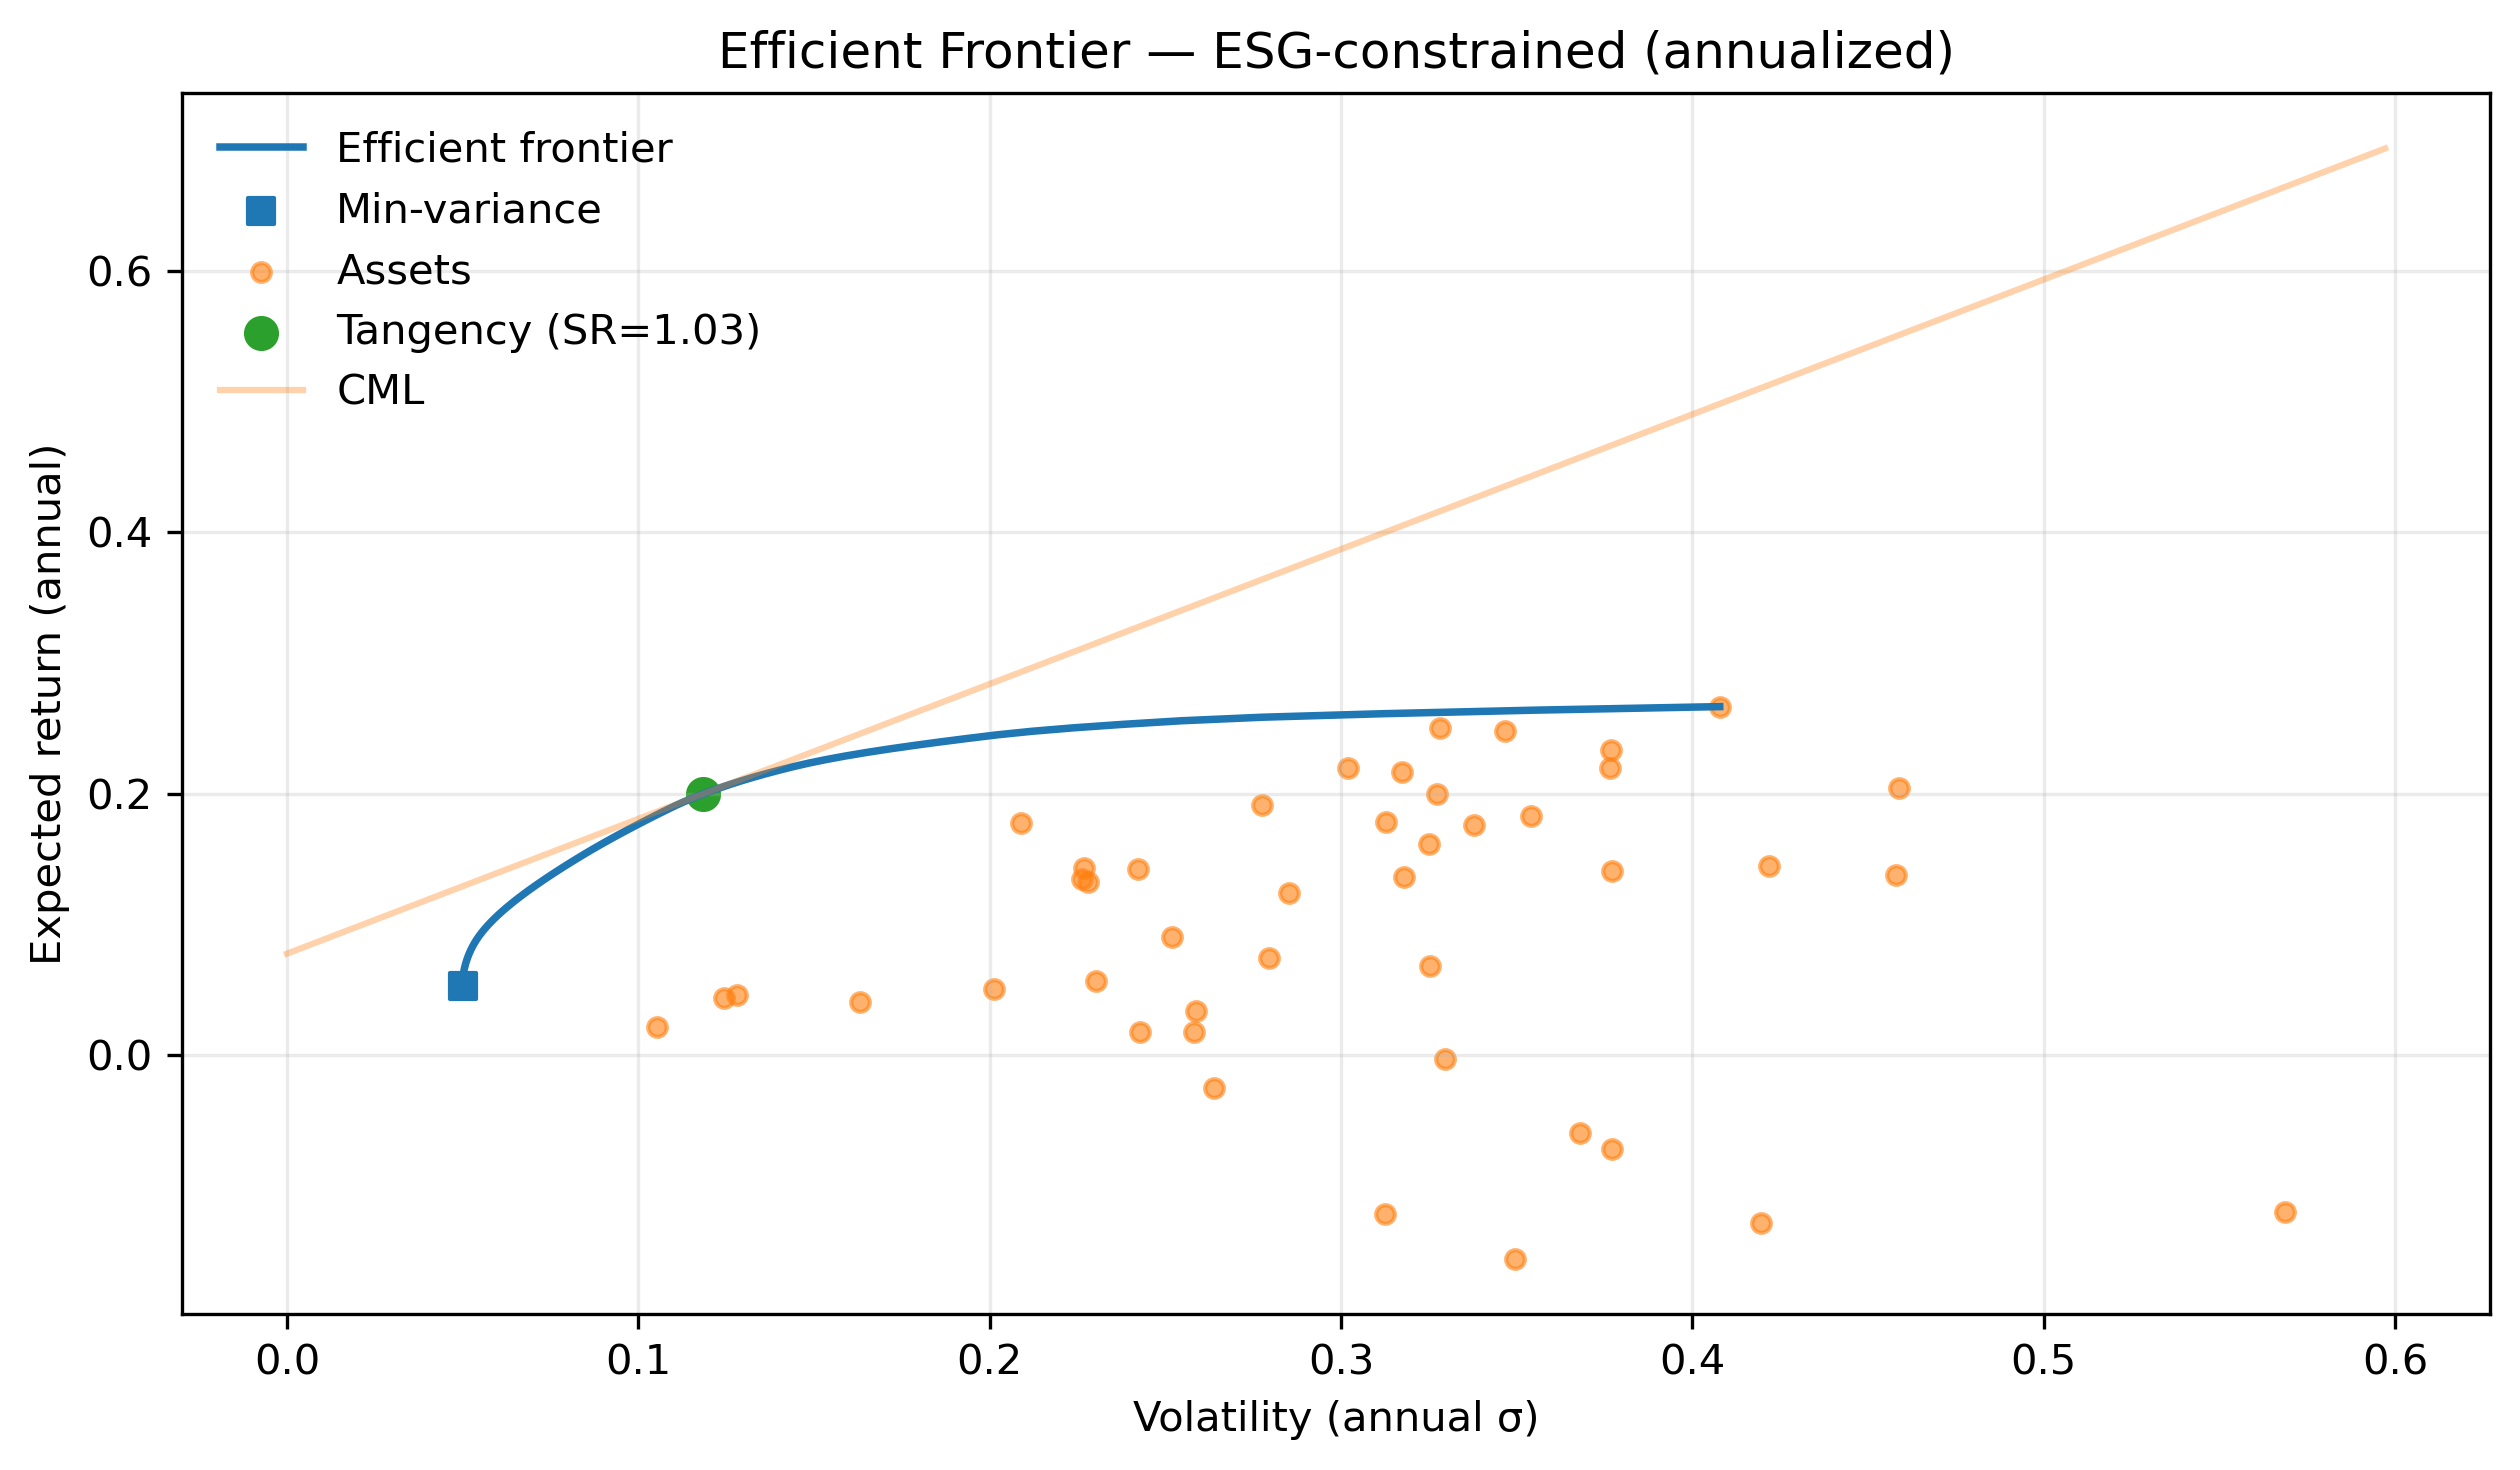

In [39]:
mu  = mu_esg_a.values
cov = Sigma_esg_a.values
n   = len(mu)

def var_obj(w): 
    return w @ cov @ w

def neg_sharpe_obj(w):
    v = np.sqrt(w @ cov @ w)
    if v <= 0: 
        return 1e9
    return - (mu @ w - RF_ANNUAL) / v

cons_sum = {'type':'eq','fun':lambda w: np.sum(w) - 1}
bnds = [(0.0, 1.0)] * n
w0 = np.full(n, 1.0/n)

# Min-variance
res_mv = minimize(var_obj, w0, method='SLSQP', bounds=bnds, constraints=[cons_sum],
                  options={'maxiter':8000,'ftol':1e-12})
w_mv   = res_mv.x
ret_mv = float(mu @ w_mv)
vol_mv = float(np.sqrt(w_mv @ cov @ w_mv))

# Frontier sweep (upper branch)
eps = 1e-6
tmin = ret_mv + eps
tmax = float(mu.max()) - eps
tgrid = np.linspace(tmin, tmax, 80) if tmax > tmin else np.array([ret_mv])

vols, rets = [], []
w_start = w_mv.copy()
for tr in tgrid:
    cons = [cons_sum, {'type':'eq','fun':lambda w, tr=tr: mu @ w - tr}]
    res = minimize(var_obj, w_start, method='SLSQP', bounds=bnds, constraints=cons,
                   options={'maxiter':8000,'ftol':1e-12})
    if not res.success:
        continue
    w_start = res.x
    rets.append(float(mu @ res.x))
    vols.append(float(np.sqrt(res.x @ cov @ res.x)))

vols = np.array(vols); rets = np.array(rets)

# Tangency + CML
res_tan = minimize(neg_sharpe_obj, w0, method='SLSQP', bounds=bnds, constraints=[cons_sum],
                   options={'maxiter':8000,'ftol':1e-12})
w_tan = res_tan.x
r_tan = float(mu @ w_tan)
v_tan = float(np.sqrt(w_tan @ cov @ w_tan))
sr_tan = (r_tan - RF_ANNUAL) / v_tan

# Assets cloud
assets_vol = np.sqrt(np.diag(cov))
assets_ret = mu

# Plot
fig, ax = plt.subplots(figsize=(8.5, 5), dpi=300)
ax.plot(vols, rets, lw=1.8, label="Efficient frontier")
ax.scatter([vol_mv], [ret_mv], s=40, marker="s", label="Min-variance")
ax.scatter(assets_vol, assets_ret, s=20, alpha=0.6, label="Assets")
ax.scatter([v_tan], [r_tan], s=55, label=f"Tangency (SR={sr_tan:.2f})")

x = np.linspace(0, max(vols.max(), assets_vol.max())*1.05, 60)
ax.plot(x, RF_ANNUAL + ((r_tan - RF_ANNUAL)/v_tan) * x, alpha=0.35, label="CML")

ax.set_title("Efficient Frontier — ESG-constrained (annualized)")
ax.set_xlabel("Volatility (annual σ)")
ax.set_ylabel("Expected return (annual)")
ax.grid(True, alpha=0.25)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

#### $1 cumulative index

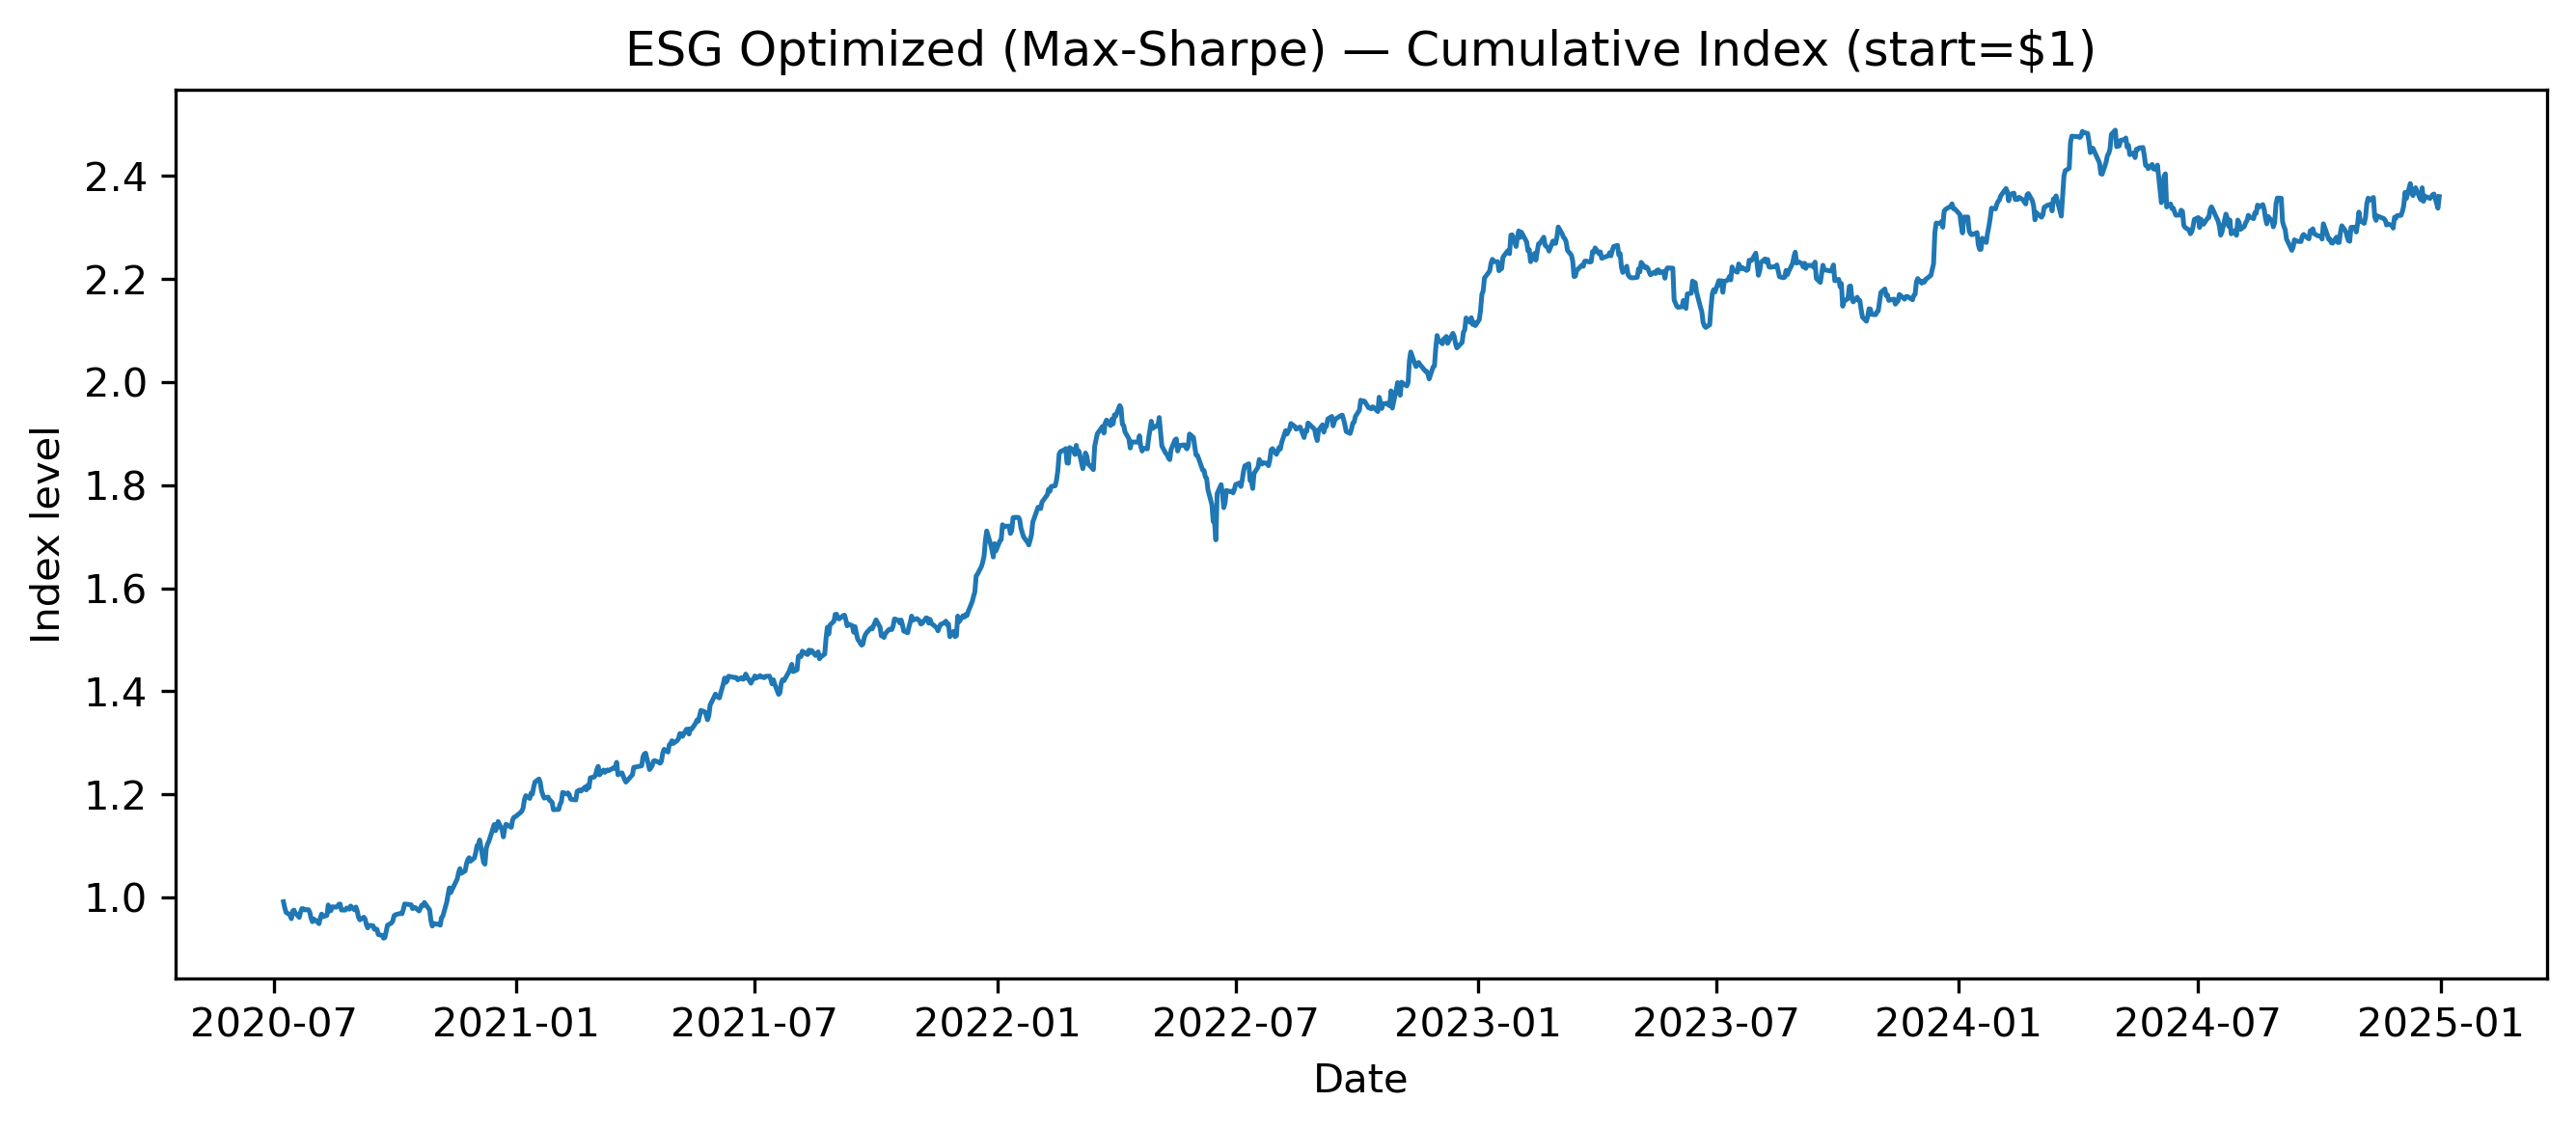

In [40]:
idx_esg = (1 + rp_esg).cumprod()
idx_esg.name = "ESG Max‑Sharpe — Index (start=$1)"

notional = 100_000
equity_curve_esg = notional * idx_esg 

fig = plt.figure(figsize=(9,4), dpi=300)
plt.plot(idx_esg.index, idx_esg.values, linewidth=1.2)
plt.title("ESG Optimized (Max‑Sharpe) — Cumulative Index (start=$1)")
plt.xlabel("Date"); plt.ylabel("Index level")
plt.tight_layout(); plt.show()


#### Comparison to ESG Equal-Weigth Portfolio

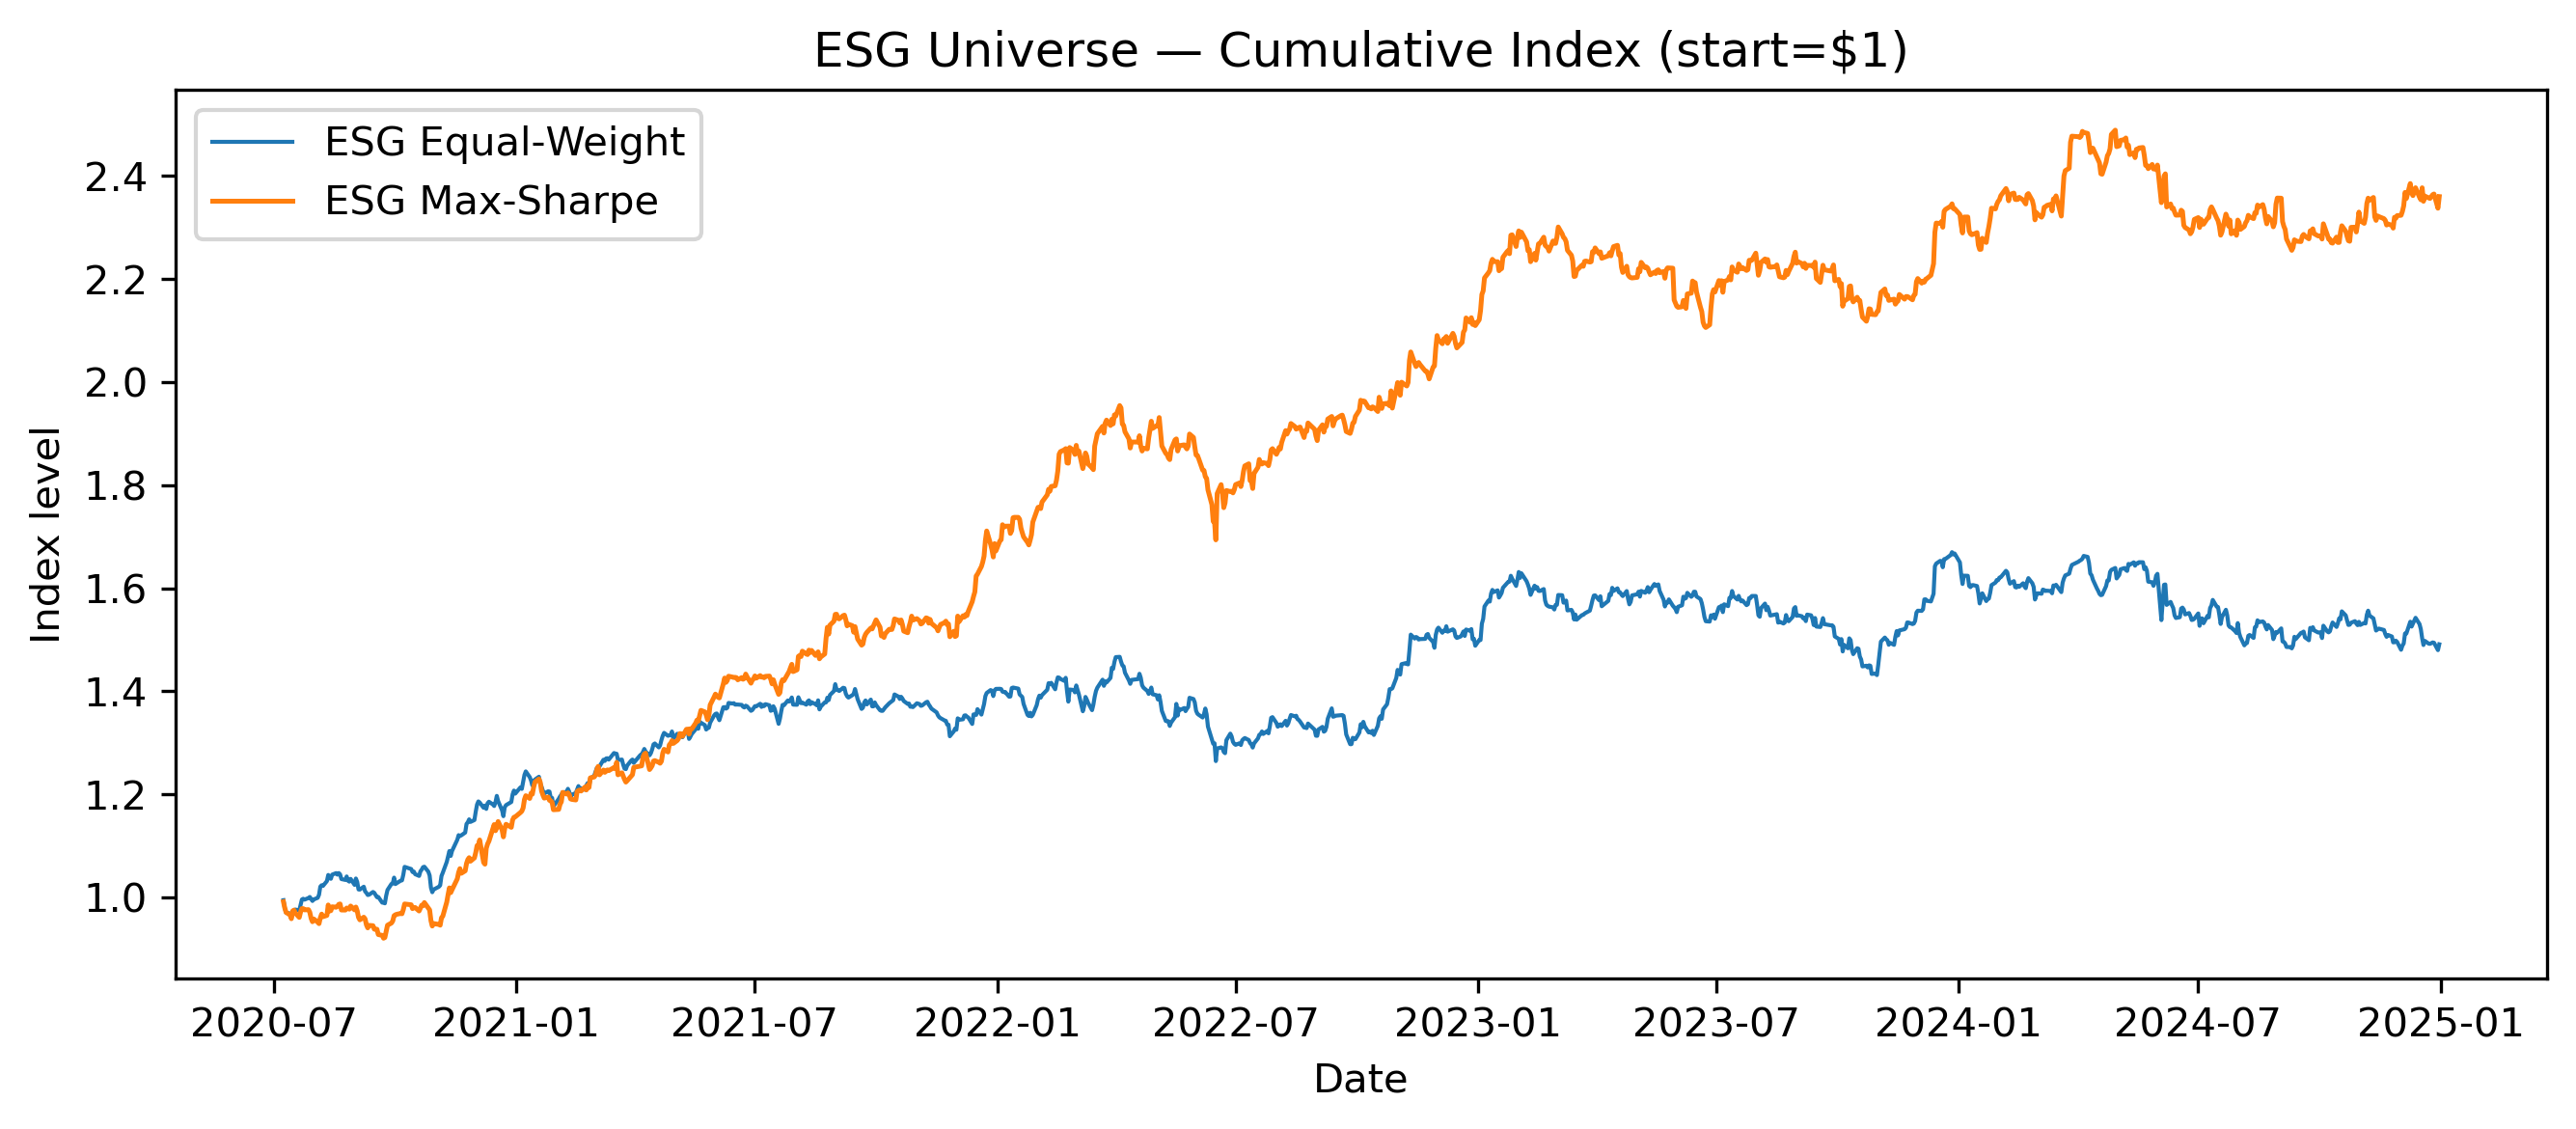

In [41]:
ew_esg = R_esg.mean(axis=1)                 # daily simple return, equal‑weight
ew_idx_esg = (1 + ew_esg).cumprod()

fig = plt.figure(figsize=(9,4), dpi=300)
plt.plot(ew_idx_esg.index, ew_idx_esg, label="ESG Equal‑Weight", linewidth=1.0)
plt.plot(idx_esg.index, idx_esg, label="ESG Max‑Sharpe", linewidth=1.2)
plt.title("ESG Universe — Cumulative Index (start=$1)")
plt.xlabel("Date"); plt.ylabel("Index level")
plt.legend(); plt.tight_layout(); plt.show()

### Efficient Frontier Comparison - ESG-constrained and Unconstrained portfolios

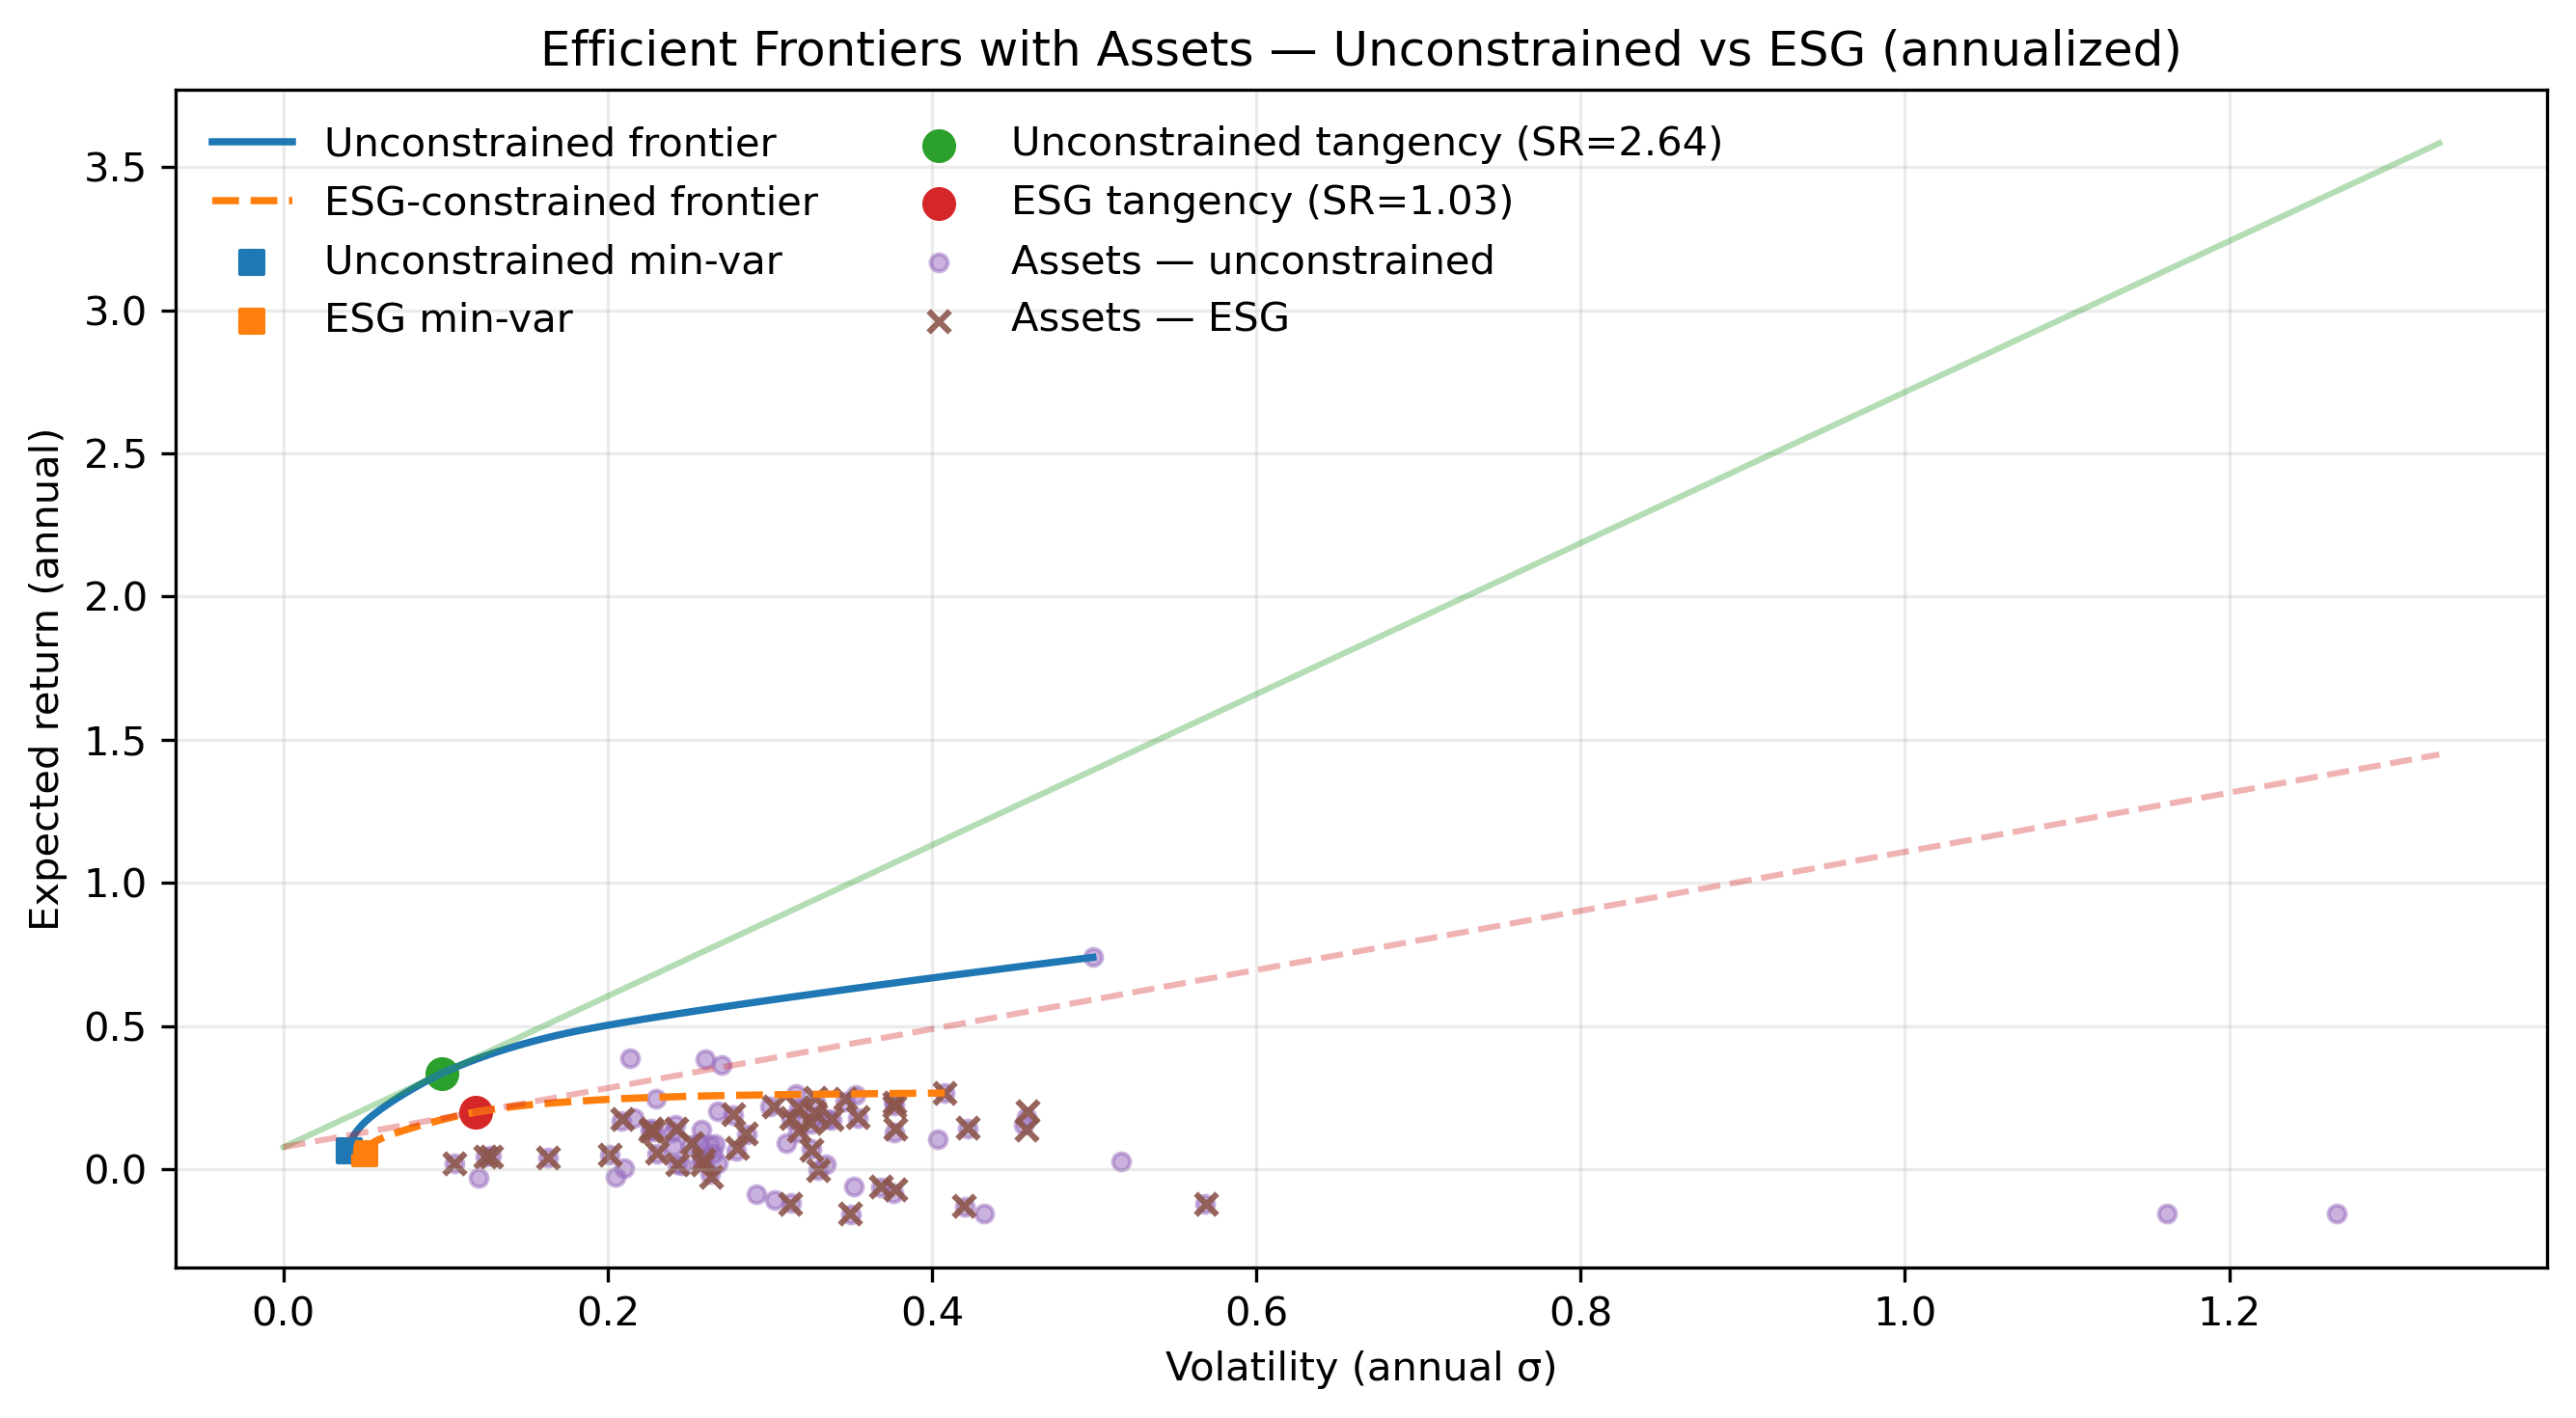

In [42]:
# Consistent combined plot: Unconstrained vs ESG (annualized)
ALLOW_SHORT = False

def efficient_frontier_from_moments(mu, cov, points=80, allow_short=False):
    """Upper (efficient) branch only, using given ANNUAL μ, Σ (no re-estimation)."""
    n = len(mu)
    def var_obj(w): return w @ cov @ w
    cons_sum = {'type':'eq','fun':lambda w: np.sum(w) - 1}
    bnds = None if allow_short else [(0.0, 1.0)] * n
    w0 = np.full(n, 1.0/n)

    # minimum variance
    res_mv = minimize(var_obj, w0, method='SLSQP', bounds=bnds, constraints=[cons_sum],
                      options={'maxiter':8000,'ftol':1e-12})
    w_mv   = res_mv.x
    ret_mv = float(mu @ w_mv)
    vol_mv = float(np.sqrt(w_mv @ cov @ w_mv))

    # sweep target returns (upper branch)
    eps = 1e-6
    tmin = ret_mv + eps
    tmax = float(mu.max()) - eps
    tgrid = np.linspace(tmin, tmax, points) if tmax > tmin else np.array([ret_mv])

    vols, rets = [], []
    w_start = w_mv.copy()
    for tr in tgrid:
        cons = [cons_sum, {'type':'eq','fun':lambda w, tr=tr: mu @ w - tr}]
        res  = minimize(var_obj, w_start, method='SLSQP', bounds=bnds, constraints=cons,
                        options={'maxiter':8000,'ftol':1e-12})
        if not res.success:
            continue
        w_start = res.x
        rets.append(float(mu @ res.x))
        vols.append(float(np.sqrt(res.x @ cov @ res.x)))

    return np.array(vols), np.array(rets), (w_mv, vol_mv, ret_mv)

def tangency_from_moments(mu, cov, rf, allow_short=False):
    """Max-Sharpe from ANNUAL μ, Σ and rf."""
    n = len(mu)
    def neg_sr(w):
        v = np.sqrt(w @ cov @ w)
        if v <= 0: return 1e9
        return - (mu @ w - rf) / v
    cons_sum = {'type':'eq','fun':lambda w: np.sum(w) - 1}
    bnds = None if allow_short else [(0.0, 1.0)] * n
    w0 = np.full(n, 1.0/n)
    res = minimize(neg_sr, w0, method='SLSQP', bounds=bnds, constraints=[cons_sum],
                   options={'maxiter':8000,'ftol':1e-12})
    w = res.x
    r = float(mu @ w)
    v = float(np.sqrt(w @ cov @ w))
    sr = (r - rf) / v
    return w, v, r, sr

# moments (annual)
mu_all  = mu_annual.values
cov_all = Sigma_annual.values
mu_esg  = mu_esg_a.values
cov_esg = Sigma_esg_a.values

# ---- build both frontiers from moments ----
vol_all, ret_all, mv_all = efficient_frontier_from_moments(mu_all,  cov_all, points=80, allow_short=ALLOW_SHORT)
vol_esg, ret_esg, mv_esg = efficient_frontier_from_moments(mu_esg,  cov_esg, points=80, allow_short=ALLOW_SHORT)

# tangency points (same method as individual plots)
w_tan_all, v_tan_all, r_tan_all, sr_all = tangency_from_moments(mu_all, cov_all, RF_ANNUAL, allow_short=ALLOW_SHORT)
w_tan_esg, v_tan_esg, r_tan_esg, sr_esg = tangency_from_moments(mu_esg, cov_esg, RF_ANNUAL, allow_short=ALLOW_SHORT)

# per-asset points from mu, sigma (no re-estimation)
assets_all = pd.DataFrame({"vol": np.sqrt(np.diag(cov_all)), "ret": mu_all})
assets_esg = pd.DataFrame({"vol": np.sqrt(np.diag(cov_esg)), "ret": mu_esg})

# plot
fig, ax = plt.subplots(figsize=(9,5), dpi=300)
ax.plot(vol_all, ret_all, label='Unconstrained frontier', lw=1.8)
ax.plot(vol_esg, ret_esg, label='ESG-constrained frontier', lw=1.8, ls='--')

ax.scatter([mv_all[1]],[mv_all[2]], s=35, marker='s', label='Unconstrained min-var')
ax.scatter([mv_esg[1]],[mv_esg[2]], s=35, marker='s', label='ESG min-var')

ax.scatter([v_tan_all],[r_tan_all], s=55, label=f'Unconstrained tangency (SR={sr_all:.2f})')
ax.scatter([v_tan_esg],[r_tan_esg], s=55, label=f'ESG tangency (SR={sr_esg:.2f})')

x = np.linspace(0, max(vol_all.max(), vol_esg.max(), assets_all["vol"].max(), assets_esg["vol"].max())*1.05, 60)
ax.plot(x, RF_ANNUAL + (r_tan_all - RF_ANNUAL)/v_tan_all * x, alpha=0.35)
ax.plot(x, RF_ANNUAL + (r_tan_esg - RF_ANNUAL)/v_tan_esg * x, alpha=0.35, ls='--')

ax.scatter(assets_all["vol"], assets_all["ret"], s=18, alpha=0.5, label='Assets — unconstrained')
ax.scatter(assets_esg["vol"], assets_esg["ret"], s=28, alpha=0.9, marker='x', label='Assets — ESG')

ax.set_title("Efficient Frontiers with Assets — Unconstrained vs ESG (annualized)")
ax.set_xlabel("Volatility (annual σ)")
ax.set_ylabel("Expected return (annual)")
ax.grid(True, alpha=0.25)
ax.legend(frameon=False, ncol=2)
plt.tight_layout(); plt.show()


### $1 Cumulative Index Comparison - ESG vs Unconstrained

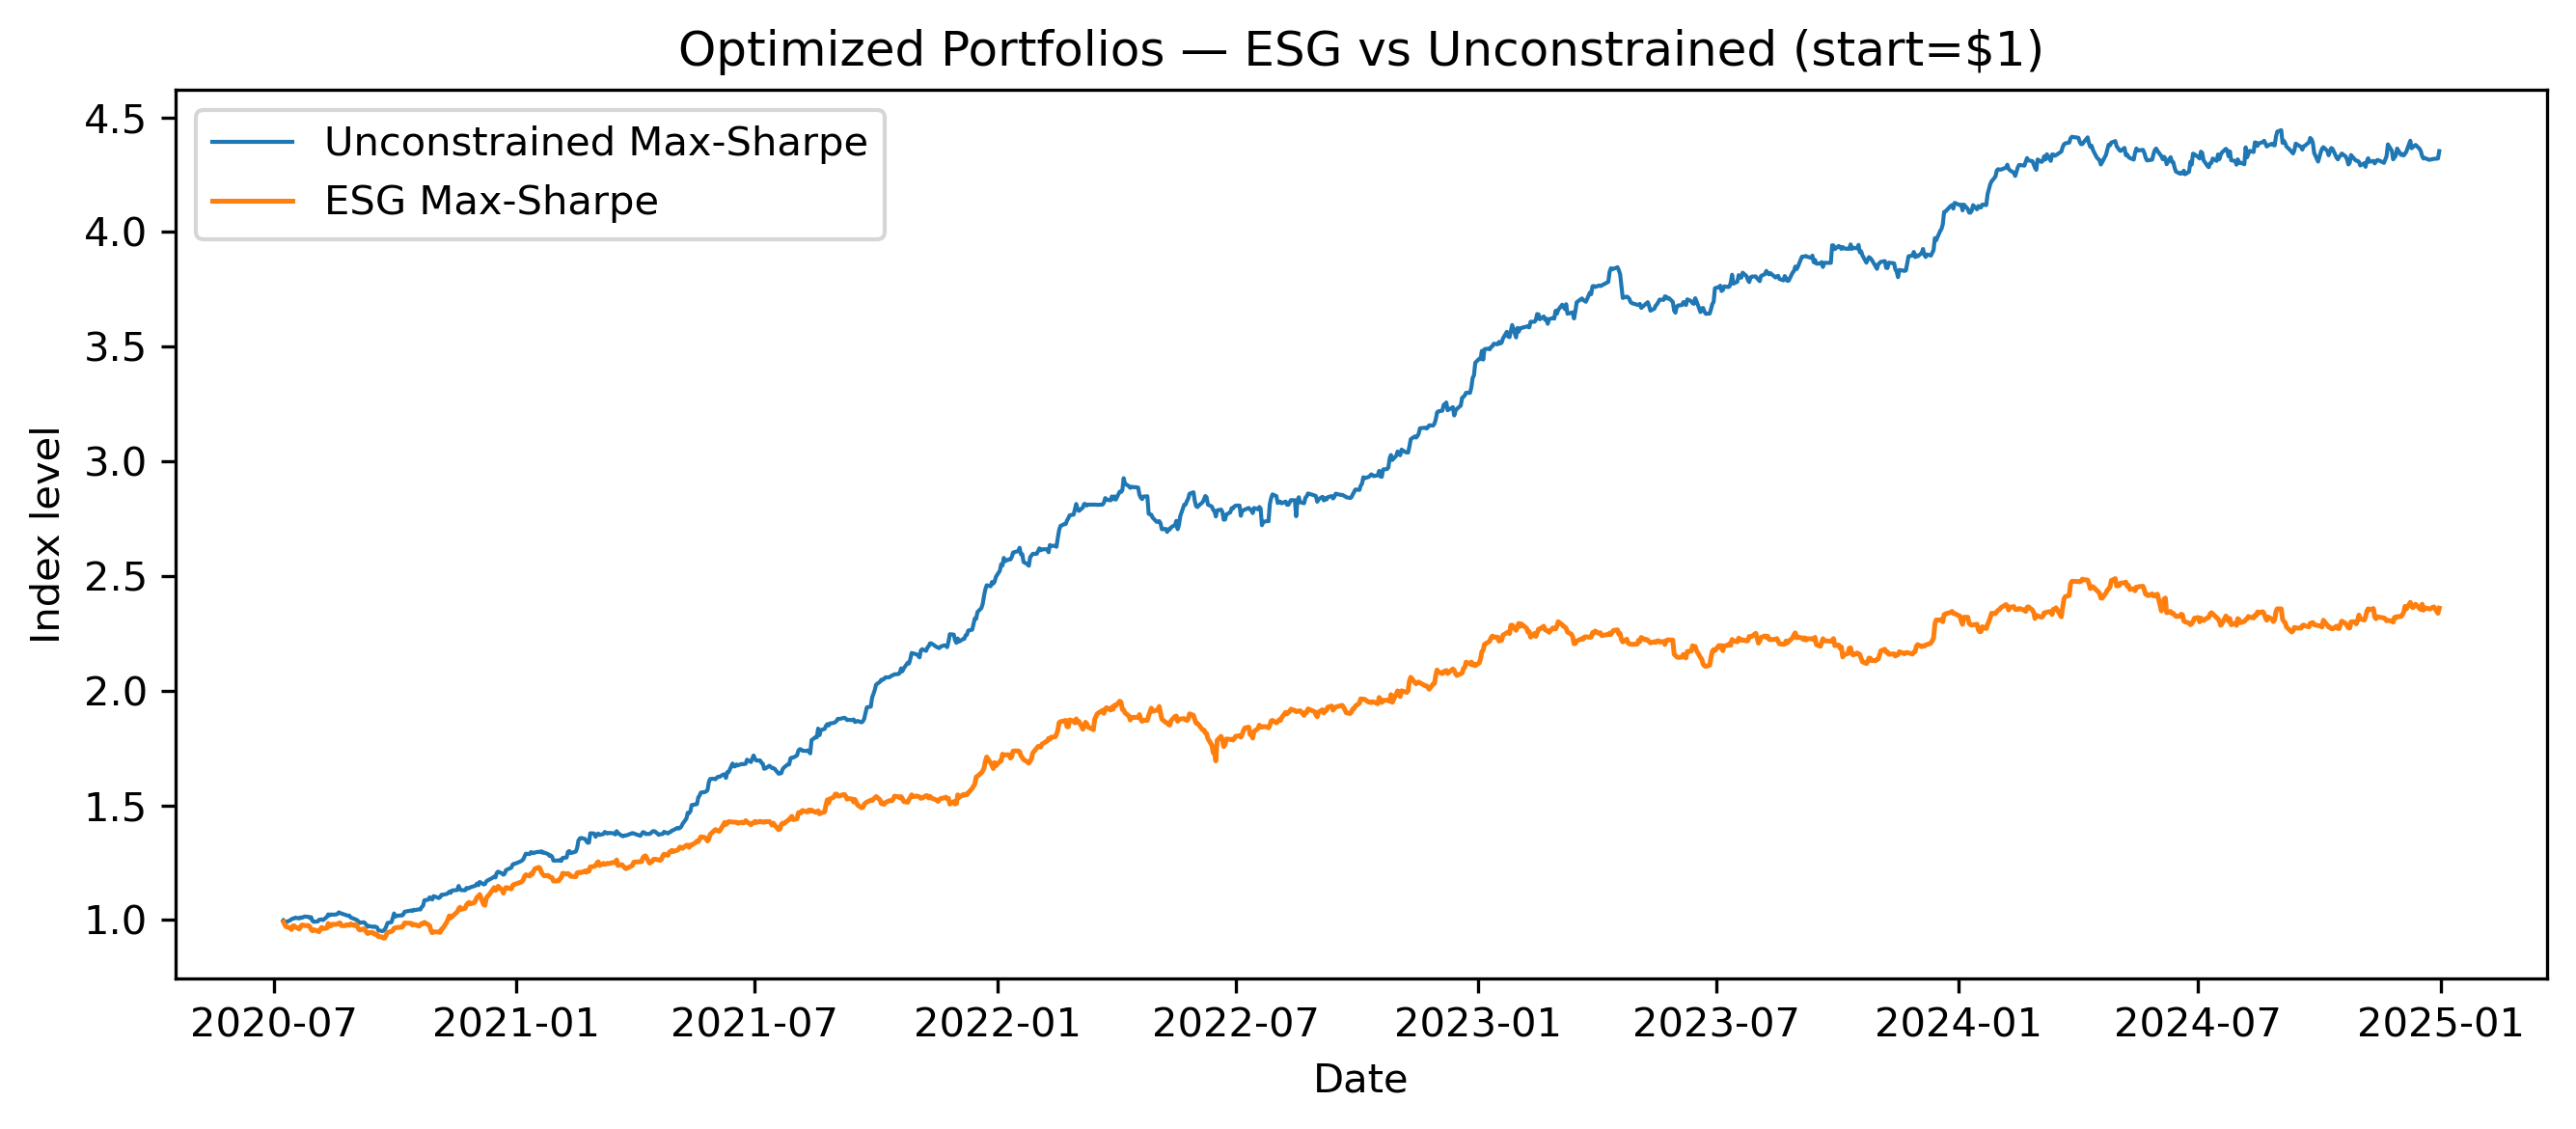

In [43]:
try:
    _ = idx  # from previous unconstrained optimization cell
    fig = plt.figure(figsize=(9,4), dpi=300)
    plt.plot(idx.index, idx, label="Unconstrained Max‑Sharpe", linewidth=1.0)
    plt.plot(idx_esg.index, idx_esg, label="ESG Max‑Sharpe", linewidth=1.2)
    plt.title("Optimized Portfolios — ESG vs Unconstrained (start=$1)")
    plt.xlabel("Date"); plt.ylabel("Index level")
    plt.legend(); plt.tight_layout(); plt.show()
except NameError:
    pass

In [44]:
# helpers

def _annualize(ret_d, vol_d, rf_annual):
    mu_ann  = 252 * ret_d
    vol_ann = np.sqrt(252) * vol_d
    sharpe  = (mu_ann - rf_annual) / vol_ann if vol_ann > 0 else np.nan
    return mu_ann, vol_ann, sharpe

def _solve_target_return_mv(R_simple, R_target_d, allow_short=False):
    """Markowitz min-variance for a given daily target return (simple returns)."""
    X = R_simple.copy()
    mu_d = X.mean().to_numpy()
    Sigma_d = X.cov().to_numpy() + 1e-8 * np.eye(X.shape[1])
    n = X.shape[1]

    def variance(w):
        return w @ Sigma_d @ w

    cons = [
        {'type': 'eq',  'fun': lambda w: np.sum(w) - 1.0},
        # use inequality: portfolio return >= target (more numerically stable)
        {'type': 'ineq','fun': lambda w, mu=mu_d, Rt=R_target_d: w @ mu - Rt}
    ]
    bounds = ([-1, 1] if allow_short else [0, 1],) * n
    w0 = np.full(n, 1.0 / n)

    res = minimize(
        variance, w0, method='SLSQP',
        bounds=bounds, constraints=cons,
        options={'maxiter': 10_000, 'ftol': 1e-12, 'disp': False}
    )
    return res, mu_d, Sigma_d


def _solve_gmv(R_simple, allow_short=False):
    """Global minimum-variance (daily simple returns)."""
    X = R_simple.copy()
    Sigma_d = X.cov().to_numpy() + 1e-8 * np.eye(X.shape[1])
    n = X.shape[1]
    def variance(w): return w @ Sigma_d @ w
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    bounds = ([-1, 1] if allow_short else [0, 1],) * n
    w0 = np.full(n, 1.0 / n)
    res = minimize(
        variance, w0, method='SLSQP',
        bounds=bounds, constraints=cons,
        options={'maxiter': 10_000, 'ftol': 1e-12, 'disp': False}
    )
    return res, Sigma_d

def build_frontier_table_mv(R_simple, rf_annual=0.0775, K=10, allow_short=False):
    """
    Returns a table of K feasible frontier points (Markowitz target-return),
    reporting annualized return, annualized volatility, and Sharpe.
    """
    # GMV for lower bound on target return
    res_gmv, Sigma_d = _solve_gmv(R_simple, allow_short=allow_short)
    if not res_gmv.success:
        raise RuntimeError(f"GMV solver failed: {res_gmv.message}")
    w_gmv = res_gmv.x  # bounds already enforce feasibility
    w_gmv = w_gmv / w_gmv.sum()

    mu_d = R_simple.mean().to_numpy()
    ret_gmv_d = float(w_gmv @ mu_d)

    # Feasible target band (strict interior to avoid boundary stickiness)
    R_min_d = float(mu_d.min())
    R_max_d = float(mu_d.max())
    R_lower_d = max(ret_gmv_d, R_min_d) + 1e-8
    R_upper_d = R_max_d - 1e-8

    if not (R_upper_d > R_lower_d):
        raise RuntimeError("Target-return range is degenerate for MV frontier.")

    candidates = np.linspace(R_lower_d, R_upper_d, 60)

    rows = []
    for Rt in candidates:
        res, mu_d, Sigma_d = _solve_target_return_mv(R_simple, Rt, allow_short=allow_short)
        if not res.success:
            continue
        w = res.x
        w = w / w.sum()
        ret_d = float(w @ mu_d)
        vol_d = float(np.sqrt(w @ Sigma_d @ w))
        mu_ann, vol_ann, sharpe = _annualize(ret_d, vol_d, rf_annual)
        rows.append({
            'R_target_ann': 252 * Rt,     # requested target (annualized)
            'Ret_ann':      mu_ann,       # achieved (annualized)
            'Vol_ann':      vol_ann,
            'Sharpe':       sharpe
        })

    df = pd.DataFrame(rows)
    if df.empty:
        raise RuntimeError("No feasible MV frontier points found.")

    # Drop near-duplicates in achieved return (helps avoid repeats)
    df = df.sort_values('Ret_ann').drop_duplicates(subset=['Ret_ann'], keep='first').reset_index(drop=True)

    # Pick K evenly spaced points along achieved return
    if len(df) > K:
        idx = (np.linspace(0, len(df)-1, K)).round().astype(int)
        df = df.iloc[idx].reset_index(drop=True)
    return df


def compare_frontiers_mv(R_univ, R_esg, rf_annual=0.0775, K=10):
    """
    Builds MV frontier tables for Unconstrained and ESG, and aligns them
    by nearest achieved return; returns a single comparison table with deltas.
    """
    tbl_u = build_frontier_table_mv(R_univ, rf_annual=rf_annual, K=K)
    tbl_e = build_frontier_table_mv(R_esg,  rf_annual=rf_annual, K=K)

    out = []
    for _, r in tbl_u.iterrows():
        # align by achieved return (more robust than target)
        j = (tbl_e['Ret_ann'] - r['Ret_ann']).abs().idxmin()
        s = tbl_e.loc[j]
        row = {
            'R_target_ann':   r['R_target_ann'],
            'Ret_ann_univ':   r['Ret_ann'],
            'Vol_ann_univ':   r['Vol_ann'],
            'Sharpe_univ':    r['Sharpe'],
            'Ret_ann_esg':    s['Ret_ann'],
            'Vol_ann_esg':    s['Vol_ann'],
            'Sharpe_esg':     s['Sharpe'],
        }
        row['ΔVol (esg - univ)']    = row['Vol_ann_esg']  - row['Vol_ann_univ']
        row['ΔSharpe (esg - univ)'] = row['Sharpe_esg']   - row['Sharpe_univ']
        out.append(row)
    comp = pd.DataFrame(out).sort_values('R_target_ann').reset_index(drop=True)
    return comp


In [45]:
def _interp_frontier(tbl, ret_grid, rf_annual=0.0775):
    """Linear interp Vol_ann over Ret_ann; recompute Sharpe from (ret - rf)/vol."""
    x = tbl['Ret_ann'].to_numpy()
    y = tbl['Vol_ann'].to_numpy()
    idx = np.argsort(x)
    x, y = x[idx], y[idx]
    vol = np.interp(ret_grid, x, y)
    sharpe = (ret_grid - rf_annual) / vol
    return vol, sharpe

def compare_frontiers_mv_common(R_univ, R_esg, rf_annual=0.0775, K=10, K_dense=200):
    """
    Build dense MV frontiers for both universes, then compare on a COMMON
    return grid (Ret_ann) to avoid repeated max points.
    """
    # Build dense frontiers (your existing builder)
    tbl_u = build_frontier_table_mv(R_univ, rf_annual=rf_annual, K=K_dense)
    tbl_e = build_frontier_table_mv(R_esg,  rf_annual=rf_annual, K=K_dense)

    # Common achievable range
    lo = max(tbl_u['Ret_ann'].min(), tbl_e['Ret_ann'].min())
    hi = min(tbl_u['Ret_ann'].max(), tbl_e['Ret_ann'].max())
    if not (hi > lo):
        raise RuntimeError("No overlap in achievable returns between universes.")

    ret_grid = np.linspace(lo, hi, K)

    # Interpolate each frontier to the common grid
    vol_u, sharpe_u = _interp_frontier(tbl_u, ret_grid, rf_annual)
    vol_e, sharpe_e = _interp_frontier(tbl_e, ret_grid, rf_annual)

    comp = pd.DataFrame({
        'R_match_ann':   ret_grid,
        'Vol_ann_univ':  vol_u,
        'Sharpe_univ':   sharpe_u,
        'Vol_ann_esg':   vol_e,
        'Sharpe_esg':    sharpe_e
    })
    comp['ΔVol (esg - univ)']    = comp['Vol_ann_esg']  - comp['Vol_ann_univ']
    comp['ΔSharpe (esg - univ)'] = comp['Sharpe_esg']   - comp['Sharpe_univ']
    return comp

In [46]:
R_univ = R              # unconstrained universe
R_esg  = R_esg          # ESG-constrained universe 

rf_annual = 0.0775  # 7.75% p.a.
K = 10              # number of points to report

tbl_univ = build_frontier_table_mv(R_univ, rf_annual=rf_annual, K=K)
tbl_esg  = build_frontier_table_mv(R_esg,  rf_annual=rf_annual, K=K)
tbl_comp = compare_frontiers_mv(R_univ, R_esg, rf_annual=rf_annual, K=K)

# Inspect
print(tbl_univ.head())
print(tbl_esg.head())
print(tbl_comp)

   R_target_ann   Ret_ann   Vol_ann    Sharpe
0      0.065753  0.065795  0.040704 -0.287559
1      0.145790  0.145790  0.046984  1.453486
2      0.214393  0.214393  0.061116  2.239873
3      0.294430  0.294430  0.083828  2.587792
4      0.363033  0.363033  0.109085  2.617528
   R_target_ann   Ret_ann   Vol_ann    Sharpe
0      0.053234  0.053281  0.049996 -0.484423
1      0.078535  0.078535  0.052023  0.019890
2      0.100221  0.100221  0.057527  0.394965
3      0.125522  0.125522  0.068600  0.700024
4      0.147208  0.147208  0.080714  0.863644
   R_target_ann  Ret_ann_univ  Vol_ann_univ  Sharpe_univ  Ret_ann_esg  \
0      0.065753      0.065795      0.040704    -0.287559     0.053281   
1      0.145790      0.145790      0.046984     1.453486     0.147208   
2      0.214393      0.214393      0.061116     2.239873     0.219496   
3      0.294430      0.294430      0.083828     2.587792     0.266483   
4      0.363033      0.363033      0.109085     2.617528     0.266483   
5      0.4

In [47]:
tbl_e = build_frontier_table_mv(R_esg, K=10)
print("ESG frontier points:", len(tbl_e))
print(tbl_e[['R_target_ann','Ret_ann','Vol_ann']])

# You should see Ret_ann increasing (or at least varying), not constant.


ESG frontier points: 10
   R_target_ann   Ret_ann   Vol_ann
0      0.053234  0.053281  0.049996
1      0.078535  0.078535  0.052023
2      0.100221  0.100221  0.057527
3      0.125522  0.125522  0.068600
4      0.147208  0.147208  0.080714
5      0.172509  0.172509  0.097166
6      0.194195  0.194195  0.113432
7      0.219496  0.219496  0.142527
8      0.241183  0.241183  0.190878
9      0.266483  0.266483  0.407788


In [48]:
print("mu_esg range (annual):", (R_esg.mean().to_numpy().min()*252, R_esg.mean().to_numpy().max()*252))
print(compare_frontiers_mv(R_univ, R_esg, K=10).head(12))


mu_esg range (annual): (-0.15580389300790273, 0.26648589889684593)
   R_target_ann  Ret_ann_univ  Vol_ann_univ  Sharpe_univ  Ret_ann_esg  \
0      0.065753      0.065795      0.040704    -0.287559     0.053281   
1      0.145790      0.145790      0.046984     1.453486     0.147208   
2      0.214393      0.214393      0.061116     2.239873     0.219496   
3      0.294430      0.294430      0.083828     2.587792     0.266483   
4      0.363033      0.363033      0.109085     2.617528     0.266483   
5      0.443070      0.443070      0.151293     2.416303     0.266483   
6      0.511673      0.511673      0.208591     2.081454     0.266483   
7      0.591710      0.591710      0.301086     1.707850     0.266483   
8      0.660313      0.660313      0.389291     1.497114     0.266483   
9      0.740349      0.740349      0.499173     1.327895     0.266483   

   Vol_ann_esg  Sharpe_esg  ΔVol (esg - univ)  ΔSharpe (esg - univ)  
0     0.049996   -0.484423           0.009292             -

In [49]:
tbl_comp = compare_frontiers_mv_common(R_univ, R_esg, rf_annual=0.0775, K=10)
print(tbl_comp)

   R_match_ann  Vol_ann_univ  Sharpe_univ  Vol_ann_esg  Sharpe_esg  \
0     0.065795      0.040704    -0.287559     0.050486   -0.231838   
1     0.088094      0.041193     0.257181     0.053953    0.196358   
2     0.110393      0.042662     0.771000     0.061478    0.535035   
3     0.132691      0.045121     1.223186     0.072397    0.762342   
4     0.154990      0.048491     1.598024     0.085484    0.906489   
5     0.177289      0.052668     1.894675     0.100566    0.992267   
6     0.199587      0.057560     2.121041     0.118414    1.031024   
7     0.221886      0.063019     2.291140     0.146309    0.986856   
8     0.244185      0.068949     2.417507     0.199975    0.833528   
9     0.266483      0.075316     2.509200     0.407788    0.463435   

   ΔVol (esg - univ)  ΔSharpe (esg - univ)  
0           0.009783              0.055720  
1           0.012760             -0.060823  
2           0.018815             -0.235965  
3           0.027276             -0.460844  
4   

In [50]:
tbl_comp.to_csv("frontier_mv_common.csv", index=False)

## Mean-CVaR Model

### CVaR Optimization function

In [51]:
def opt_cvar_for_return(target_ret, mu_d, R_simple, alpha=0.95, allow_short=False, solver=cp.SCS):
    """
    Mean–CVaR (Rockafellar–Uryasev) portfolio for a target DAILY return.
    Inputs:
        target_ret : float (daily)
        mu_d       : 1D array-like of DAILY expected returns (len N)
        R_simple   : (T x N) matrix/DataFrame of DAILY simple returns
        alpha      : CVaR confidence (e.g., 0.95)
        allow_short: if True, -1<=w<=1; else w>=0
    Returns:
        cvar_val   : float (daily CVaR at alpha)
        ret_ach    : float (achieved daily expected return)
        w_opt      : np.ndarray of weights (len N)
    """
    R = np.asarray(R_simple)
    mu = np.asarray(mu_d).reshape(-1)
    T, N = R.shape

    w   = cp.Variable(N)
    VaR = cp.Variable()
    u   = cp.Variable(T)               # slack (excess losses)

    port_loss = -R @ w                 # losses = -returns
    CVaR = VaR + (1.0 / ((1 - alpha) * T)) * cp.sum(u)

    cons = [
        cp.sum(w) == 1,
        mu @ w >= target_ret,
        u >= 0,
        u >= port_loss - VaR
    ]
    if allow_short:
        cons += [w >= -1, w <= 1]
    else:
        cons += [w >= 0]

    prob = cp.Problem(cp.Minimize(CVaR), cons)
    prob.solve(solver=solver)
    return float(CVaR.value), float((mu @ w).value), np.array(w.value).reshape(-1)

### Unconstrained Portfolio

In [52]:
# Uses existing: R (daily simple returns), mu_daily (daily means)
ALPHA = 0.95
NPTS  = 20

def target_grid_from_mu(mu_d, npts=NPTS, eps=1e-6):
    tmin = float(np.min(mu_d)) + eps
    tmax = float(np.max(mu_d)) - eps
    return np.linspace(tmin, tmax, npts) if tmax > tmin else np.array([tmin])

tg_all = target_grid_from_mu(mu_daily.values, npts=NPTS)

cvar_all, ret_all, w_all = [], [], []
for tr in tg_all:
    c, r, w = opt_cvar_for_return(target_ret=tr, mu_d=mu_daily.values,
                                  R_simple=R, alpha=ALPHA, allow_short=False)
    cvar_all.append(c); ret_all.append(r); w_all.append(w)

# Store weights (index by achieved expected daily return)
weights_all_df = pd.DataFrame(w_all, columns=R.columns, index=np.round(ret_all, 6))
weights_all_df.index.name = "Expected Daily Return"

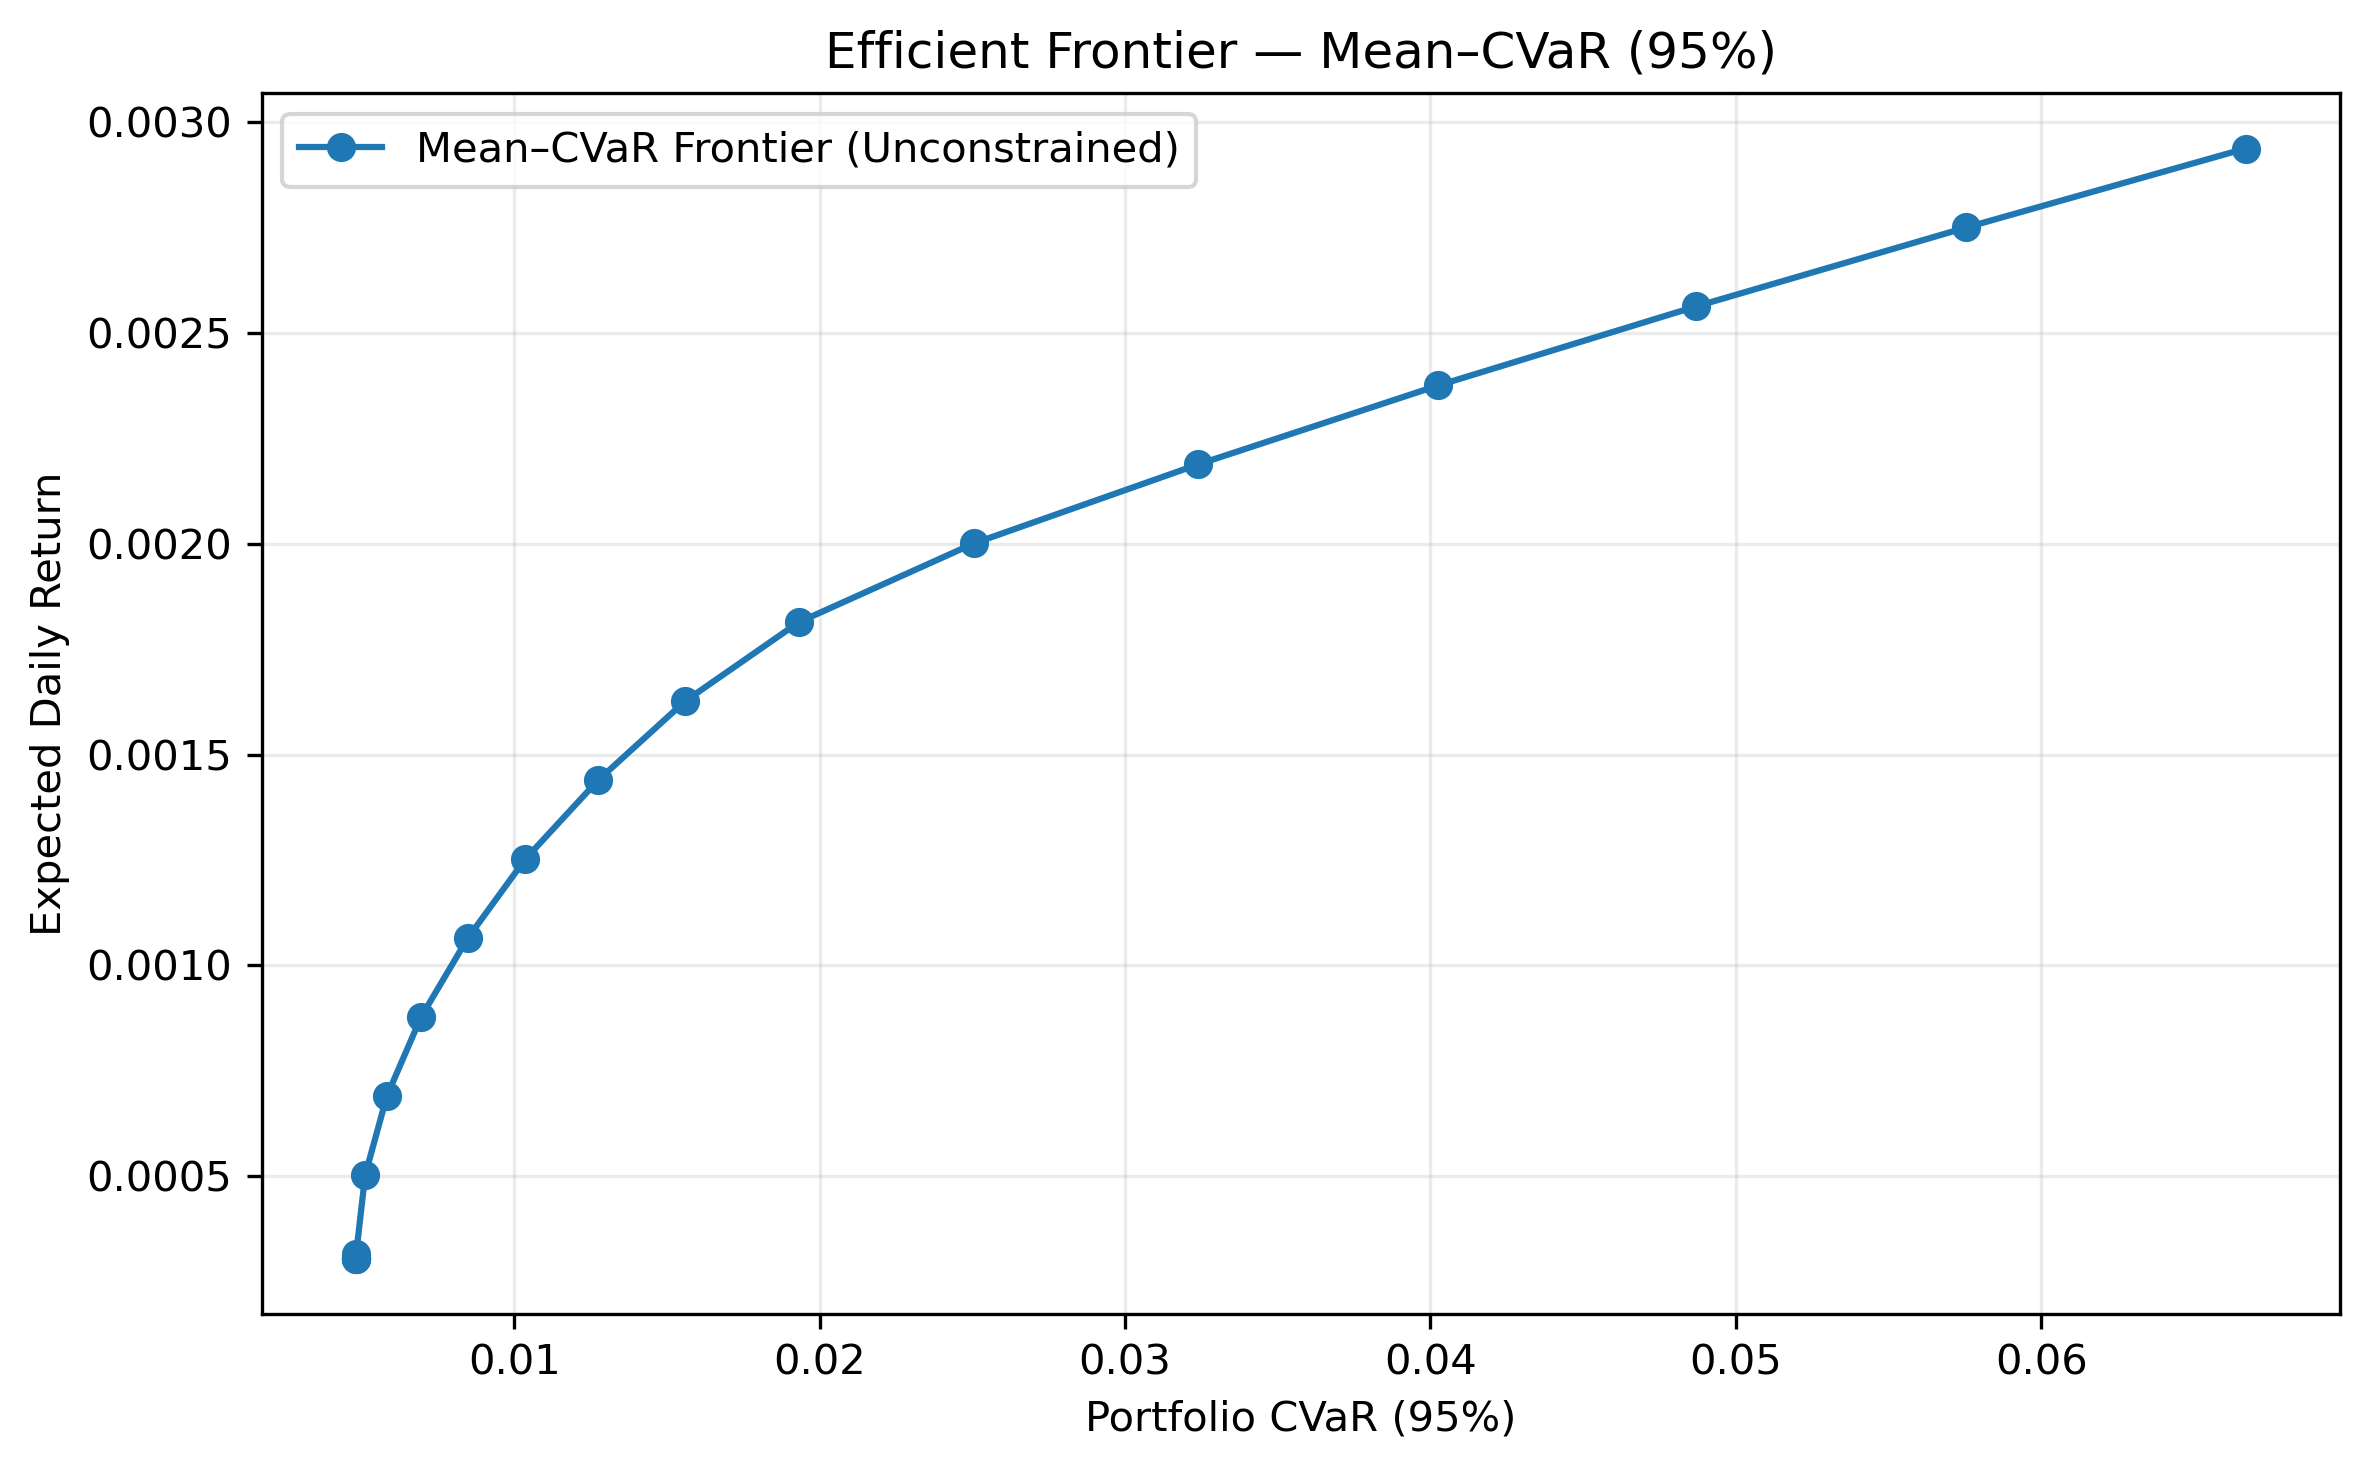

In [53]:
plt.figure(figsize=(8.0, 5.0), dpi=300)
plt.plot(cvar_all, ret_all, marker='o', label='Mean–CVaR Frontier (Unconstrained)')
plt.xlabel('Portfolio CVaR (95%)')
plt.ylabel('Expected Daily Return')
plt.title('Efficient Frontier — Mean–CVaR (95%)')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

### ESG-constrained portfolio

In [54]:
# Uses existing: R_esg (daily simple returns), mu_esg_d (daily means)
tg_esg = target_grid_from_mu(mu_esg_d.values, npts=NPTS)

cvar_esg, ret_esg, w_esg_list = [], [], []
for tr in tg_esg:
    c, r, w = opt_cvar_for_return(target_ret=tr, mu_d=mu_esg_d.values,
                                  R_simple=R_esg, alpha=ALPHA, allow_short=False)
    cvar_esg.append(c); ret_esg.append(r); w_esg_list.append(w)

weights_esg_df = pd.DataFrame(w_esg_list, columns=R_esg.columns, index=np.round(ret_esg, 6))
weights_esg_df.index.name = "Expected Daily Return"

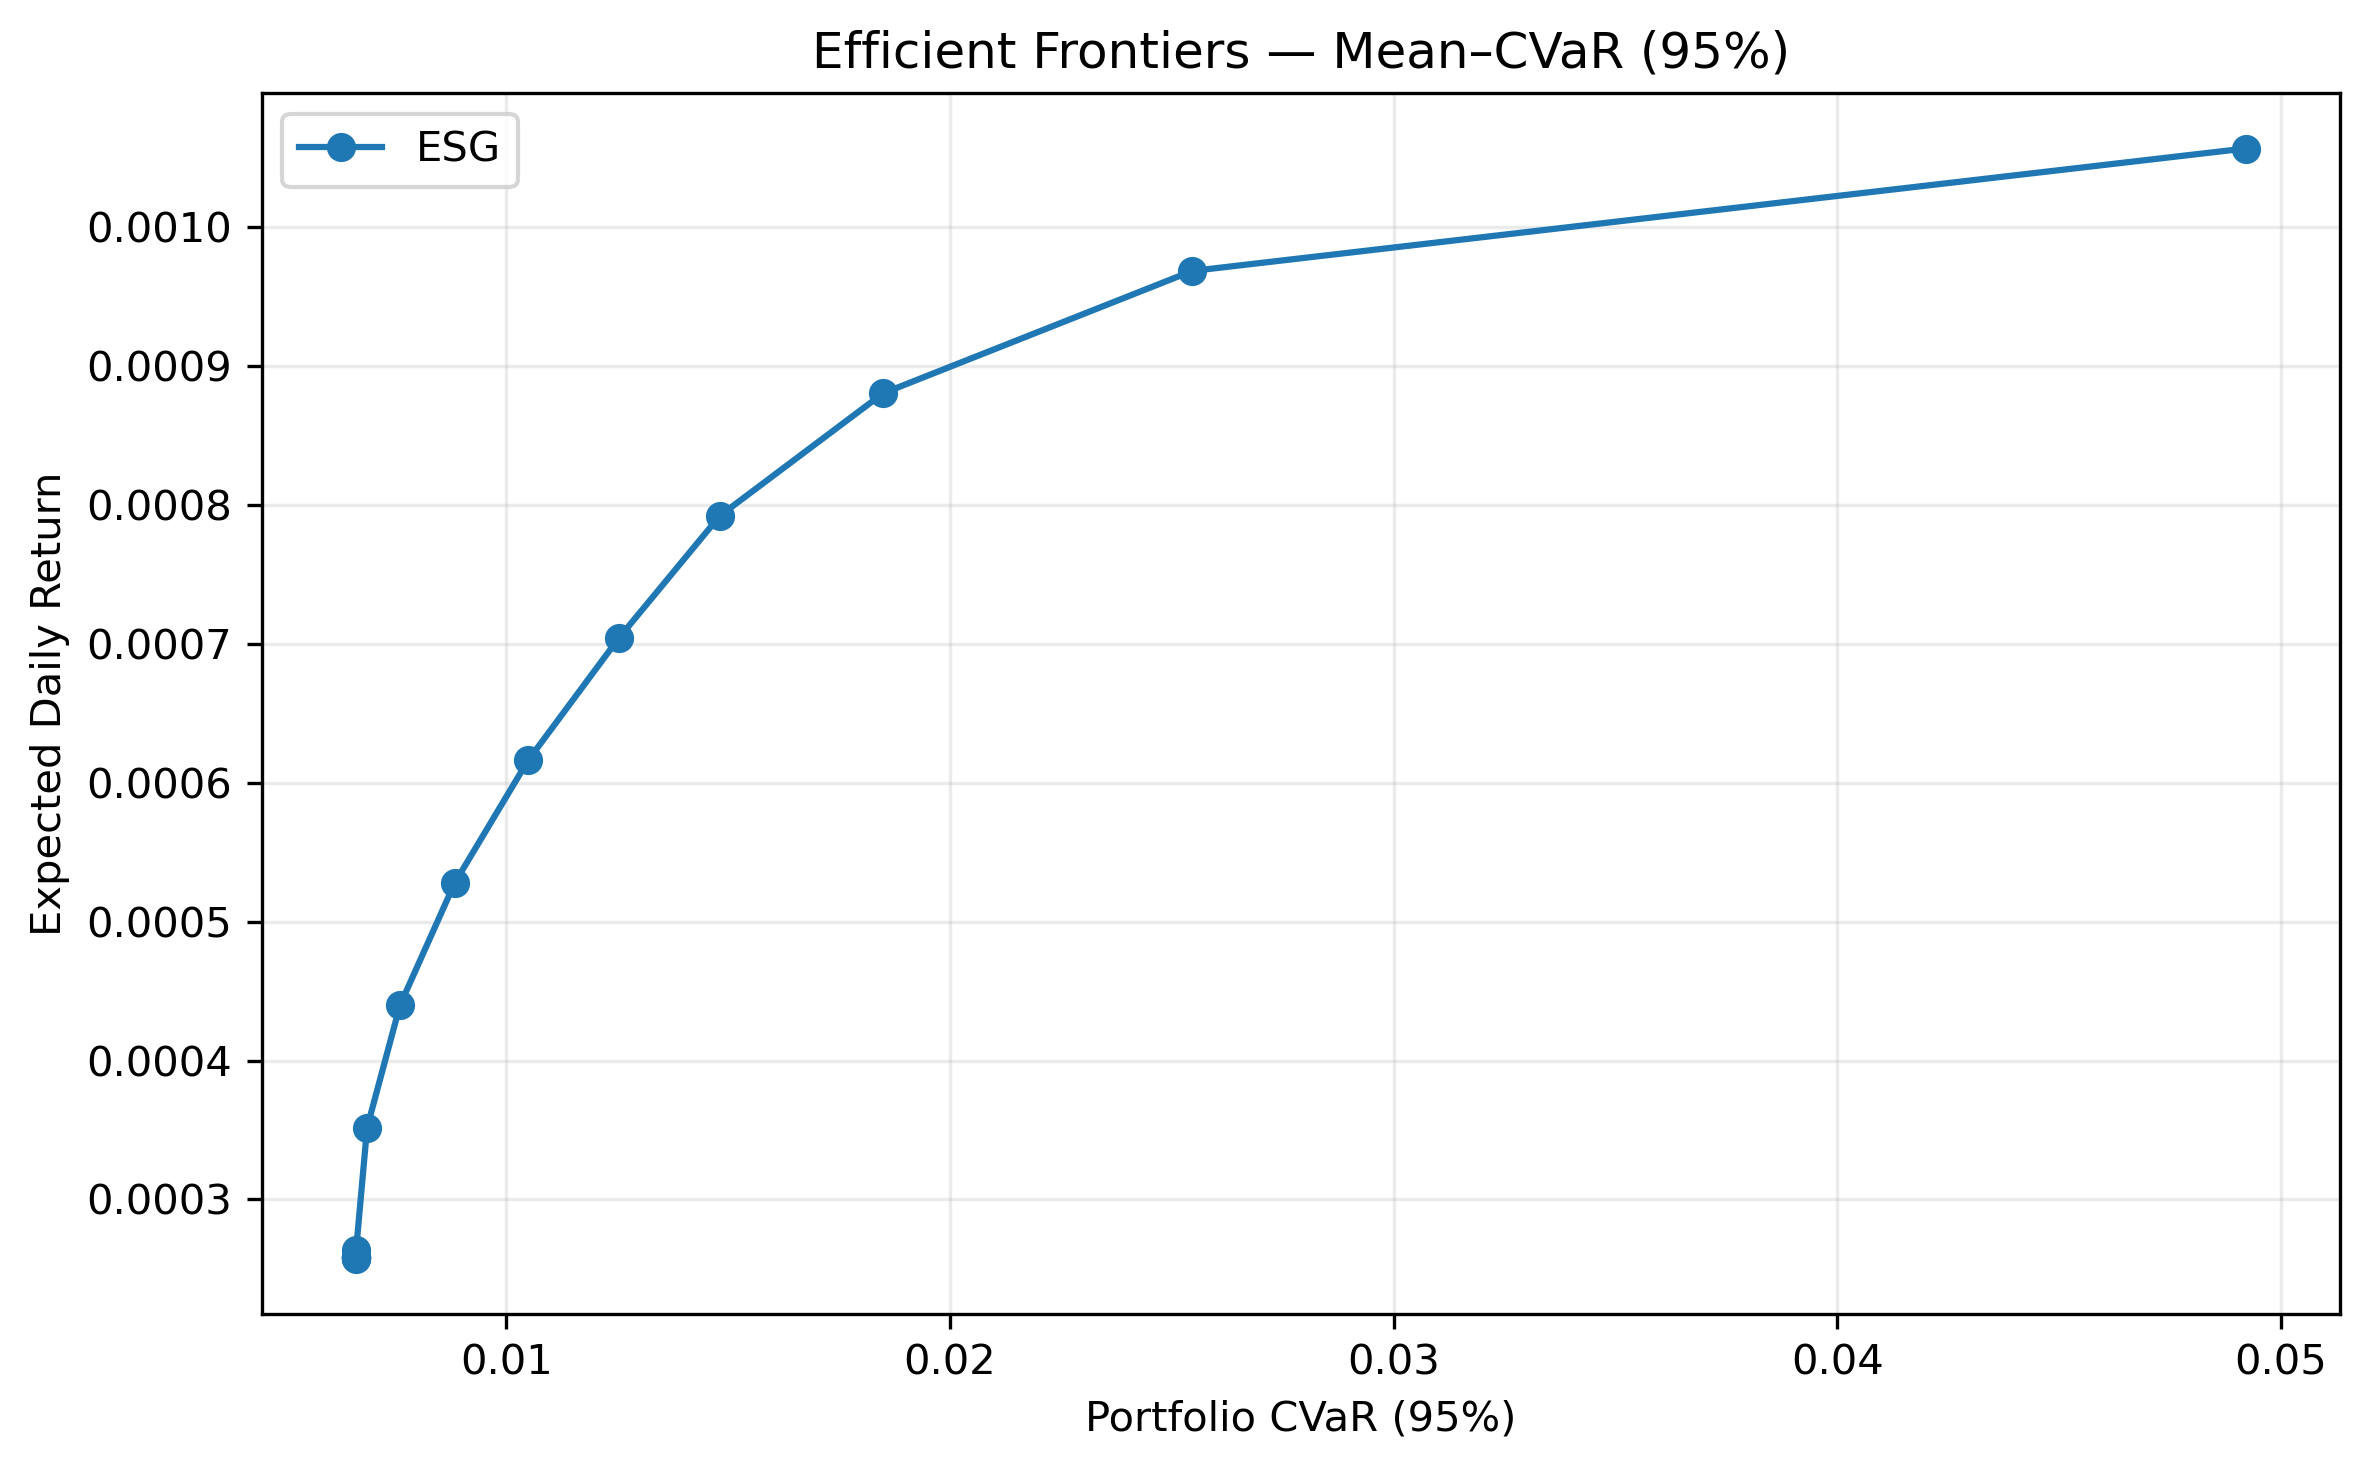

In [55]:
plt.figure(figsize=(8.0, 5.0), dpi=300)
# plt.plot(cvar_all, ret_all, marker='o', label='Unconstrained')
plt.plot(cvar_esg, ret_esg, marker='o', label='ESG') # linestyle='--'
plt.xlabel('Portfolio CVaR (95%)')
plt.ylabel('Expected Daily Return')
plt.title('Efficient Frontiers — Mean–CVaR (95%)')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

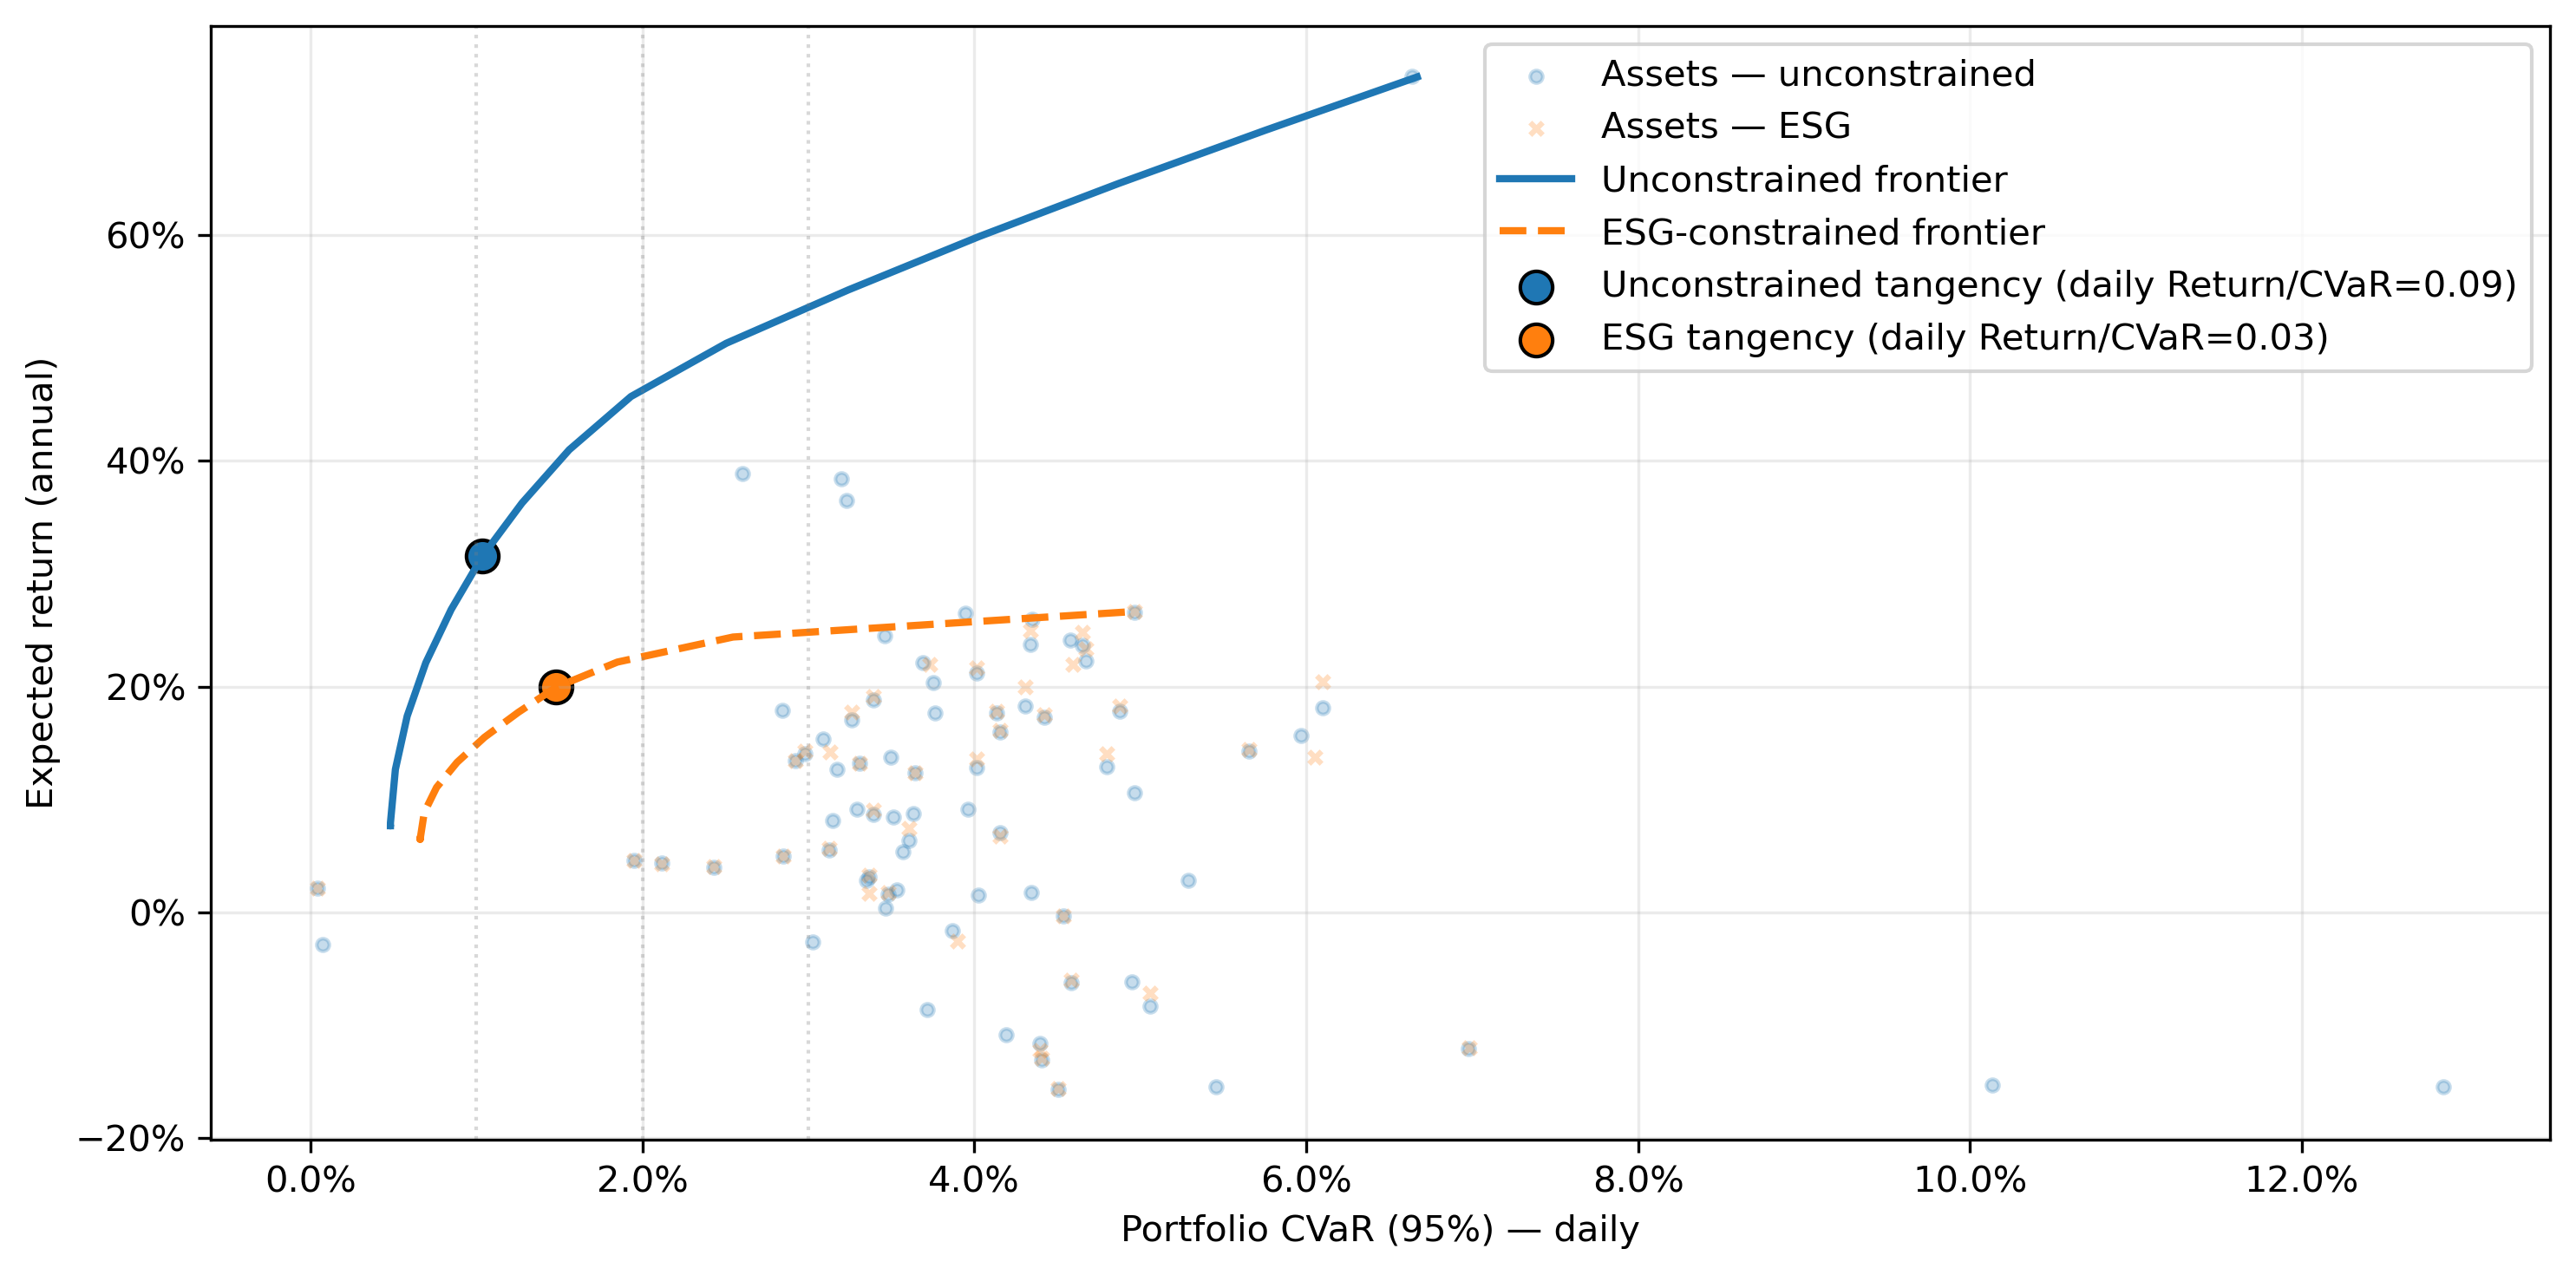

In [56]:
# assemble & sort frontiers by CVaR
U = np.column_stack([np.asarray(cvar_all), np.asarray(ret_all)])   # [CVaR_d, ret_d]
E = np.column_stack([np.asarray(cvar_esg), np.asarray(ret_esg)])
U = U[np.argsort(U[:,0])]
E = E[np.argsort(E[:,0])]

# CVaR-“Sharpe” (daily (mu - rf) / daily CVaR) and tangency indices
RF_ANNUAL = 0.0775
rf_d = RF_ANNUAL / 252.0
srU = (U[:,1] - rf_d) / U[:,0]
srE = (E[:,1] - rf_d) / E[:,0]
iU = int(np.nanargmax(srU))
iE = int(np.nanargmax(srE))

# asset clouds (compute daily CVaR95 and mean for each asset)
def empirical_cvar_d(x, alpha=0.95):
    loss = -np.asarray(x)
    q = np.quantile(loss, alpha, method="higher")
    tail = loss[loss >= q]
    return float(tail.mean()) if tail.size else 0.0

ptsU = ptsE = None
if 'R_univ' in globals():
    ptsU = np.array([[empirical_cvar_d(R_univ[c].values), R_univ[c].mean()] for c in R_univ.columns])
if 'R_esg' in globals():
    ptsE = np.array([[empirical_cvar_d(R_esg[c].values),  R_esg[c].mean()]  for c in R_esg.columns])

# annualize only the plotted y-values (keep CVaR on x as daily)
U_ann = U.copy(); U_ann[:,1] *= 252.0
E_ann = E.copy(); E_ann[:,1] *= 252.0
if ptsU is not None: ptsU[:,1] *= 252.0
if ptsE is not None: ptsE[:,1] *= 252.0

# plot
plt.figure(figsize=(10,5), dpi=300)

# clouds first, so lines/markers are on top
if ptsU is not None: plt.scatter(ptsU[:,0], ptsU[:,1], s=12, alpha=0.25, label='Assets — unconstrained')
if ptsE is not None: plt.scatter(ptsE[:,0], ptsE[:,1], s=12, alpha=0.25, marker='x', label='Assets — ESG')

plt.plot(U_ann[:,0], U_ann[:,1], lw=2, label='Unconstrained frontier')
plt.plot(E_ann[:,0], E_ann[:,1], lw=2, ls='--', label='ESG-constrained frontier')

# tangency markers (x = daily CVaR, y = annualized return)
plt.scatter(U_ann[iU,0], U_ann[iU,1], s=80, color='C0', edgecolor='k',
            label=f'Unconstrained tangency (daily Return/CVaR={srU[iU]:.2f})')
plt.scatter(E_ann[iE,0], E_ann[iE,1], s=80, color='C1', edgecolor='k',
            label=f'ESG tangency (daily Return/CVaR={srE[iE]:.2f})')

# optional CVaR budget guides
for x in (0.01, 0.02, 0.03):  # 1%, 2%, 3% daily CVaR
    plt.axvline(x, ls=':', lw=1, color='0.5', alpha=0.3)

plt.xlabel('Portfolio CVaR (95%) — daily')
plt.ylabel('Expected return (annual)')
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# Mean–CVaR comparison table: selected points (R_k, CVaR95, Sharpe, MDD) with deltas
ALPHA = 0.95
RF_ANNUAL = float(globals().get('rf_annual', 0.0775))

def empirical_cvar_d(x, alpha=ALPHA):
    x = np.asarray(x)
    loss = -x
    q = np.quantile(loss, alpha, method="higher")
    tail = loss[loss >= q]
    return float(tail.mean()) if tail.size else np.nan

def max_drawdown(r):
    r = np.asarray(r)
    wealth = np.cumprod(1.0 + r)
    peak = np.maximum.accumulate(wealth)
    dd = wealth / peak - 1.0
    return float(-dd.min())  # positive magnitude

def annualize(mu_d, vol_d, rf_ann=RF_ANNUAL):
    mu_ann  = 252.0 * mu_d
    vol_ann = np.sqrt(252.0) * vol_d
    sharpe  = np.nan if vol_ann <= 0 else (mu_ann - rf_ann) / vol_ann
    return mu_ann, vol_ann, sharpe

def _build_table(R_simple, weights_df, cvar_list, rf_ann=RF_ANNUAL):
    # ensure column alignment between returns and weights
    R = R_simple[weights_df.columns].to_numpy()
    W = weights_df.to_numpy()
    rows = []
    for i, w in enumerate(W):
        port = R @ w
        mu_d  = port.mean()
        vol_d = port.std(ddof=1)
        mu_ann, vol_ann, sr = annualize(mu_d, vol_d, rf_ann)
        mdd = max_drawdown(port)
        cvar_d = float(cvar_list[i]) if cvar_list is not None else empirical_cvar_d(port)
        rows.append(dict(Ret_ann=mu_ann, CVaR95_d=cvar_d, Vol_ann=vol_ann, Sharpe=sr, MDD=mdd))
    return pd.DataFrame(rows)

# Build per-universe summary tables
tbl_univ = _build_table(R_univ, weights_all_df, cvar_all, rf_ann=RF_ANNUAL)
tbl_esg  = _build_table(R_esg,  weights_esg_df, cvar_esg,  rf_ann=RF_ANNUAL)

# Align by nearest annual return (so rows are comparable)
comp_rows = []
for _, r in tbl_univ.iterrows():
    j = (tbl_esg['Ret_ann'] - r['Ret_ann']).abs().idxmin()
    e = tbl_esg.loc[j]
    comp_rows.append({
        'R_target_ann (≈)': r['Ret_ann'],
        'CVaR95_d_univ': r['CVaR95_d'], 'Sharpe_univ': r['Sharpe'], 'MDD_univ': r['MDD'],
        'CVaR95_d_esg':  e['CVaR95_d'], 'Sharpe_esg':  e['Sharpe'],  'MDD_esg':  e['MDD'],
        'ΔCVaR95_d (esg - univ)': e['CVaR95_d'] - r['CVaR95_d'],
        'ΔSharpe (esg - univ)':   e['Sharpe']   - r['Sharpe'],
        'ΔMDD (esg - univ)':      e['MDD']      - r['MDD'],
    })
tbl_comp_raw = pd.DataFrame(comp_rows).sort_values('R_target_ann (≈)').reset_index(drop=True)

# keep K evenly spaced points for the manuscript
K = 10  # change if desired
idx = np.linspace(0, len(tbl_comp_raw)-1, K).round().astype(int)
tbl_comp = tbl_comp_raw.iloc[idx].reset_index(drop=True)

# Pretty formatting + median summary row
pretty = tbl_comp.copy()
fmt_pct = ['R_target_ann (≈)', 'CVaR95_d_univ', 'CVaR95_d_esg', 'ΔCVaR95_d (esg - univ)',
           'MDD_univ', 'MDD_esg', 'ΔMDD (esg - univ)']
fmt_num = ['Sharpe_univ', 'Sharpe_esg', 'ΔSharpe (esg - univ)']

for c in fmt_pct: pretty[c] = pretty[c].map(lambda x: f'{x:.2%}')
for c in fmt_num: pretty[c] = pretty[c].map(lambda x: f'{x:.2f}')

median_row = pd.DataFrame({
    'R_target_ann (≈)': ['Median'],
    'CVaR95_d_univ': [tbl_comp['CVaR95_d_univ'].median()],
    'Sharpe_univ':   [tbl_comp['Sharpe_univ'].median()],
    'MDD_univ':      [tbl_comp['MDD_univ'].median()],
    'CVaR95_d_esg':  [tbl_comp['CVaR95_d_esg'].median()],
    'Sharpe_esg':    [tbl_comp['Sharpe_esg'].median()],
    'MDD_esg':       [tbl_comp['MDD_esg'].median()],
    'ΔCVaR95_d (esg - univ)': [tbl_comp['ΔCVaR95_d (esg - univ)'].median()],
    'ΔSharpe (esg - univ)':   [tbl_comp['ΔSharpe (esg - univ)'].median()],
    'ΔMDD (esg - univ)':      [tbl_comp['ΔMDD (esg - univ)'].median()],
})
median_pretty = median_row.copy()
for c in fmt_pct: median_pretty[c] = median_pretty[c].map(lambda x: f'{x:.2%}' if c!='R_target_ann (≈)' else x)
for c in fmt_num: median_pretty[c] = median_pretty[c].map(lambda x: f'{x:.2f}')

pretty_with_median = pd.concat([pretty, median_pretty], ignore_index=True)

# Export
tbl_comp.to_csv('cvar_frontier_comparison_raw.csv', index=False)
pretty_with_median.to_csv('cvar_frontier_comparison_pretty.csv', index=False)

# display
print(pretty_with_median)


   R_target_ann (≈) CVaR95_d_univ Sharpe_univ MDD_univ CVaR95_d_esg  \
0             7.68%         0.48%       -0.01    3.72%        0.66%   
1             7.69%         0.48%       -0.01    3.73%        0.66%   
2             7.72%         0.48%       -0.01    3.76%        0.66%   
3            12.68%         0.51%        1.03    3.96%        0.88%   
4            22.12%         0.70%        2.20    5.26%        1.85%   
5            36.27%         1.28%        2.57    8.60%        4.92%   
6            45.71%         1.93%        2.34   12.01%        4.92%   
7            55.14%         3.24%        1.88   19.06%        4.92%   
8            64.58%         4.87%        1.54   27.45%        4.92%   
9            74.01%         6.67%        1.33   41.17%        4.92%   
10           Median         0.99%        1.43    6.93%        3.38%   

   Sharpe_esg MDD_esg ΔCVaR95_d (esg - univ) ΔSharpe (esg - univ)  \
0       -0.21   4.93%                  0.18%                -0.20   
1       -

In [58]:

K = 10  # number of rows to report (evenly spaced across the overlap)

def _dedupe_by_return(df, eps=1e-10):
    df = df.sort_values('Ret_ann').reset_index(drop=True)
    keep = [0]
    for i in range(1, len(df)):
        if abs(df.loc[i, 'Ret_ann'] - df.loc[keep[-1], 'Ret_ann']) > eps:
            keep.append(i)
    return df.loc[keep].reset_index(drop=True)

def _interp_metric(df, ret_grid, col):
    x = df['Ret_ann'].to_numpy()
    y = df[col].to_numpy()
    idx = np.argsort(x)
    x, y = x[idx], y[idx]
    return np.interp(ret_grid, x, y)

# --- Build summary tables for each universe (one row per weight vector) ---
tbl_univ = _build_table(R_univ, weights_all_df, cvar_all, rf_ann=RF_ANNUAL)
tbl_esg  = _build_table(R_esg,  weights_esg_df, cvar_esg,  rf_ann=RF_ANNUAL)

# De-duplicate by achieved annual return (prevents repeats in interpolation)
tu = _dedupe_by_return(tbl_univ)
te = _dedupe_by_return(tbl_esg)

# Overlapping achievable return range
lo = max(tu['Ret_ann'].min(), te['Ret_ann'].min())
hi = min(tu['Ret_ann'].max(), te['Ret_ann'].max())
if not (hi > lo):
    raise RuntimeError("No overlap in achievable returns between universes for Table 5.")

ret_grid = np.linspace(lo, hi, K)

# Interpolate metrics at the same returns for both universes
comp = pd.DataFrame({
    'R_match_ann':        ret_grid,
    'CVaR95_d_univ': _interp_metric(tu, ret_grid, 'CVaR95_d'),
    'Sharpe_univ':   _interp_metric(tu, ret_grid, 'Sharpe'),
    'MDD_univ':      _interp_metric(tu, ret_grid, 'MDD'),
    'CVaR95_d_esg':  _interp_metric(te, ret_grid, 'CVaR95_d'),
    'Sharpe_esg':    _interp_metric(te, ret_grid, 'Sharpe'),
    'MDD_esg':       _interp_metric(te, ret_grid, 'MDD'),
})

# Deltas (ESG minus Unconstrained)
comp['ΔCVaR95_d (esg - univ)'] = comp['CVaR95_d_esg'] - comp['CVaR95_d_univ']
comp['ΔSharpe (esg - univ)']   = comp['Sharpe_esg']   - comp['Sharpe_univ']
comp['ΔMDD (esg - univ)']      = comp['MDD_esg']      - comp['MDD_univ']

# Export CSV (raw, unformatted)
comp.to_csv('table5_cvar_common.csv', index=False)

# (optional) quick peek
print(comp)

   R_match_ann  CVaR95_d_univ  Sharpe_univ  MDD_univ  CVaR95_d_esg  \
0     0.076836       0.004823    -0.014509  0.037221      0.006729   
1     0.097880       0.004939     0.427819  0.039564      0.007169   
2     0.118925       0.005071     0.867672  0.039567      0.008051   
3     0.139969       0.005319     1.230759  0.041074      0.009352   
4     0.161013       0.005636     1.547527  0.043488      0.011021   
5     0.182057       0.006023     1.820431  0.046283      0.013010   
6     0.203101       0.006522     2.022379  0.049695      0.015389   
7     0.224145       0.007047     2.209432  0.053231      0.019218   
8     0.245190       0.007729     2.305300  0.057522      0.026700   
9     0.266234       0.008412     2.401168  0.061812      0.049204   

   Sharpe_esg   MDD_esg  ΔCVaR95_d (esg - univ)  ΔSharpe (esg - univ)  \
0   -0.021109  0.053275                0.001906             -0.006600   
1    0.330910  0.058996                0.002230             -0.096909   
2    0.600

#### Var vs. CVaR comparison

In [54]:
def var_cvar_from_returns(ret_series, alpha=0.95):
    """
    VaR/CVaR at level alpha for a series of DAILY returns.
    Returns positive magnitudes (e.g., 0.008 -> 0.8% loss).
    """
    s = pd.Series(ret_series).dropna().values
    losses = -s
    sorted_losses = np.sort(losses)                  # ascending (small -> large)
    n = len(sorted_losses)
    q_idx = int(np.ceil(alpha * n)) - 1             # 95th percentile index
    q_idx = min(max(q_idx, 0), n - 1)

    VaR  = sorted_losses[q_idx]                      # cutoff loss at alpha
    CVaR = sorted_losses[q_idx:].mean()              # average of worst (1-alpha) tail
    return -VaR, -CVaR                               # return as positive “returns”

# Unconstrained: pick min-CVaR portfolio from frontier
idx_u = int(np.argmin(cvar_all))
w_u   = w_all[idx_u]
ret_u = (R @ pd.Series(w_u, index=R.columns))
VaR_u, CVaR_u = var_cvar_from_returns(ret_u, alpha=0.95)

# ESG: pick min-CVaR portfolio from frontier
idx_e = int(np.argmin(cvar_esg))
w_e   = w_esg_list[idx_e]
ret_e = (R_esg @ pd.Series(w_e, index=R_esg.columns))
VaR_e, CVaR_e = var_cvar_from_returns(ret_e, alpha=0.95)

print(f"Unconstrained — VaR (95%): {VaR_u:.4%}   CVaR (95%): {CVaR_u:.4%}")
print(f"ESG           — VaR (95%): {VaR_e:.4%}   CVaR (95%): {CVaR_e:.4%}")

Unconstrained — VaR (95%): -0.3885%   CVaR (95%): -0.4811%
ESG           — VaR (95%): -0.4107%   CVaR (95%): -0.6580%


### Plots: return distributions with VaR/CVaR markers (95%) for both portfolios

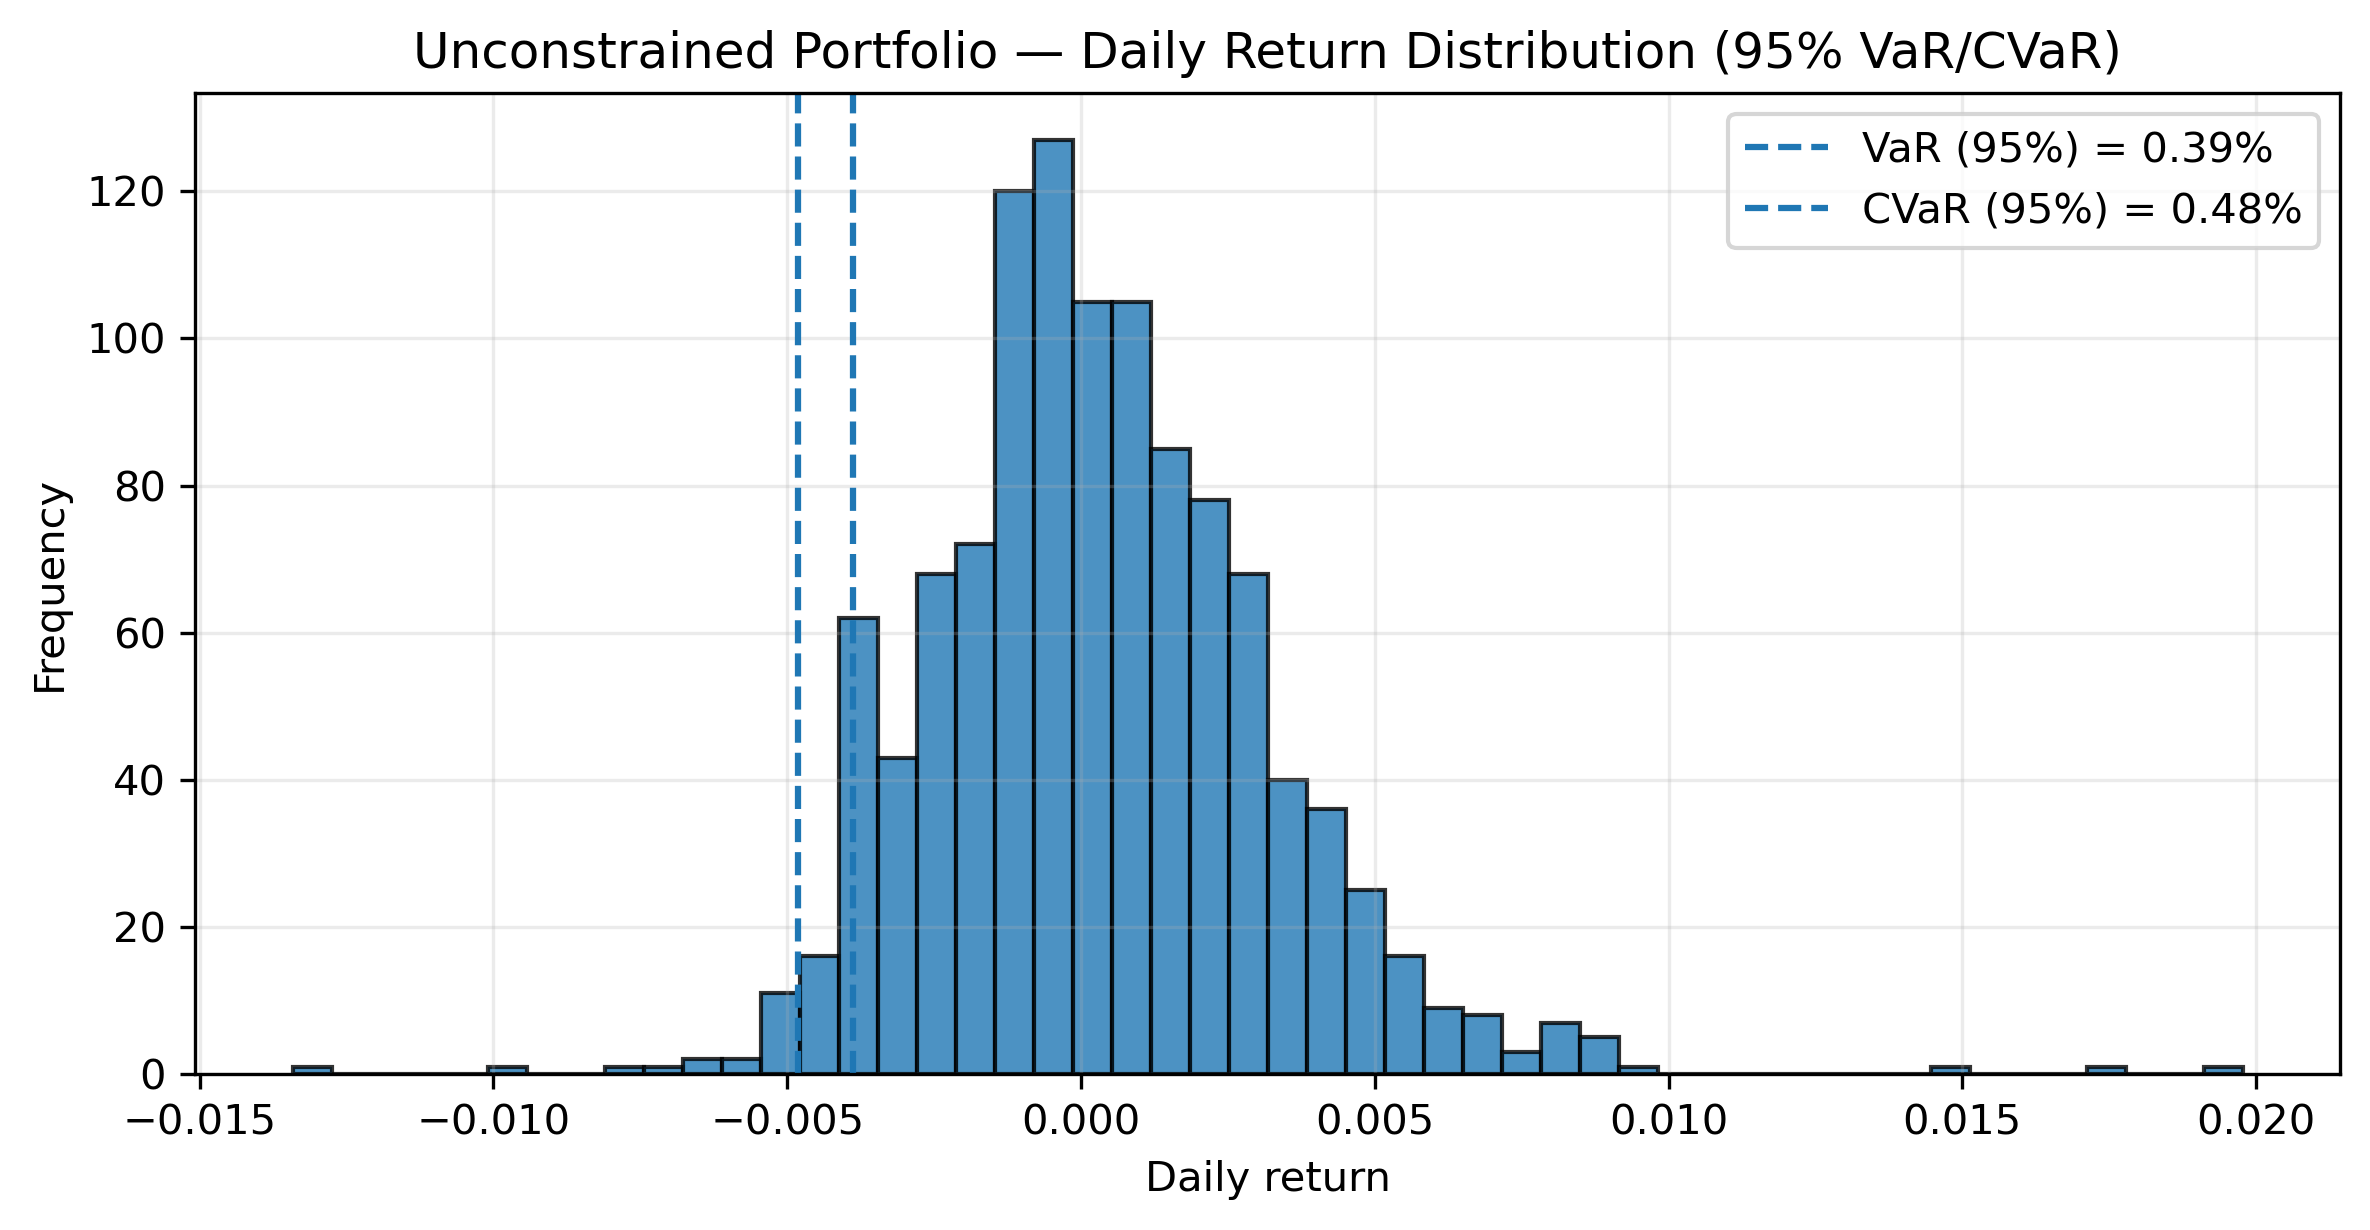

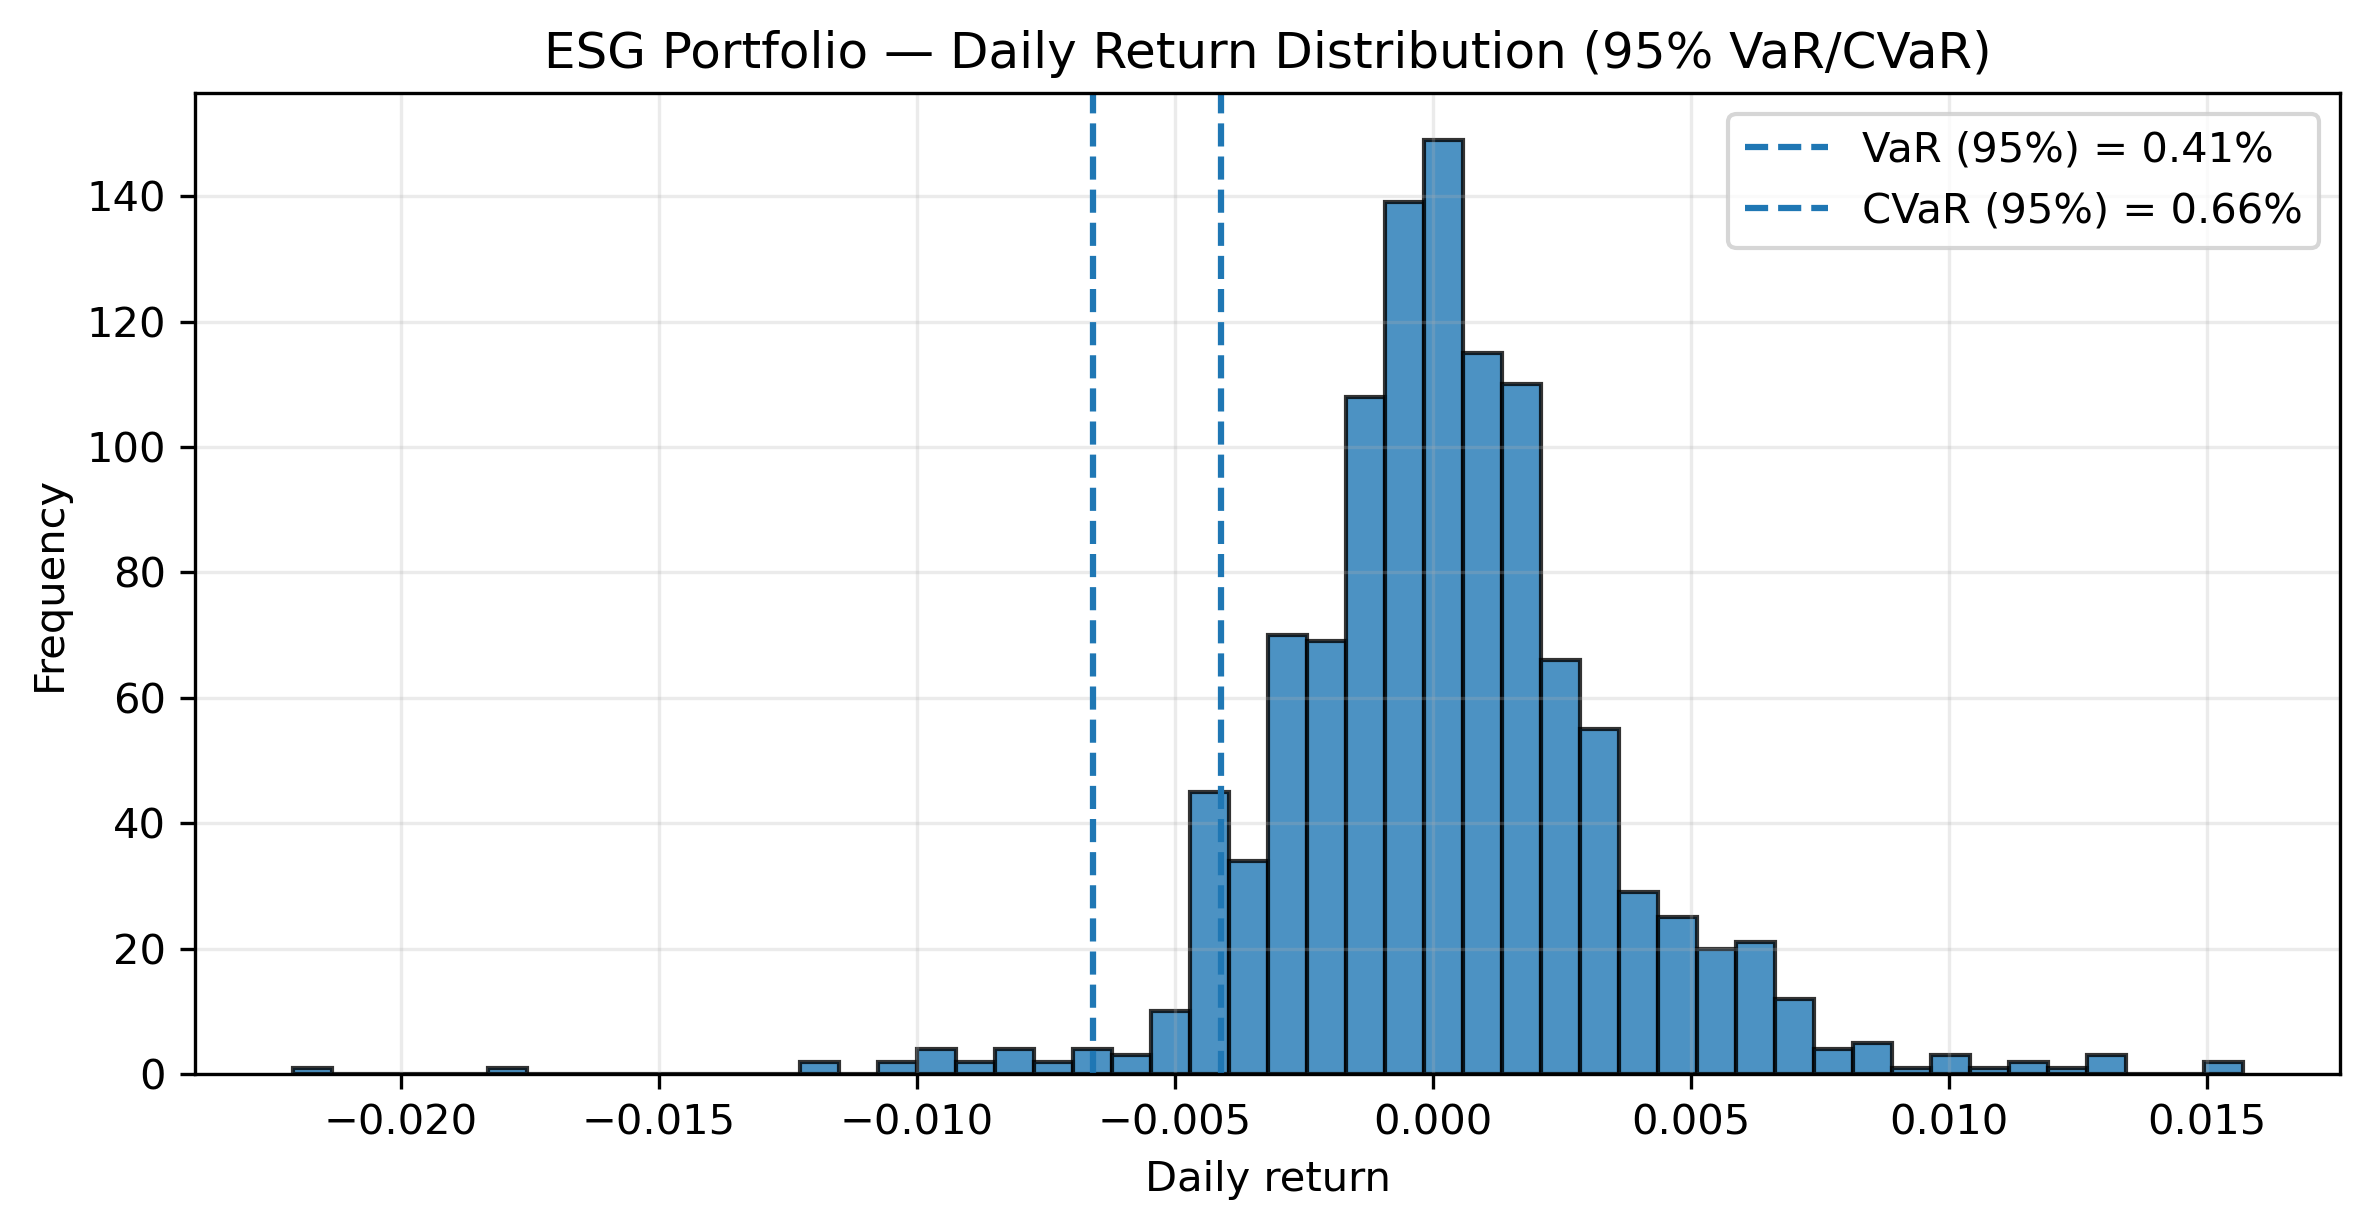

In [55]:
def _as_threshold(x):
    """Ensure we plot at the return threshold (negative value on x-axis)."""
    return x if x < 0 else -x

# Unconstrained
var_u_th  = _as_threshold(VaR_u)
cvar_u_th = _as_threshold(CVaR_u)

plt.figure(figsize=(8.0, 4.2), dpi=300)
plt.hist(pd.Series(ret_u).dropna(), bins=50, edgecolor='black', alpha=0.8)
plt.axvline(var_u_th,  linestyle='--', linewidth=1.5, label=f'VaR (95%) = {abs(var_u_th):.2%}')
plt.axvline(cvar_u_th, linestyle='--', linewidth=1.5, label=f'CVaR (95%) = {abs(cvar_u_th):.2%}')
plt.title('Unconstrained Portfolio — Daily Return Distribution (95% VaR/CVaR)')
plt.xlabel('Daily return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# ESG
var_e_th  = _as_threshold(VaR_e)
cvar_e_th = _as_threshold(CVaR_e)

plt.figure(figsize=(8.0, 4.2), dpi=300)
plt.hist(pd.Series(ret_e).dropna(), bins=50, edgecolor='black', alpha=0.8)
plt.axvline(var_e_th,  linestyle='--', linewidth=1.5, label=f'VaR (95%) = {abs(var_e_th):.2%}')
plt.axvline(cvar_e_th, linestyle='--', linewidth=1.5, label=f'CVaR (95%) = {abs(cvar_e_th):.2%}')
plt.title('ESG Portfolio — Daily Return Distribution (95% VaR/CVaR)')
plt.xlabel('Daily return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# Comparison between the two methods

In [56]:
# helper metrics (no re-estimation)
def ann_arith_ret(series):  # arithmetic annual return
    s = pd.Series(series).dropna()
    return s.mean() * TRADING_DAYS

def ann_vol(series):
    s = pd.Series(series).dropna()
    return s.std() * np.sqrt(TRADING_DAYS)

def sharpe(series, rf_annual):
    ra = ann_arith_ret(series)
    va = ann_vol(series)
    return (ra - rf_annual) / va

def sortino(series, rf_annual=0.0):  # downside vs 0; change to rf_daily if prefered
    s = pd.Series(series).dropna()
    downside = s[s < 0]
    dd = downside.std() * np.sqrt(TRADING_DAYS)
    return (s.mean() * TRADING_DAYS) / dd if dd > 0 else np.nan

def max_drawdown(series):
    s = pd.Series(series).dropna()
    cum = (1 + s).cumprod()
    peak = cum.cummax()
    return float((cum / peak - 1).min())

def var_cvar_from_returns(ret_series, alpha=0.95):
    """Return VaR & CVaR (positive loss magnitudes) at level alpha from DAILY returns."""
    s = pd.Series(ret_series).dropna().values
    losses = -s
    sorted_losses = np.sort(losses)                # ascending
    n = len(sorted_losses)
    q_idx = int(np.ceil(alpha * n)) - 1            # alpha-quantile index
    q_idx = min(max(q_idx, 0), n - 1)
    VaR  = sorted_losses[q_idx]
    CVaR = sorted_losses[q_idx:].mean()
    return VaR, CVaR

# UNCONSTRAINED
# bind weights to the correct universe
w_mv_u   = pd.Series(w_tan_all,           index=R.columns)                # Max-Sharpe (from EF)
idx_u    = int(np.argmin(cvar_all))                                       # min-CVaR point on CVaR frontier
w_cvar_u = pd.Series(w_all[idx_u],        index=R.columns)                # Min-CVaR

# portfolio daily series
rp_mv_u   = R @ w_mv_u
rp_cvar_u = R @ w_cvar_u

# tail metrics
VaR_u_mv,   CVaR_u_mv   = var_cvar_from_returns(rp_mv_u,   alpha=0.95)
VaR_u_cvar, CVaR_u_cvar = var_cvar_from_returns(rp_cvar_u, alpha=0.95)

# comparison table
comp_uncon = pd.DataFrame({
    "Annual ret": [ann_arith_ret(rp_mv_u),   ann_arith_ret(rp_cvar_u)],
    "Annual vol": [ann_vol(rp_mv_u),         ann_vol(rp_cvar_u)],
    "Sharpe":     [sharpe(rp_mv_u, RF_ANNUAL), sharpe(rp_cvar_u, RF_ANNUAL)],
    "Sortino":    [sortino(rp_mv_u),         sortino(rp_cvar_u)],
    "Max DD":     [max_drawdown(rp_mv_u),    max_drawdown(rp_cvar_u)],
    "VaR95":      [VaR_u_mv,                 VaR_u_cvar],
    "CVaR95":     [CVaR_u_mv,                CVaR_u_cvar],
}, index=["Mean–Variance (Max SR)", "Mean–CVaR (Min CVaR)"]).T

# ESG
w_mv_e    = pd.Series(w_tan_esg,           index=R_esg.columns)           # Max-Sharpe (from ESG EF)
idx_e     = int(np.argmin(cvar_esg))                                      # min-CVaR on ESG CVaR frontier
w_cvar_e  = pd.Series(w_esg_list[idx_e],   index=R_esg.columns)           # Min-CVaR

rp_mv_e   = R_esg @ w_mv_e
rp_cvar_e = R_esg @ w_cvar_e

VaR_e_mv,   CVaR_e_mv   = var_cvar_from_returns(rp_mv_e,   alpha=0.95)
VaR_e_cvar, CVaR_e_cvar = var_cvar_from_returns(rp_cvar_e, alpha=0.95)

comp_esg = pd.DataFrame({
    "Annual ret": [ann_arith_ret(rp_mv_e),   ann_arith_ret(rp_cvar_e)],
    "Annual vol": [ann_vol(rp_mv_e),         ann_vol(rp_cvar_e)],
    "Sharpe":     [sharpe(rp_mv_e, RF_ANNUAL), sharpe(rp_cvar_e, RF_ANNUAL)],
    "Sortino":    [sortino(rp_mv_e),         sortino(rp_cvar_e)],
    "Max DD":     [max_drawdown(rp_mv_e),    max_drawdown(rp_cvar_e)],
    "VaR95":      [VaR_e_mv,                 VaR_e_cvar],
    "CVaR95":     [CVaR_e_mv,                CVaR_e_cvar],
}, index=["Mean–Variance (Max SR)", "Mean–CVaR (Min CVaR)"]).T

# Display both tables
print("=== Unconstrained universe ===")
display(comp_uncon)

print("\n=== ESG universe ===")
display(comp_esg)

=== Unconstrained universe ===


Mean–Variance (Max SR)  Mean–CVaR (Min CVaR)
Annual ret                0.335522              0.076919
Annual vol                0.097862              0.045794
Sharpe                    2.636590             -0.012682
Sortino                   5.724609              3.175400
Max DD                   -0.079958             -0.037302
VaR95                     0.007639              0.003885
CVaR95                    0.011526              0.004811


=== ESG universe ===


Mean–Variance (Max SR)  Mean–CVaR (Min CVaR)
Annual ret                0.199571              0.065132
Annual vol                0.118364              0.051644
Sharpe                    1.031321             -0.239478
Sortino                   2.597937              1.874496
Max DD                   -0.133399             -0.049815
VaR95                     0.010940              0.004107
CVaR95                    0.015522              0.006580

# Reference Portfolios (Weights, Returns, Risk)

In [67]:
RF_ANNUAL = float(globals().get('rf_annual', 0.0775))
RF_DAILY  = RF_ANNUAL / 252.0
ALPHA     = 0.95

# pull/derive a ticker->ESG score series
_esg = None
if 'esg_scores' in globals() and isinstance(esg_scores, pd.Series):
    _esg = esg_scores.astype(float)
elif 'filtered_prices' in globals():
    if {'Ticker','curr_esg_score'}.issubset(set(filtered_prices.columns)):
        _esg = (filtered_prices[['Ticker','curr_esg_score']]
                .dropna().drop_duplicates('Ticker')
                .set_index('Ticker')['curr_esg_score'].astype(float))

def _metrics_from_weights(R, w, rf_ann=RF_ANNUAL, esg_series=_esg):
    p = R.values @ w
    mu_d  = p.mean()
    vol_d = p.std(ddof=1)
    # annualized
    mu_ann  = 252.0 * mu_d
    vol_ann = np.sqrt(252.0) * vol_d
    sharpe  = np.nan if vol_ann<=0 else (mu_ann - rf_ann) / vol_ann
    # Sortino (downside vs 0), annualized
    dn = np.minimum(p, 0.0)
    dn_sd_d = np.sqrt((dn**2).mean())
    sortino  = np.nan if dn_sd_d<=0 else mu_ann / (np.sqrt(252.0) * dn_sd_d)
    # VaR/CVaR (daily)
    loss = -p
    q = np.quantile(loss, ALPHA, method="higher")
    cvar = loss[loss >= q].mean() if np.any(loss >= q) else float(q)
    # Max DD (positive magnitude)
    wealth = np.cumprod(1.0 + p)
    peak   = np.maximum.accumulate(wealth)
    mdd = float(-(wealth/peak - 1.0).min())
    # Concentration
    holdings   = int((w > 1e-6).sum())
    hhi        = float(np.sum(w**2))
    w_max      = float(w.max())
    # Portfolio ESG
    esg_val = np.nan
    if esg_series is not None:
        s = esg_series.reindex(R.columns)
        m = ~s.isna()
        if m.any():
            esg_val = float(np.dot(w[m.values], s[m].values))
    return dict(Ret_ann=mu_ann, Vol_ann=vol_ann, VaR95_d=float(q), CVaR95_d=float(cvar),
                Sharpe=sharpe, Sortino=sortino, MDD=mdd,
                Holdings=holdings, Herfindahl=hhi, Max_weight=w_max, ESG=esg_val)

def _get_gmv_weights(R):
    try:
        res_gmv, _ = _solve_gmv(R, allow_short=False)  # helper
        w = np.clip(res_gmv.x, 0, None); w /= w.sum()
        return w
    except Exception:
        try:
            w = solve_gmv(R)  
            return w
        except Exception:
            from scipy.optimize import minimize
            Sigma = R.cov().values
            n = Sigma.shape[0]
            var_obj = lambda w: w @ Sigma @ w
            cons = ({'type':'eq','fun':lambda w: w.sum()-1.0},)
            bounds = [(0.0,1.0)]*n
            w0 = np.full(n, 1.0/n)
            res = minimize(var_obj, w0, method='SLSQP', constraints=cons, bounds=bounds,
                           options={'maxiter':10_000})
            w = np.clip(res.x, 0, None); w /= w.sum()
            return w

def _reference_table_from_existing(R, weights_df, ret_list, cvar_list, universe_name):
    cols = R.columns
    n    = len(cols)
    # MV — Tangency and GMV using existing solvers
    w_tan, _ = solve_max_sharpe(R, rf_daily=RF_DAILY, allow_short=False)  
    w_gmv    = _get_gmv_weights(R)

    # CVaR — from the frontier already built
    ret_arr  = np.asarray(ret_list)     # DAILY expected return per frontier point
    cvar_arr = np.asarray(cvar_list)    # DAILY CVaR(95%) per frontier point
    i_abs    = int(np.nanargmin(cvar_arr))
    w_cvar_abs = weights_df.iloc[i_abs].values

    target_mu_tan_d = float(R.mean().values @ w_tan)
    i_match = int(np.nanargmin(np.abs(ret_arr - target_mu_tan_d)))
    w_cvar_match = weights_df.iloc[i_match].values

    w_ew = np.full(n, 1.0/n)

    PORTS = {
        'MV–GMV'                    : w_gmv,
        'MV–Tangency (Max Sharpe)'  : w_tan,
        'CVaR–Min (matched return)' : w_cvar_match,
        'CVaR–Min (absolute)'       : w_cvar_abs,
        'Equal-Weight'              : w_ew,
    }

    rows, W = [], pd.DataFrame(index=cols)
    for name, w in PORTS.items():
        rows.append({'Portfolio': name, **_metrics_from_weights(R, w)})
        W[name] = w

    df = pd.DataFrame(rows).set_index('Portfolio')
    pretty = df.copy()
    pct_cols = ['Ret_ann','Vol_ann','VaR95_d','CVaR95_d','MDD','Max_weight']
    for c in pct_cols: pretty[c] = pretty[c].map(lambda x: f'{x:.2%}')
    for c in ['Sharpe','Sortino','Herfindahl','ESG']: pretty[c] = pretty[c].map(lambda x: f'{x:.2f}' if pd.notna(x) else '')
    pretty['Holdings'] = pretty['Holdings'].astype(int)

    # print & save
    print(f'\n=== Reference portfolios — {universe_name} ===')
    display(pretty) if 'display' in globals() else print(pretty)
    # df.to_csv(f'reference_portfolios_{universe_name.lower()}_raw.csv')
    # pretty.to_csv(f'reference_portfolios_{universe_name.lower()}_pretty.csv')
    # W.to_csv(f'reference_weights_{universe_name.lower()}.csv')  # columns = portfolios

    return df, pretty, W

# build tables for both universes
df_ref_univ, pretty_ref_univ, W_ref_univ = _reference_table_from_existing(
    R_univ, weights_all_df, ret_all, cvar_all, universe_name='Unconstrained')

df_ref_esg,  pretty_ref_esg,  W_ref_esg  = _reference_table_from_existing(
    R_esg,  weights_esg_df,  ret_esg, cvar_esg, universe_name='ESG')


=== Reference portfolios — Unconstrained ===
                          Ret_ann Vol_ann VaR95_d CVaR95_d Sharpe Sortino  \
Portfolio                                                                   
MV–GMV                      6.58%   4.07%   0.35%    0.53%  -0.29    2.57   
MV–Tangency (Max Sharpe)   33.56%   9.79%   0.76%    1.15%   2.64    6.16   
CVaR–Min (matched return)  31.55%   9.36%   0.73%    1.03%   2.54    6.18   
CVaR–Min (absolute)         7.69%   4.58%   0.39%    0.48%  -0.01    2.83   
Equal-Weight                9.92%  10.01%   0.99%    1.28%   0.22    1.48   

                              MDD  Holdings Herfindahl Max_weight   ESG  
Portfolio                                                                
MV–GMV                      4.11%        49       0.07     14.65%  3.38  
MV–Tangency (Max Sharpe)    8.00%        19       0.12     23.65%  2.59  
CVaR–Min (matched return)   7.41%        23       0.11     22.13%  2.74  
CVaR–Min (absolute)         3.73%        41 

# Cross-Method Comparison at Matched Expected Return

In [58]:
RF_ANNUAL = float(globals().get('rf_annual', 0.0775))
RF_DAILY  = RF_ANNUAL / 252.0
ALPHA     = 0.95

def _eval_portfolio(R, w, esg_series=None):
    p = R.values @ w
    mu_d, sd_d = p.mean(), p.std(ddof=1)
    mu_ann  = 252*mu_d
    vol_ann = np.sqrt(252)*sd_d
    sharpe  = np.nan if vol_ann<=0 else (mu_ann - RF_ANNUAL)/vol_ann
    dn = np.minimum(p, 0.0); dn_sd = (dn**2).mean()**0.5
    sortino = np.nan if dn_sd<=0 else mu_ann/(np.sqrt(252)*dn_sd)
    loss = -p
    q = np.quantile(loss, 0.95, method="higher")
    cvar = loss[loss>=q].mean() if np.any(loss>=q) else float(q)
    wealth = np.cumprod(1+p); peak = np.maximum.accumulate(wealth)
    mdd = float(-(wealth/peak - 1).min())
    holdings = int((w>1e-6).sum()); hhi = float((w**2).sum()); wmax = float(w.max())
    esg = np.nan
    if esg_series is not None:
        s = esg_series.reindex(R.columns)
        m = ~s.isna()
        if m.any(): esg = float(np.dot(w[m.values], s[m].values))
    return dict(Ret_ann=mu_ann, Vol_ann=vol_ann, VaR95_d=float(q), CVaR95_d=float(cvar),
                Sharpe=sharpe, Sortino=sortino, MDD=mdd, Holdings=holdings,
                Herfindahl=hhi, Max_weight=wmax, ESG=esg)

def matched_return_table(R, esg_series=None, label='Unconstrained'):
    # MV–Tangency
    w_mv, _ = solve_max_sharpe(R, rf_daily=RF_DAILY, allow_short=False)
    mu_star_d = float(R.mean().values @ w_mv)
    # CVaR–Min at the same expected daily return
    cvar_star, mu_hat_d, w_cvar = opt_cvar_for_return(mu_star_d, R.mean().values, R,
                                                      alpha=ALPHA, allow_short=False, solver='ECOS')
    # Evaluate
    mv   = _eval_portfolio(R, w_mv,   esg_series)
    cvar = _eval_portfolio(R, w_cvar, esg_series)

    df = pd.DataFrame([mv, cvar], index=['MV–Tangency', 'CVaR–Min (@R*)'])
    # compute deltas
    num_cols = df.select_dtypes(include=[np.number]).columns
    d = (df.loc['CVaR–Min (@R*)', num_cols] - df.loc['MV–Tangency', num_cols]).to_frame('Δ (CVaR−MV)').T

    # attach Universe after delta calc
    df['Universe'] = label
    d['Universe']  = label
    # order columns
    df = df.loc[:, ['Ret_ann','Vol_ann','VaR95_d','CVaR95_d','Sharpe','Sortino',
                    'MDD','Holdings','Herfindahl','Max_weight','ESG','Universe']]
    return df, d

# build tables (ESG series optional)
_esg_series = None
if 'esg_scores' in globals() and isinstance(esg_scores, pd.Series):
    _esg_series = esg_scores.astype(float)
elif 'filtered_prices' in globals() and {'Ticker','curr_esg_score'}.issubset(filtered_prices.columns):
    _esg_series = (filtered_prices[['Ticker','curr_esg_score']]
                   .dropna().drop_duplicates('Ticker')
                   .set_index('Ticker')['curr_esg_score'].astype(float))

tbl_u, delta_u = matched_return_table(R_univ, _esg_series, 'Unconstrained')
tbl_e, delta_e = matched_return_table(R_esg,  _esg_series, 'ESG')

# pretty print (same as before)
def _fmt_pct(x): return f'{x:.2%}'
def _pretty(df):
    out = df.copy()
    for c in ['Ret_ann','Vol_ann','VaR95_d','CVaR95_d','MDD','Max_weight']:
        out[c] = out[c].map(_fmt_pct)
    for c in ['Sharpe','Sortino','Herfindahl','ESG']:
        out[c] = out[c].map(lambda v: f'{v:.2f}' if pd.notna(v) else '')
    return out

print("\n=== Matched-return comparison — Unconstrained ===")
print(_pretty(tbl_u))
print("\n=== Matched-return comparison — ESG ===")
print(_pretty(tbl_e))


=== Matched-return comparison — Unconstrained ===
               Ret_ann Vol_ann VaR95_d CVaR95_d Sharpe Sortino    MDD  \
MV–Tangency     33.56%   9.79%   0.76%    1.15%   2.64    6.16  8.00%   
CVaR–Min (@R*)  33.56%  10.01%   0.78%    1.13%   2.58    6.09  7.50%   

                Holdings Herfindahl Max_weight   ESG       Universe  
MV–Tangency           19       0.12     23.65%  2.59  Unconstrained  
CVaR–Min (@R*)        13       0.13     23.26%  2.77  Unconstrained  

=== Matched-return comparison — ESG ===
               Ret_ann Vol_ann VaR95_d CVaR95_d Sharpe Sortino     MDD  \
MV–Tangency     19.96%  11.84%   1.09%    1.55%   1.03    2.63  13.33%   
CVaR–Min (@R*)  19.96%  12.30%   1.09%    1.48%   0.99    2.58  13.78%   

                Holdings Herfindahl Max_weight   ESG Universe  
MV–Tangency           15       0.14     27.19%  4.23      ESG  
CVaR–Min (@R*)        13       0.13     23.91%  4.15      ESG  


In [59]:
pd.concat([tbl_u, tbl_e]).to_csv('matched_return_mv_vs_cvar_raw.csv', index=True)
pd.concat([delta_u, delta_e]).to_csv('matched_return_deltas_raw.csv', index=False)

# ESG Profile and Allocation

In [60]:
filtered_prices.head()

Date            Ticker PX_LAST  Year cur_mkt_cap     industry_sector  \
0 2020-07-07  NEMAKA MM Equity    5.04  2020  15508.0009  Consumer, Cyclical   
1 2020-07-08  NEMAKA MM Equity    4.88  2020  15015.6834  Consumer, Cyclical   
2 2020-07-09  NEMAKA MM Equity     4.8  2020  14769.5247  Consumer, Cyclical   
3 2020-07-10  NEMAKA MM Equity    4.81  2020  14800.2945  Consumer, Cyclical   
4 2020-07-13  NEMAKA MM Equity    4.89  2020  15046.4533  Consumer, Cyclical   

   curr_esg_score  
0            6.27  
1            6.27  
2            6.27  
3            6.27  
4            6.27

In [68]:
def load_weights_csv(path, target_tickers):
    """Robust loader for portfolio weights saved in unknown orientation."""
    df_raw = pd.read_csv(path, index_col=0)

    # Coerce to numeric (drops %, strings, etc. to NaN which then treat as 0)
    df_num = df_raw.apply(pd.to_numeric, errors='coerce').fillna(0.0)

    # Decide orientation: are tickers in index or columns?
    target = set(map(str, target_tickers))
    idx_match = len(set(map(str, df_num.index))   & target)
    col_match = len(set(map(str, df_num.columns)) & target)
    if idx_match >= col_match:
        # tickers appear on the index → transpose to portfolios x tickers
        df_num = df_num.T

    # Align to target tickers and drop empty rows
    df_num.columns = df_num.columns.astype(str).str.strip()
    df_num = df_num.reindex(columns=list(target_tickers), fill_value=0.0)
    df_num = df_num.loc[(df_num.abs().sum(axis=1) > 0)]

    # Renormalize each portfolio to sum to 1 (protect against tiny drift)
    rs = df_num.sum(axis=1).replace(0, np.nan)
    df_num = df_num.div(rs, axis=0)

    # Diagnostics
    matched = len(set(df_num.columns) & target)
    print(f"[{path}] portfolios: {df_num.shape[0]}, tickers matched: {matched}/{len(target_tickers)}")
    print("  row sums (first 5):", df_num.sum(axis=1).head().round(6).tolist())

    return df_num

# Use existing R_univ / R_esg columns as the canonical tickers
weights_univ = load_weights_csv('reference_weights_unconstrained.csv', R_univ.columns)
weights_esg  = load_weights_csv('reference_weights_esg.csv',           R_esg.columns)

# Quick sanity peek
print(weights_univ.iloc[:3, :8])
print(weights_esg.iloc[:3, :8])

[reference_weights_unconstrained.csv] portfolios: 5, tickers matched: 76/76
  row sums (first 5): [1.0, 1.0, 1.0, 1.0, 1.0]
[reference_weights_esg.csv] portfolios: 5, tickers matched: 44/44
  row sums (first 5): [1.0, 1.0, 1.0, 1.0, 1.0]
Ticker                     AC* MM Equity  AGUA* MM Equity  ALFAA MM Equity  \
MV–GMV                          0.008948     1.065673e-19     7.997579e-19   
MV–Tangency (Max Sharpe)        0.026006     1.709257e-16     1.459823e-02   
CVaR–Min (matched return)       0.051927     7.701374e-07     9.653293e-07   

Ticker                     ALPEKA MM Equity  ALSEA* MM Equity  AMXB MM Equity  \
MV–GMV                         0.000000e+00      1.003681e-18    5.119643e-03   
MV–Tangency (Max Sharpe)       1.911368e-16      7.551722e-18    1.910504e-16   
CVaR–Min (matched return)      8.301994e-07      3.274906e-03    7.821548e-07   

Ticker                     ARA* MM Equity  ASURB MM Equity  
MV–GMV                           0.011821     0.000000e+00  
MV

C:\Users\rl495\AppData\Local\Temp\ipykernel_8392\3479095695.py:15: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  alloc = weights_df.groupby(sector_map, axis=1).sum()


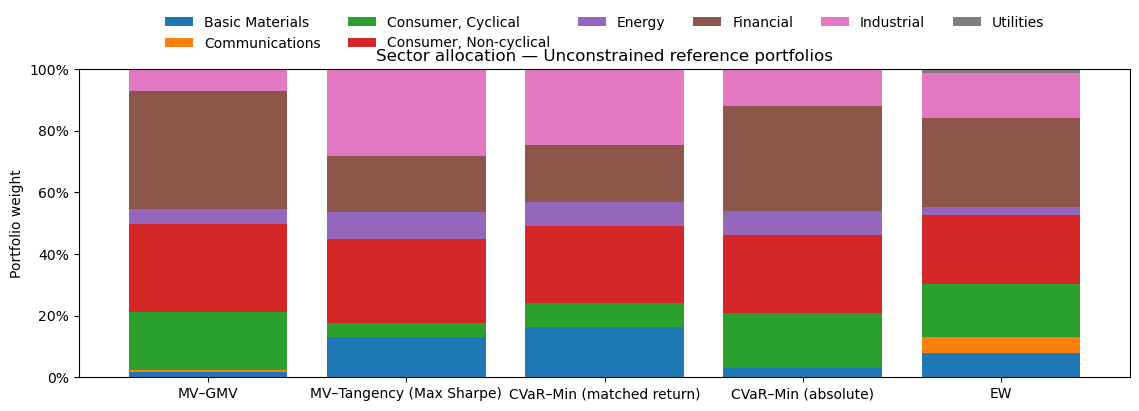

C:\Users\rl495\AppData\Local\Temp\ipykernel_8392\3479095695.py:15: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  alloc = weights_df.groupby(sector_map, axis=1).sum()


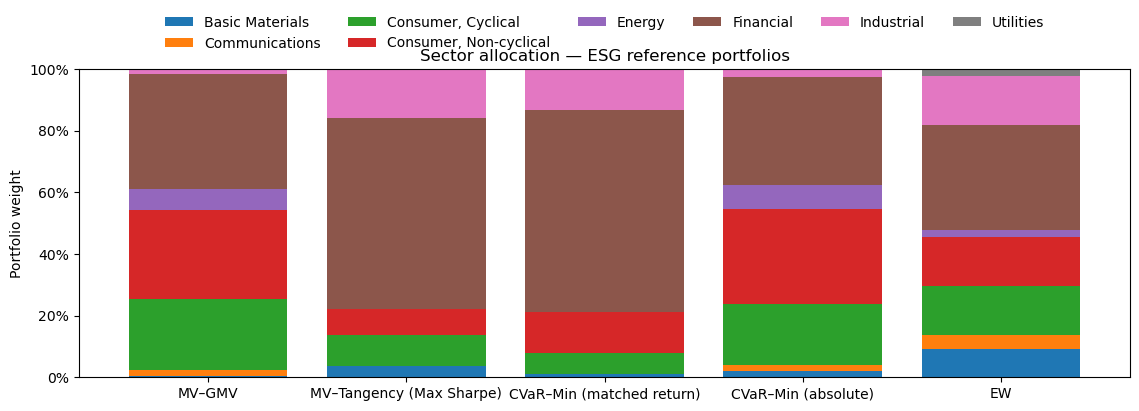

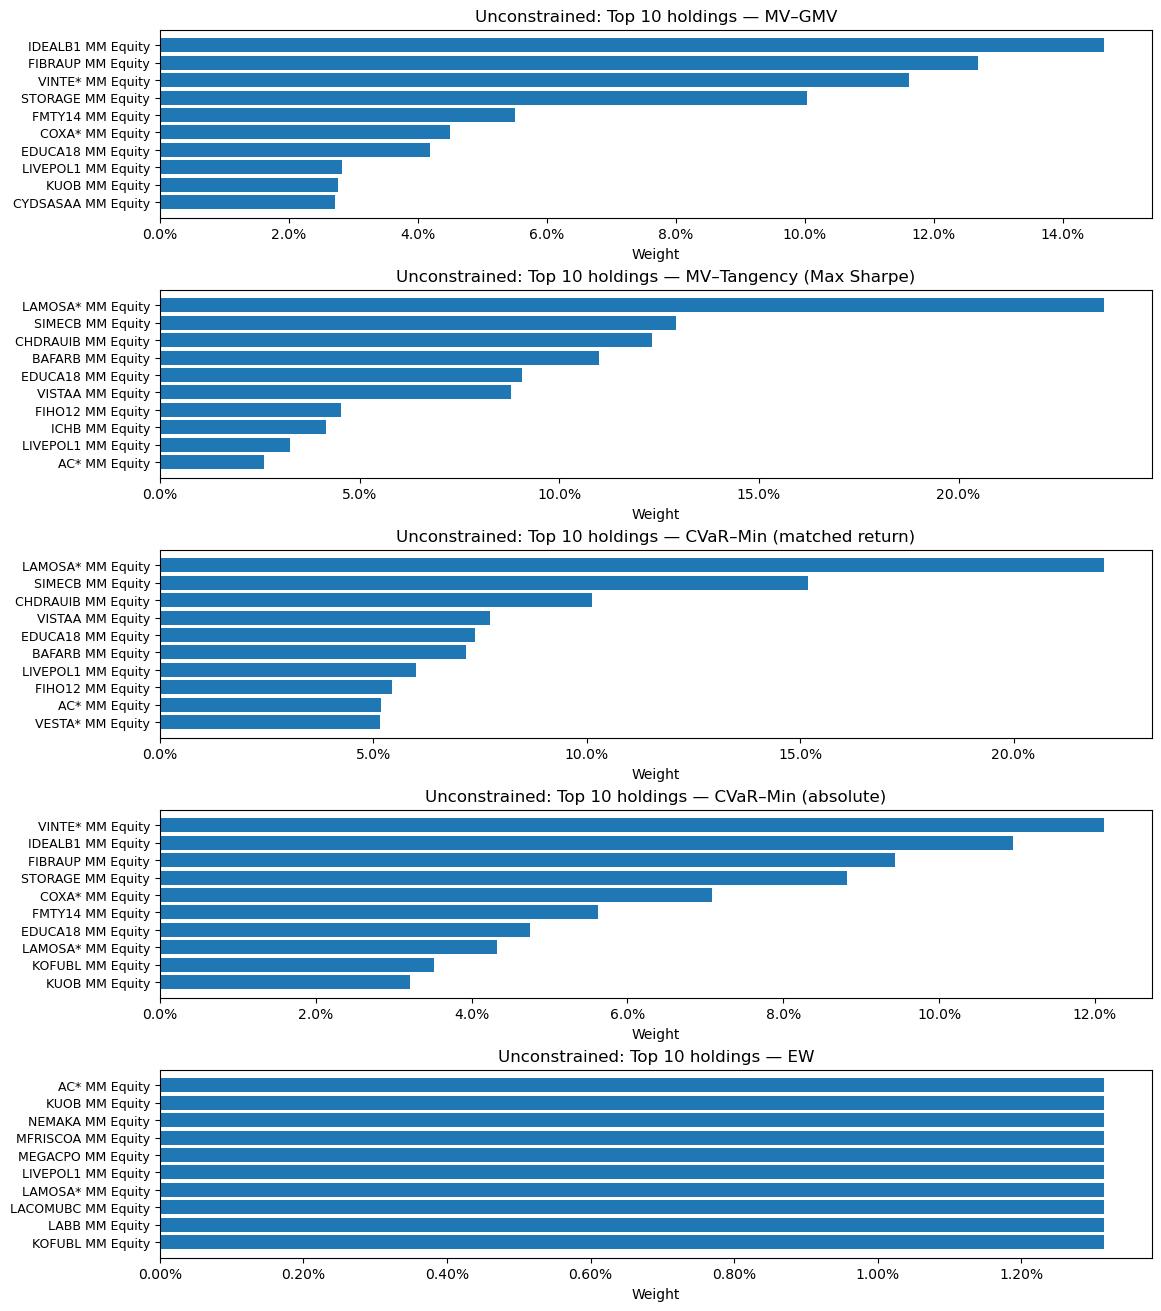

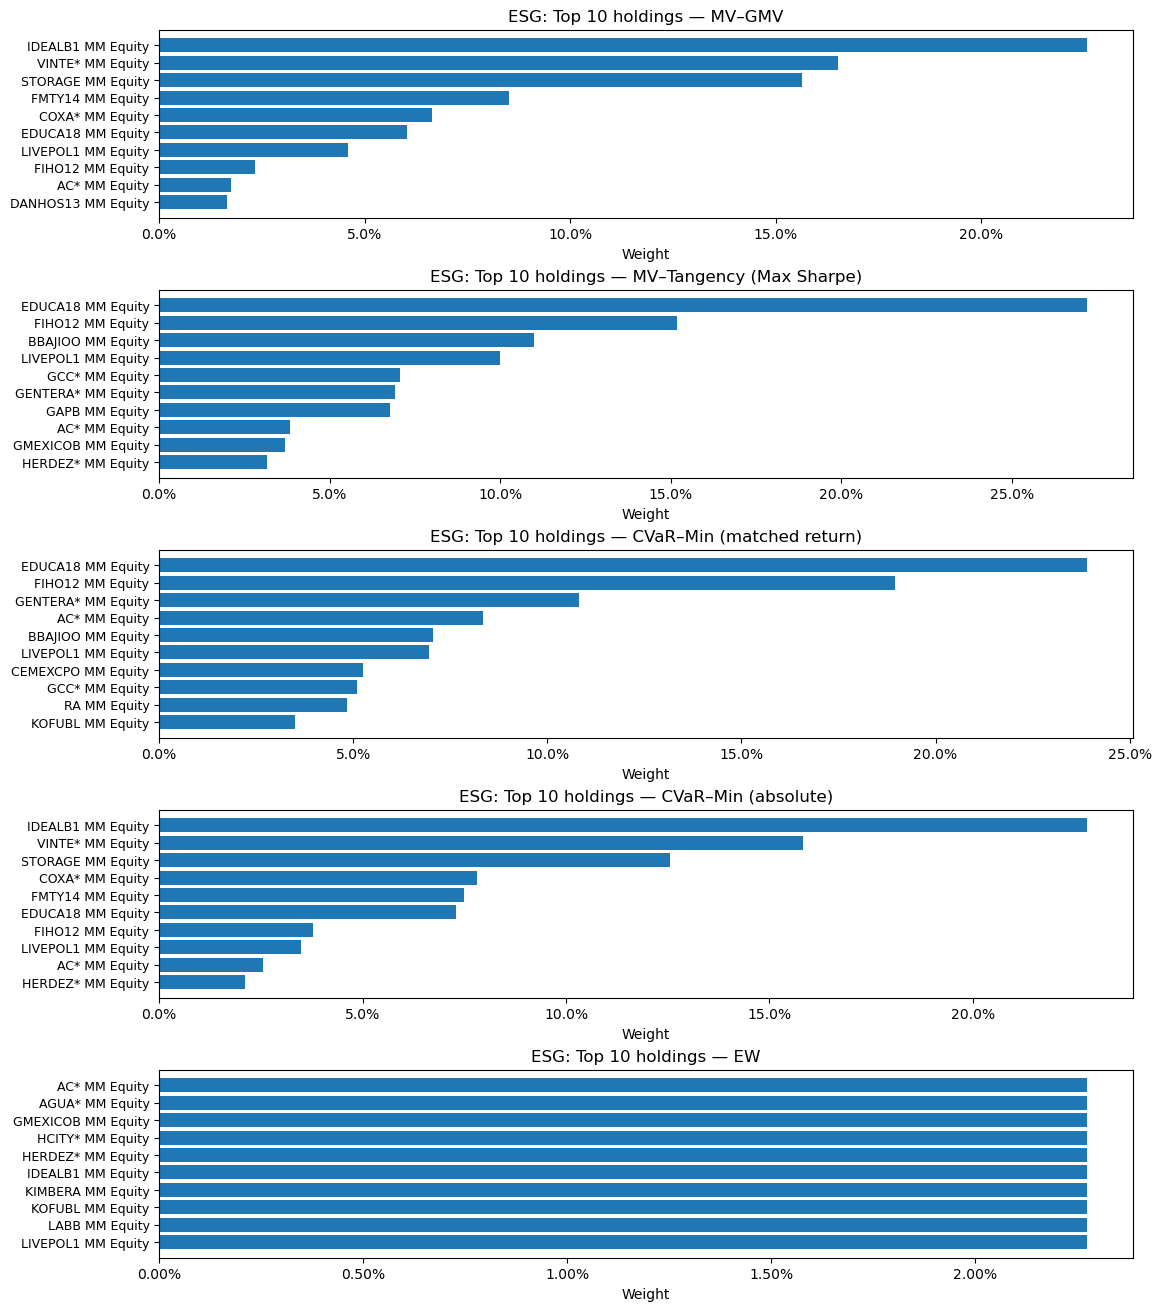

In [69]:
def _short_port_name(s: str) -> str:
    return (s.replace('MV-Tangency (Max Sharpe)', 'MV-Tangency')
             .replace('CVaR-Min (matched return)', 'CVaR-Min @R*')
             .replace('CVaR-Min (absolute)', 'CVaR-Min')
             .replace('Equal-Weight', 'EW')
             .replace('MV-GMV', 'GMV'))

def sector_allocation_bars(weights_df, meta, title):
    """
    Stacked bars by sector for each portfolio.
    Legend is placed above the plot; xticks are shortened and not rotated.
    """
    # map tickers->sector and group columns by that mapping
    sector_map = meta['industry_sector'].reindex(weights_df.columns)
    alloc = weights_df.groupby(sector_map, axis=1).sum()
    alloc = alloc.reindex(sorted(alloc.columns), axis=1)

    # short portfolio labels
    xnames = [_short_port_name(x) for x in alloc.index]

    fig, ax = plt.subplots(figsize=(11.5, 4.8), constrained_layout=False)
    alloc.plot(kind='bar', ax=ax, stacked=True, width=0.8)

    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_xticklabels(xnames, rotation=0)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_ylabel('Portfolio weight')

    # put legend above, on a single row (or two if many sectors)
    handles, labels = ax.get_legend_handles_labels()
    ncol = min(len(labels), 6)
    ax.legend(handles, labels, loc='lower center',
              bbox_to_anchor=(0.5, 1.02), ncol=ncol, frameon=False)

    # leave extra space on top for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


def top10_bars(weights_df, meta, title_prefix):
    """
    Horizontal bars of top-10 holdings for each portfolio.
    Uses constrained_layout so labels don’t collide.
    """
    n = len(weights_df)
    fig, axes = plt.subplots(nrows=n, figsize=(11.5, 2.6*n), constrained_layout=True)
    if n == 1:
        axes = [axes]

    for ax, (pname, row) in zip(axes, weights_df.iterrows()):
        top = row.sort_values(ascending=False).head(10)[::-1]  # smallest on top in barh
        ax.barh(top.index, top.values)
        ax.set_title(f'{title_prefix}: Top 10 holdings — {_short_port_name(pname)}')
        ax.set_xlabel('Weight')
        ax.xaxis.set_major_formatter(PercentFormatter(1.0))
        ax.tick_params(axis='y', labelsize=9)

    plt.show()

# metadata (one row per ticker)
meta_cols = ['Ticker','industry_sector','curr_esg_score', 'cur_mkt_cap']
meta = (filtered_prices[filtered_prices['Ticker'].isin(set(R_univ.columns) | set(R_esg.columns))]
        .drop_duplicates('Ticker')[meta_cols]
        .set_index('Ticker'))

# plots
sector_allocation_bars(weights_univ, meta, 'Sector allocation — Unconstrained reference portfolios')
sector_allocation_bars(weights_esg,  meta, 'Sector allocation — ESG reference portfolios')

top10_bars(weights_univ, meta, 'Unconstrained')
top10_bars(weights_esg,  meta, 'ESG')


In [70]:
from matplotlib.ticker import PercentFormatter

def plot_top10_panel(weights_univ, weights_esg, max_bars=10, savepath=None):
    """
    Make a compact 2×2 panel of Top-10 holdings for:
      (Top row)   MV-Tangency — Unconstrained vs ESG
      (Bottom)    CVaR-Min @R* — Unconstrained vs ESG

    Expects:
      - weights_univ, weights_esg: DataFrames with rows = portfolio names,
        columns = tickers, values = weights (in fractions).
    """

    def _find_row_label(df, must_have):
        must = [s.lower() for s in (must_have if isinstance(must_have, (list,tuple)) else [must_have])]
        for lbl in df.index.astype(str):
            s = lbl.lower()
            if all(m in s for m in must):
                return lbl
        raise KeyError(f"Could not find a row in {list(df.index)} that matches {must}")

    def _plot_top10(ax, w, title):
        s = (w.astype(float)
               .sort_values(ascending=False)
               .head(max_bars))[::-1]           # reverse for horizontal bars (small -> large)
        ax.barh(s.index, s.values, color='C0')
        ax.xaxis.set_major_formatter(PercentFormatter(1.0))
        ax.set_xlim(0, float(s.values.max())*1.20)
        ax.set_xlabel('Weight')
        ax.set_title(title, fontsize=11)
        ax.tick_params(axis='y', labelsize=8)
        # annotate percentages
        for i, v in enumerate(s.values):
            ax.text(v*1.01, i, f"{v:.1%}", va='center', ha='left', fontsize=8)

    # pick the correct rows in each table (robust to naming)
    tan_u  = _find_row_label(weights_univ, ['tangency'])          # MV-Tangency (Max-Sharpe)
    tan_e  = _find_row_label(weights_esg,   ['tangency'])
    cvr_u  = _find_row_label(weights_univ, ['cvar', 'match'])      # CVaR-Min (matched return)
    cvr_e  = _find_row_label(weights_esg,   ['cvar', 'match'])

    # make the panel
    fig, ax = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
    _plot_top10(ax[0,0], weights_univ.loc[tan_u], f"Unconstrained — {tan_u}")
    _plot_top10(ax[0,1], weights_esg.loc[tan_e],   f"ESG — {tan_e}")
    _plot_top10(ax[1,0], weights_univ.loc[cvr_u], f"Unconstrained — {cvr_u}")
    _plot_top10(ax[1,1], weights_esg.loc[cvr_e],   f"ESG — {cvr_e}")

    fig.suptitle("Top-10 holdings — MV-Tangency vs. CVaR-Min @R*", fontsize=13)
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()

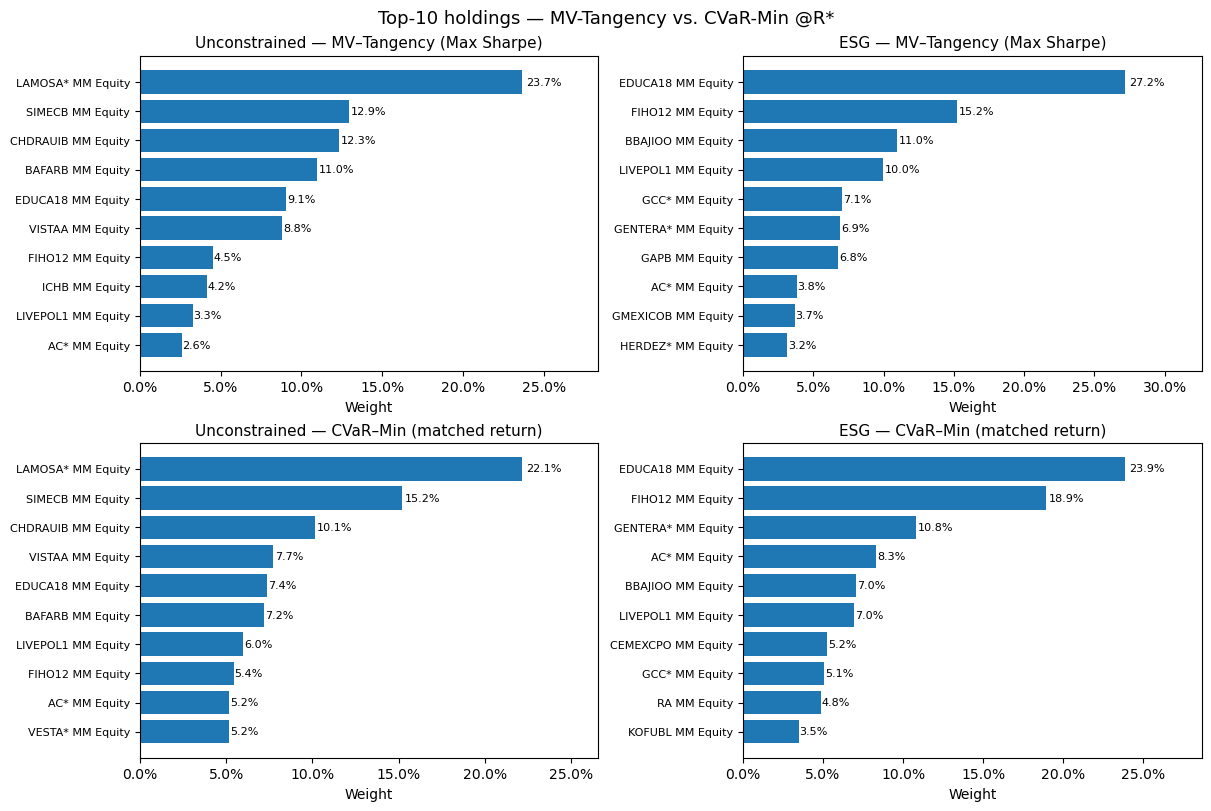

In [65]:
plot_top10_panel(weights_univ, weights_esg, max_bars=10, savepath='top10_panel.png')

# Sensitivity and Robustness

In [66]:
# ==== 0) Inputs reused from your notebook ====
RF_ANNUAL = 0.0775    # keep consistent with the rest of the paper
ALPHA     = 0.95
K         = 12        # grid size for CVaR frontier figure

# If needed, build esg_scores once from your prices metadata
# (skip if you already have 'esg_scores' as a pd.Series indexed by ticker)
if 'esg_scores' not in globals():
    esg_scores = (filtered_prices
                  .drop_duplicates('Ticker')
                  .set_index('Ticker')['curr_esg_score']
                  .astype(float))

# Helper: extract just the two rows we care about and keep numeric columns
def _pick_rows(df):
    mv_row   = df.index[df.index.str.contains('MV', case=False)][0]
    cvar_row = df.index[df.index.str.contains('CVaR', case=False)][0]
    df2 = df.loc[[mv_row, cvar_row]].copy()
    num_cols = df2.select_dtypes('number').columns
    return df2.loc[:, num_cols]

# ==== 1) ESG-threshold sensitivity: baseline (>= mean) vs P70 (>= 70th pct) ====
q70 = esg_scores.quantile(0.70)

# Baseline ESG universe (what you used in the paper)
R_esg_base = R_univ.loc[:, R_univ.columns.isin(R_esg.columns)]
esg_base   = esg_scores.reindex(R_esg_base.columns)

df_base, _ = matched_return_table(R_esg_base, esg_base, label='ESG (>= mean)')
base_pair  = _pick_rows(df_base).rename(index={'MV-Tangency':'MV-Tangency (base)',
                                              'CVAR-Min (@R*)':'CVaR-Min (@R*) (base)'}, errors='ignore')

# Tighter ESG universe: >= 70th percentile
tickers_p70 = esg_scores[esg_scores >= q70].index
R_esg_p70   = R_univ.loc[:, R_univ.columns.isin(tickers_p70)]
esg_p70     = esg_scores.reindex(R_esg_p70.columns)

df_p70, _   = matched_return_table(R_esg_p70, esg_p70, label='ESG (>= P70)')
p70_pair    = _pick_rows(df_p70).rename(index={'MV-Tangency':'MV-Tangency (P70)',
                                              'CVAR-Min (@R*)':'CVaR-Min (@R*) (P70)'}, errors='ignore')

# Align and compute deltas (P70 - Base) for the two rows
base_pair = base_pair.sort_index()
p70_pair  = p70_pair.sort_index()
comp_rows = pd.concat([base_pair, p70_pair], axis=0)

# --- after you compute `base_pair` and `p70_pair` ---

def _normalize_labels(idx: pd.Index) -> pd.Index:
    """Make row names predictable across notebooks."""
    s = pd.Index(idx).astype(str)
    # unify punctuation / spelling
    s = s.str.replace('–', '-', regex=False)            # en-dash → hyphen
    s = s.str.replace('CVAR', 'CVaR', regex=False)      # casing
    s = s.str.replace('CVar', 'CVaR', regex=False)
    s = s.str.replace('(Max Sharpe)', '', regex=False)  # optional suffix
    s = s.str.strip()
    # map to canonical method names
    s = s.where(~s.str.contains('MV', case=False), 'MV-Tangency')
    s = s.where(~s.str.contains('CVAR|CVaR|@R', case=False), 'CVaR-Min (@R*)')
    return s

# normalize and tag the two pairs
base_pair.index = _normalize_labels(base_pair.index) + ' [BASE]'
p70_pair.index  = _normalize_labels(p70_pair.index)  + ' [P70]'

# stack
comp_rows = pd.concat([base_pair, p70_pair]).sort_index()

# helpers to grab the two rows safely
def _row(method: str, tag: str) -> pd.Series:
    # method is like 'MV-Tangency' or 'CVaR-Min (@R*)'
    # tag is '[BASE]' or '[P70]'
    m = comp_rows.index.str.startswith(method) & comp_rows.index.str.endswith(tag)
    out = comp_rows.loc[m]
    if out.empty:
        raise ValueError(
            f'Could not find row for method="{method}", tag="{tag}". '
            f'Available rows: {list(comp_rows.index)}'
        )
    return out.squeeze()
mv_base  = _row('MV-Tangency',     '[BASE]')
mv_p70   = _row('MV-Tangency',     '[P70]')
cvr_base = _row('CVaR-Min (@R*)',  '[BASE]')
cvr_p70  = _row('CVaR-Min (@R*)',  '[P70]')

# build the sensitivity table
def _pack(name, a, b):
    d = (b - a).rename(lambda c: f'Δ_{c}')
    r = pd.concat([a.add_prefix('Base_'), b.add_prefix('P70_'), d])
    r.name = name
    return r

sens_table = pd.DataFrame([
    _pack('MV portfolio',   mv_base,  mv_p70),
    _pack('CVaR portfolio', cvr_base, cvr_p70),
])

# pretty formatting
fmt = sens_table.copy()
for c in fmt.columns:
    if any(c.endswith(x) for x in ['Ret_ann','Vol_ann','CVaR95_d','Max_weight','ESG']):
        fmt[c] = fmt[c].map(lambda x: f'{100*x:.2f}%')
    elif any(c.endswith(x) for x in ['Sharpe','Sortino','Herfindahl']):
        fmt[c] = fmt[c].map(lambda x: f'{x:.2f}')
    elif c.endswith('Holdings'):
        fmt[c] = fmt[c].astype(int)

print('=== ESG-threshold sensitivity (Baseline ≥ mean vs ≥ 70th pct) ===')
display(fmt)

# optional: save
sens_table.to_csv('sensitivity_esg_threshold_raw.csv')
fmt.to_csv('sensitivity_esg_threshold_pretty.csv')



=== ESG-threshold sensitivity (Baseline ≥ mean vs ≥ 70th pct) ===


Base_Ret_ann Base_Vol_ann  Base_VaR95_d Base_CVaR95_d  \
MV portfolio         19.48%       11.60%      0.010854         1.52%   
CVaR portfolio       19.48%       11.96%      0.010919         1.46%   

               Base_Sharpe Base_Sortino  Base_MDD  Base_Holdings  \
MV portfolio          1.01         2.62  0.125545             14   
CVaR portfolio        0.98         2.57  0.128645             14   

               Base_Herfindahl Base_Max_weight  ... Δ_Vol_ann Δ_VaR95_d  \
MV portfolio              0.13          25.72%  ...     5.41%  0.005168   
CVaR portfolio            0.12          22.61%  ...     5.26%  0.005164   

               Δ_CVaR95_d  Δ_Sharpe Δ_Sortino     Δ_MDD Δ_Holdings  \
MV portfolio        0.61%     -0.27     -0.78  0.017167         -6   
CVaR portfolio      0.63%     -0.25     -0.75  0.020385         -4   

                Δ_Herfindahl  Δ_Max_weight   Δ_ESG  
MV portfolio            0.02        -4.42%  62.83%  
CVaR portfolio          0.02        -4.95%  65.33%  

[2 rows x 33 columns]